In [1]:
import numpy as np
import time
import matplotlib.pyplot as plt
import math
import scipy.optimize as optimization
from scipy.optimize import curve_fit
import random
import statistics
from random import shuffle
from scipy import stats
from scipy.stats import binom
from scipy.optimize import minimize, rosen, rosen_der
from astropy.cosmology import WMAP9 as cosmo
import scipy.integrate as integrate
from scipy.stats import gaussian_kde
from scipy.signal import find_peaks

from scipy.integrate import solve_ivp
from astropy.modeling import models
from astropy import units as u
from scipy.constants import h,k,c
import warnings
warnings.filterwarnings("ignore")
from scipy import integrate, interpolate
import lmfit
import corner
from lmfit import Parameters, fit_report, minimize
from scipy.stats import norm
import scipy
from scipy.integrate import quad
import emcee
from sklearn.neighbors import KernelDensity
import sys
import os
from astropy.modeling import models
from astropy import units as u
from astropy.coordinates import Distance
from astropy.cosmology import Planck15

from scipy.integrate import simps

import matplotlib.ticker as ticker


In [2]:
data = np.loadtxt('../LT_relation.txt')

z = data[:,0]
# m = data[:,1]

T = data [:,10]

s250 = data [:,1]
s250_err = data[:,2]

s350 = data [:,3]
s350_err = data[:,4]

s500 = data [:,5]
s500_err = data[:,6]

L_IR = data[:,7]
# L_IR = np.delete(L_IR, 171)

T_log = np.log10(data [:,10])
# T_log = np.delete(T_log, 171)

S_list = []
S_err_list = []
for i in range(len(s250)):
    
    S_list.append((s250[i],s350[i],s500[i]))
    
    S_err_list.append((s250_err[i],s350_err[i],s500_err[i]))
    

S_array = np.array(S_list)

S_err_array = np.array(S_err_list)




index_number = 86



spire_fluxes = (S_array[index_number])
spire_flux_errors = S_err_array[index_number]

# spire_fluxes = np.array([38.8, 56.8, 58.5 ]) 
# spire_flux_errors = np.array([12.4,7.0,5.3])


# actual source parameters
actual_z = z[index_number]
actual_T = T[index_number]



def convert_to_frequency(lam):
    # convert wavelength in um to frequency in Hz
    lam = lam * 1e-6
    return c / lam

def convert_to_wavelength(freq):
    # convert frequency in Hz to wavelength in um
    return 1e6 * c / freq

# ###########################################
# # Define constants

# # wavelength and frequency grids
wa = np.linspace(0.1, 500, 1000)
fa = convert_to_frequency(wa)

# # SPIRE band wavelengths and frequencies
SPIRE_wavelengths = [250, 350, 500]
SPIRE_frequencies = [convert_to_frequency(wavelength) for wavelength in SPIRE_wavelengths]

Beta = 1.5


In [3]:
wavelen_obs = np.array([250e-6,350e-6,500e-6])
    
freq_obs = (c/wavelen_obs)

beta = 1.5

wavelen_obs = np.array([250,350,500])*(10**-6)
    
freq_obs = (c/wavelen_obs)


c = scipy.constants.c
C = (2*scipy.constants.h)/(c*c)



In [4]:
def modified_blackbody_distribution(nu, T_obs, A):
    nu = nu
    

    f = (scipy.constants.h)/(scipy.constants.k)

    B_nu = (nu**3) / (np.exp(f*nu / T_obs) - 1)
    
    S_nu = A *C * (nu**Beta) * B_nu  
    
    return S_nu



def deredshifted_modified_blackbody_distribution(nu, T, A, z):
    return modified_blackbody_distribution(nu / (1 + z), T, A) / (1 + z)

# Vectorize relevant functions
vector_modified_blackbody_distribution = np.vectorize(modified_blackbody_distribution)
vector_deredshifted_modified_blackbody_distribution = np.vectorize(deredshifted_modified_blackbody_distribution)

def compute_lum_dist(z_input):
    """
    Return the luminosity distance in SI units given redshift
    """
    return Distance(z=z_input, cosmology=Planck15).si.value

vector_compute_lum_dist = np.vectorize(compute_lum_dist)


best_fit_poly = [0.13930927, 5.9594352]


# x_scatter = np.random.normal(0, 0.5, 1)


# lt_params = [889.0588851152065, 2.5040970376568774]
# alpha=lt_params[0]
# gamma=lt_params[1]
        


f = lambda e: (10**(np.polyval(best_fit_poly, e) )) * 3.828e26 
# f = lambda e:(alpha*1e5) * e**gamma * 3.828e26




#         lt_params = [889.0588851152065, 2.5040970376568774]


#         def lt(e,lt_params):
#             #return (10**(np.polyval(best_fit_poly, e))) * 3.828e26 

#             alpha=lt_params[0]
#             gamma=lt_params[1]

#             return (alpha*1e5) * e**gamma * 3.828e26 






# compute derivative of L-T function
der_poly = np.polyder(best_fit_poly)
# df_de = lambda e: gamma*(10**alpha)*(e**(gamma-1))

df_de = lambda e: np.log(10) * np.polyval(der_poly, e) * f(e)


# Set up function to interpolate derivative of luminosity function
start = 0.01
end = 7.5
steps = 3000

z_grid, dz = np.linspace(start, end, steps, retstep=True)

DL = vector_compute_lum_dist(z_grid)
dDL_dz = np.gradient(DL, dz)
dDL_map = interpolate.interp1d(z_grid, dDL_dz)


In [5]:
########################### Define transformation of variables functions ###########################

################## Define coordinate functions ##################

def g(z, e, S):
    # returns A as a function of z, e, S(z, e)
    return f(e) / (S * 4 * np.pi * compute_lum_dist(z)**2)

def h(z, e):
    # returns T_obs as a function of z, e
    return e / (1 + z)

################## Define integration functions ##################

# Set integration constant params
upper_bound_b = convert_to_frequency(8)
lower_bound_c = convert_to_frequency(1000)

def integrate_S(z, e):
    # Compute source frame flux with A = 1
    fitted_func = lambda nu: vector_deredshifted_modified_blackbody_distribution(nu, T = e, A=1, z = z)
    F_TIR = integrate.quad(fitted_func, lower_bound_c, upper_bound_b)
    F_TIR = F_TIR[0]
    return F_TIR 

def integrate_dS_dz(z, e):
    # Compute dS_dz
    fitted_func = lambda nu: dS_dz(nu, T = e , z = z)
    F_TIR = integrate.quad(fitted_func, lower_bound_c, upper_bound_b)
    F_TIR = F_TIR[0]
    return F_TIR


def dS_dz(nu, T, z):
    Beta = 1.5
    nu = nu 

    f = (scipy.constants.h)/(scipy.constants.k)

    return - C*(4 + Beta) * nu**(3 + Beta) * (1/(1 + z)**(5 + Beta))  / (np.exp(f*nu / T) - 1) 



def integrate_dS_de(z, e):
    # Compute dS_de
    fitted_func = lambda nu: dS_de(nu, T_e = e , z = z)
    F_TIR = integrate.quad(fitted_func, lower_bound_c, upper_bound_b)
    F_TIR = F_TIR[0]
    return F_TIR 




def dS_de(nu, T_e, z):
    Beta = 1.5
    nu = nu 

    f = (scipy.constants.h)/(scipy.constants.k)

    dS = nu**(3 + Beta) * (1/(1 + z)**(4 + Beta)) * (f*nu/T_e**2) * np.exp(f*nu / T_e)  / (np.exp(f*nu/T_e) - 1)**2
    
    return dS 



# ################## Define derivative functions ##################

# ######### dg_dz and helpers #########

def dg_dz(z, e, S):
    g1, dg1_dz = get_g1z_vals(z, e, S)
    g2, dg2_dz = get_g2z_vals(z, e, S)
    return dg1_dz*g2 + g1*dg2_dz


def get_g1z_vals(z, e, S):
    g1 = 1 / S

    integrated_dS_dz = np.vectorize(integrate_dS_dz)(z, e)
    dg1_dz = (- 1 / S**2) * integrated_dS_dz
    return g1, dg1_dz

def get_g2z_vals(z, e, S):
    g2 = f(e) / (4 * np.pi * compute_lum_dist(z)**2)
    dg2_dz = - 2 * f(e) / (4 * np.pi * compute_lum_dist(z)**3) * dDL_map(z)
    return g2, dg2_dz


# ######### dg_de and helpers #########

def dg_de(z, e, S):
    g1, dg1_de = get_g1e_vals(z, e, S)
    g2, dg2_de = get_g2e_vals(z, e)
    return dg1_de*g2 + g1*dg2_de

def get_g1e_vals(z, e, S):
    g1 = 1 / S
    dg1_de = - 1 / S**2 * np.vectorize(integrate_dS_de)(z, e)
    return g1, dg1_de

def get_g2e_vals(z, e):
    g2 = f(e) / (4 * np.pi * compute_lum_dist(z)**2)
    dg2_de = df_de(e) / (4 * np.pi * compute_lum_dist(z)**2)
    return g2, dg2_de


# ######### dh and helpers #########

def dh_dz(z, e):
    return - e / (1 + z)**2

def dh_de(z, e):
    
    
    return 1 / (1 + z)


# ######### pdf functions and helpers #########
def get_coords(z, e):
    # returns output coordinates from z and T_obs
    S = integrate_S(z, e)
    return np.array([h(z, e), g(z, e, S)])

def jacobian(z, e, S):
    # returns the jacobian from coordinates
    return np.abs(dg_dz(z, e, S)*dh_de(z, e) - dg_de(z, e, S)*dh_dz(z, e))

# Grid resolution
N = 100
M = 100
# Number of steps taken in MCMC
MCMC_steps = 1000

In [6]:
h

<function __main__.h(z, e)>

In [7]:
# Define search grid
z_grid = np.linspace(0.1, 4.5, N)
e_grid = np.linspace(5, 50, M)

# Define Mesh
zz, ee = np.meshgrid(z_grid, e_grid)

# Define corresponding mesh of indices
z_index, e_index = np.meshgrid(range(len(z_grid)), range(len(e_grid)))

# print("Initializing parameters")
# time0 = time.time()


S_grid = np.vectorize(integrate_S)(zz, ee)

hh, gg = np.vectorize(h)(zz, ee), np.vectorize(g)(zz, ee, S_grid)

# Compute relevant values at each point
print("Initializing parameters")
time0 = time.time()

# evaluate flux at each point in mesh
S_grid = np.vectorize(integrate_S)(zz, ee)
print("finished flux grid")

# get change of variables points at each location in mesh
hh, gg = np.vectorize(h)(zz, ee), np.vectorize(g)(zz, ee, S_grid)
print("finished output coordinate grid")

# evaluate jacobian at each point in mesh
jacob = np.vectorize(jacobian)(zz, ee, S_grid)
print("finished jacobian")

# time1 = time.time()

# print("Initialization took: ", time1 - time0)

Initializing parameters
finished flux grid
finished output coordinate grid
finished jacobian


# ######

In [34]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.integrate import simps

def plot_3_flux(index_number):
    spire_fluxes, spire_flux_errors = S_array[index_number], S_err_array[index_number]
    actual_z, actual_T = z[index_number], T[index_number]

    # Set initial fit parameters
    p = lmfit.Parameters()
    p.add_many(('T0', 10), ('A0', 1))

    # Define residual function
    def residual(p):
        v = p.valuesdict()
        return (vector_modified_blackbody_distribution(freq_obs, v['T0'], v['A0']) - spire_fluxes) / spire_flux_errors

    # Obtain initial fit using minimizers
    mi = lmfit.minimize(residual, p, method='nelder')

    # Show best fit model
    T_obs, A = mi.params['T0'].value, mi.params['A0'].value
    best_fit = vector_modified_blackbody_distribution(fa, T_obs, A)

    # Create 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Best fitting model vs. data
    axs[0, 0].loglog()
    axs[0, 0].set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    axs[0, 0].set_ylabel('Flux density [mJ]', fontsize=18)
    axs[0, 0].plot(wa, best_fit, label='Best fitting model')
    axs[0, 0].errorbar(SPIRE_wavelengths, spire_fluxes, yerr=spire_flux_errors)
    
    axs[0, 0].set_xlim(5e1, 6e2)
    axs[0, 0].set_ylim(1e-1, 2e2)

    # Set xticks for ax1
    locs = np.append(axs[0, 0].xaxis.get_major_locator().tick_values(5e1, 6e2), [250, 350, 500])
    axs[0, 0].xaxis.set_major_locator(ticker.FixedLocator(locs))
    labels = [str(int(loc)) if loc >= 100 else '' for loc in locs]
    axs[0, 0].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    axs[0, 0].tick_params(axis='both', which='major', labelsize=16)

    # Run MCMC chain using initial fit
    res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10, 
                         params=mi.params, is_weighted=True, progress=False,seed=12345)
    

    

    # Get MCMC outputs
    Ts = np.array(res.flatchain['T0'])
    As = np.array(res.flatchain['A0'])

    # Define normalized pdf over fit params
    values = np.vstack([Ts, As])
    kde_kernel = gaussian_kde(values)

    # Plot 2: Gaussian kernel with actual source parameters
    N = 100
    X, Y = np.meshgrid(np.linspace(Ts.min(), Ts.max(), N), np.linspace(As.min(), As.max(), N))
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kde_kernel(positions).T, X.shape)
#     Z = Z / np.sum(Z)
    
        
    Z = Z / simps(simps(Z, X[0, :]), Y[:, 0])

    # Multiply by Jacobian (assuming jacob has shape (100, 100))
    p_z_e = Z * jacob

    # Marginalize over emission (T_obs) to get p(z)
    p_z = np.array([simps(p, e_grid) for p in p_z_e.T])

    # Normalize the marginalized pdf
    p_z = p_z / simps(p_z, z_grid)

    axs[0, 1].contour(X, Y, Z, 5)
    axs[0, 1].set_xlabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18)
    axs[0, 1].set_ylabel(r'$\mathit{A}$', fontsize=18, rotation=0, labelpad=15)
    axs[0, 1].tick_params(axis='both', which='major', labelsize=16)
    axs[0, 1].set_xlim([Ts.min(), Ts.max()])
    axs[0, 1].set_ylim([As.min(), As.max()])
    
#     axs[0, 1].set_xlim([0, 30])
#     axs[0, 1].set_ylim([0,1])

    # Add color bar to second plot
#     cbar = fig.colorbar(axs[0, 1].contour(X, Y, Z, 5, cmap='RdGy'), ax=axs[0, 1])
#     cbar.set_label('Probability density', fontsize=18, labelpad=15)

    # Define functions to access KDE results
    def get_pdf_s_t(a, t):
        return kde_kernel.pdf(np.array([[t, a]]).T)[0]

    def get_p_z_e(z_i, e_i):
        return get_pdf_s_t(a=gg[z_i, e_i], t=hh[z_i, e_i])

    pdf_z_e = np.vectorize(get_p_z_e)

    # Compute pdf over emission frame meshgrid
    p_z_e = np.array(pdf_z_e(z_i=z_index, e_i=e_index))

    


    # Add color bar to third plot
#     cbar3 = fig.colorbar(axs[1, 1].contour(zz, ee, p_z_e, 5, cmap='RdGy'), ax=axs[1, 1])
#     cbar3.set_label('Probability density', fontsize=18, labelpad=20)

    # Multiply by jacobian and marginalize over e
    p_z_e = p_z_e * jacob
    p_z_e = p_z_e/np.sum(p_z_e)
    
    p_z = np.array([simps(p, e_grid) for p in p_z_e.T])
    p_z = p_z / np.sum(p_z)

    
        # Plot 3: Contour plot of emission frame
    axs[1, 1].contour(zz, ee, p_z_e, 5, cmap='Blues', alpha=0.5, label=f'Galaxy {index_number}')
    
    axs[1, 1].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 1].set_ylabel(r'$\mathit{T}_{\mathrm{em}}$', fontsize=18, rotation=0, labelpad=20)
    axs[1, 1].tick_params(axis='both', which='major', labelsize=16)
    
    axs[1, 1].set_xlim(0, 3)
    axs[1, 1].set_ylim(0, 20)
    
    
#     # Compute the KDE over the meshgrid (do NOT normalize yet)
#     Z = np.reshape(kde_kernel(positions).T, X.shape)

#     # Multiply by Jacobian (apply Jacobian before marginalizing)
#     p_z_e = Z * jacob

#     # Marginalize over e (emission variable)
#     p_z = np.array([simps(p, e_grid) for p in p_z_e.T])

#     # Normalize the marginalized pdf
#     p_z = p_z / np.sum(p_z)



    # Plot 4: Marginalized pdf over z
    axs[1, 0].plot(z_grid, p_z)
    axs[1, 0].axvline(x=z[index_number], label='True redshift', linestyle='dashed')
    axs[1, 0].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 0].set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
    axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
    axs[1, 0].legend(fontsize=16)

    
#             # Replace the bottom-left plot (Marginalized pdf over z) with a new KDE-based function
#     def marginalized_pdf_z(ax, Ts, As, z_values, label, color, actual_z):
#         # Combine Ts and As to calculate KDE over redshift
#         values = np.vstack([Ts, As])
#         kde_kernel = gaussian_kde(values)

#         # Create meshgrid for z and emission
#         N = 100  # Number of grid points
#         z_grid = np.linspace(min(z_values), max(z_values), N)
#         e_grid = np.linspace(min(As), max(As), N)
#         Z, E = np.meshgrid(z_grid, e_grid)

#         # Compute the KDE over the meshgrid
#         positions = np.vstack([Z.ravel(), E.ravel()])
#         P = np.reshape(kde_kernel(positions).T, Z.shape)
#         P = P / np.sum(P)  # Normalize the PDF

#         # Multiply by Jacobian and marginalize over emission (e) for redshift
#         marginalized_p_z = np.array([simps(P[:, i], e_grid) for i in range(P.shape[1])])
#         marginalized_p_z = marginalized_p_z / np.sum(marginalized_p_z)  # Normalize

#         # Plot the marginalized PDF for redshift
#         ax.plot(z_grid, marginalized_p_z, label=label, color=color)
# #         ax.axvline(x=actual_z, linestyle='dashed', color=color, label=f'True z {label}')
#         ax.set_xlabel(r'$\mathit{z}$', fontsize=18)
#         ax.set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
#         ax.tick_params(axis='both', which='major', labelsize=16)
#         ax.legend(fontsize=16)
    
# #     Use the new KDE-based PDF calculation for both galaxies
#     marginalized_pdf_z(axs[1, 0], Ts, As, z_grid, f'Galaxy {index_number}', 'red', actual_z)

    
    
    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()
    


    # Print fit report
#     lmfit.printfuncs.report_fit(mi.params, min_correl=0.0)


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [81.18234875 77.94146057]


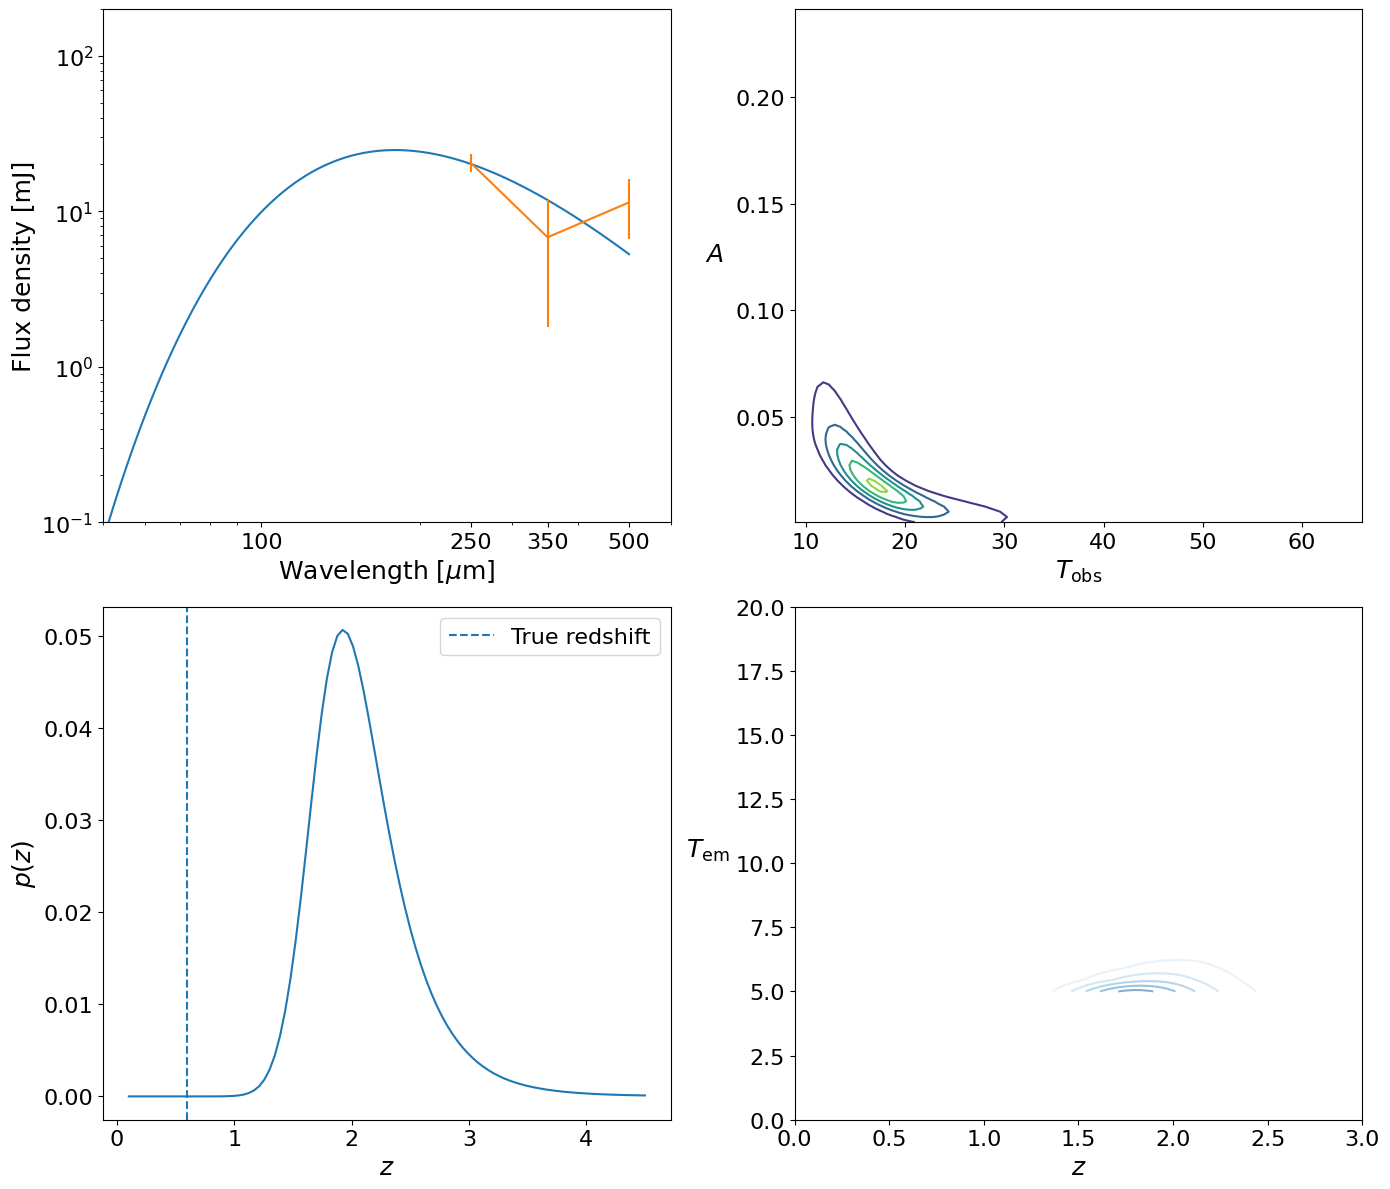

In [35]:
plot_3_flux(56)

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [72.37221105 67.77774088]


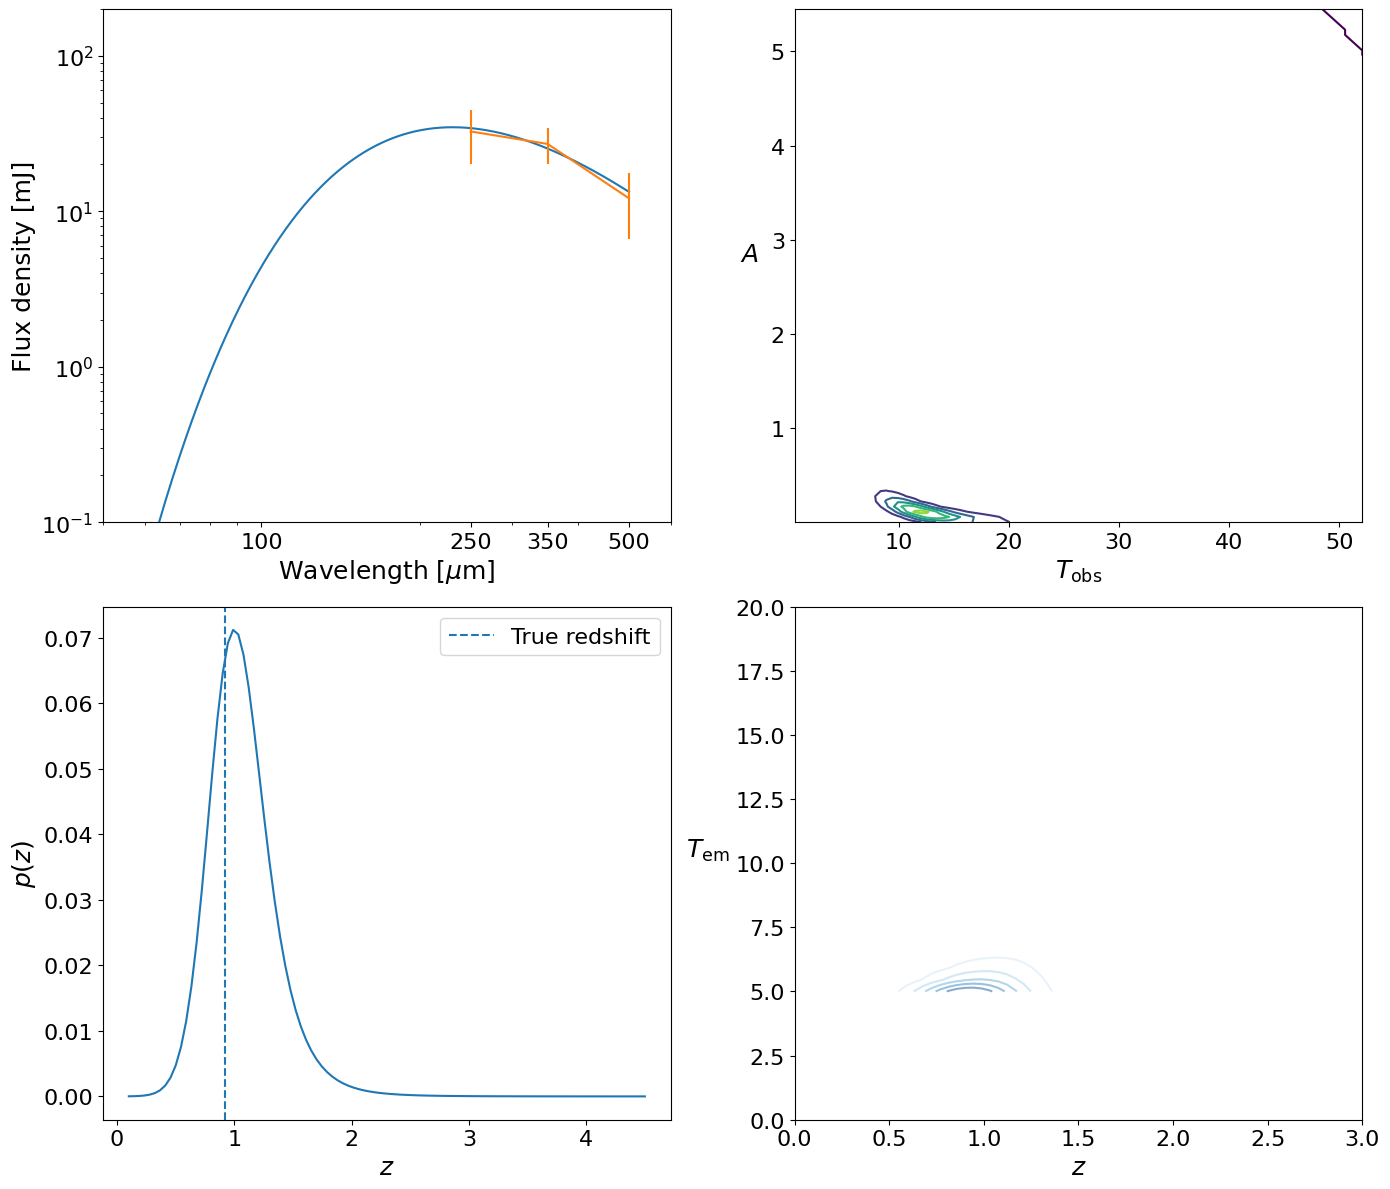

In [36]:
plot_3_flux(3)

In [14]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.integrate import simps

def plot_3_flux(index_number, jacob):
    spire_fluxes, spire_flux_errors = S_array[index_number], S_err_array[index_number]
    actual_z, actual_T = z[index_number], T[index_number]

    # Set initial fit parameters
    p = lmfit.Parameters()
    p.add_many(('T0', 10), ('A0', 1))

    # Define residual function
    def residual(p):
        v = p.valuesdict()
        return (vector_modified_blackbody_distribution(freq_obs, v['T0'], v['A0']) - spire_fluxes) / spire_flux_errors

    # Obtain initial fit using minimizers
    mi = lmfit.minimize(residual, p, method='nelder')

    # Show best fit model
    T_obs, A = mi.params['T0'].value, mi.params['A0'].value
    best_fit = vector_modified_blackbody_distribution(fa, T_obs, A)

    # Create 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Best fitting model vs. data
    axs[0, 0].loglog()
    axs[0, 0].set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    axs[0, 0].set_ylabel('Flux density [mJ]', fontsize=18)
    axs[0, 0].plot(wa, best_fit, label='Best fitting model')
    axs[0, 0].errorbar(SPIRE_wavelengths, spire_fluxes, yerr=spire_flux_errors, fmt='o', label=f'Galaxy {index_number}')
    
    axs[0, 0].set_xlim(5e1, 6e2)
    axs[0, 0].set_ylim(1e-1, 2e2)

    # Set xticks for ax1
    locs = np.append(axs[0, 0].xaxis.get_major_locator().tick_values(5e1, 6e2), [250, 350, 500])
    axs[0, 0].xaxis.set_major_locator(ticker.FixedLocator(locs))
    labels = [str(int(loc)) if loc >= 100 else '' for loc in locs]
    axs[0, 0].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    axs[0, 0].tick_params(axis='both', which='major', labelsize=16)

    # Run MCMC chain using initial fit
    res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10, 
                         params=mi.params, is_weighted=True, progress=False, seed=12345)

    # Get MCMC outputs
    Ts = np.array(res.flatchain['T0'])
    As = np.array(res.flatchain['A0'])

    # Define normalized pdf over fit params
    values = np.vstack([Ts, As])
    kde_kernel = gaussian_kde(values)

    # Plot 2: Gaussian kernel with actual source parameters
    N = 100
    X, Y = np.meshgrid(np.linspace(Ts.min(), Ts.max(), N), np.linspace(As.min(), As.max(), N))
    positions = np.vstack([X.ravel(), Y.ravel()])
    Z = np.reshape(kde_kernel(positions).T, X.shape)
    Z = Z / np.sum(Z)

    axs[0, 1].contour(X, Y, Z, 5)
    axs[0, 1].set_xlabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18)
    axs[0, 1].set_ylabel(r'$\mathit{A}$', fontsize=18, rotation=0, labelpad=15)
    axs[0, 1].tick_params(axis='both', which='major', labelsize=16)
    axs[0, 1].set_xlim([Ts.min(), Ts.max()])
    axs[0, 1].set_ylim([As.min(), As.max()])

    # Plot 3: Contour plot of z vs. T_obs
    zz, ee = np.meshgrid(z_grid, Ts)  # Create meshgrid of z and T_obs
    kde_values = np.vstack([zz.ravel(), ee.ravel()])
    p_z_Tobs = np.reshape(kde_kernel(kde_values).T, zz.shape)  # Get KDE over z and T_obs
    p_z_Tobs = p_z_Tobs / np.sum(p_z_Tobs)

    axs[1, 1].contour(zz, ee, p_z_Tobs, cmap='RdGy')
    axs[1, 1].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 1].set_ylabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18, rotation=0, labelpad=20)
    axs[1, 1].tick_params(axis='both', which='major', labelsize=16)
    axs[1, 1].set_xlim(0, 10)
    axs[1, 1].set_ylim(Ts.min(), Ts.max())

    # Multiply by jacobian and marginalize over e
    
    jacob = np.resize(jacob, p_z_Tobs.shape)
    p_z_e = p_z_Tobs * jacob
    p_z_e = p_z_e / np.sum(p_z_e)

    # Marginalize over temperature (T_obs) to get p(z)
    p_z = np.array([simps(p, Ts) for p in p_z_e.T])
    p_z = p_z / np.sum(p_z)

    # Plot 4: Marginalized pdf over z
    axs[1, 0].plot(z_grid, p_z)
    axs[1, 0].axvline(x=z[index_number], label='True redshift', linestyle='dashed')
    axs[1, 0].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 0].set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
    axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
    axs[1, 0].legend(fontsize=16)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [28.18682319 28.21943735]


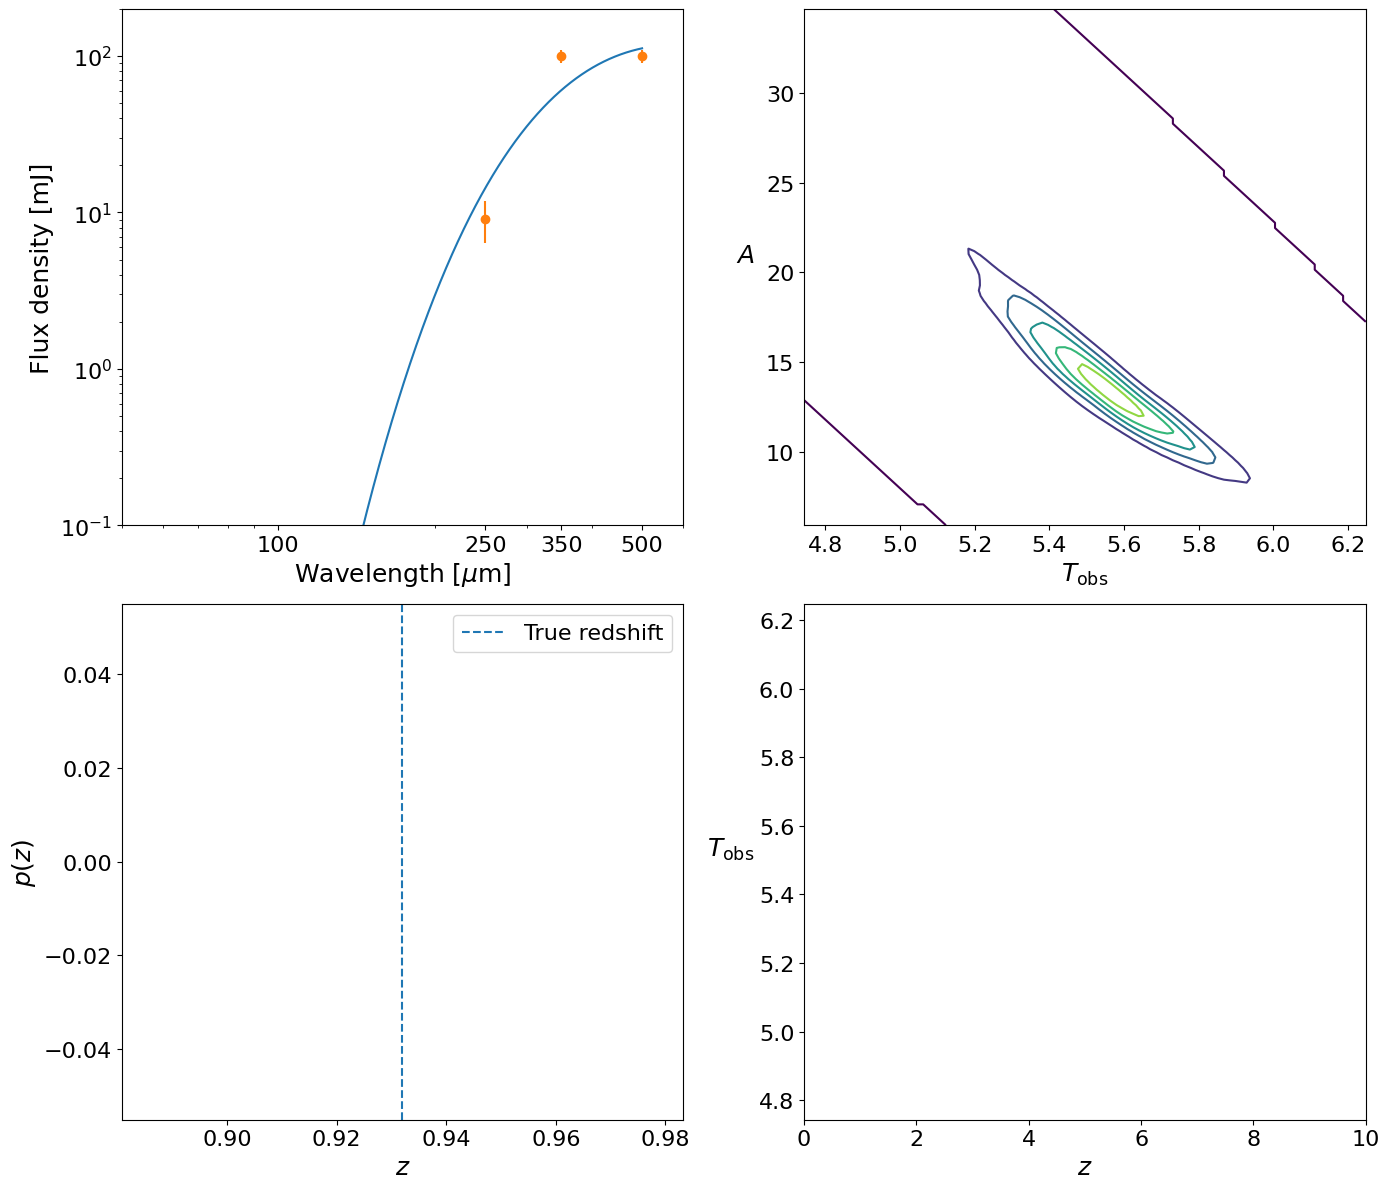

In [16]:
plot_3_flux(92,jacob)

In [17]:
import numpy as np
import lmfit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.integrate import simps

def compare_3_flux(index1, index2):
    # Get data for both galaxies
    spire_fluxes_1, spire_flux_errors_1 = S_array[index1], S_err_array[index1]
    actual_z_1, actual_T_1 = z[index1], T[index1]

    spire_fluxes_2, spire_flux_errors_2 = S_array[index2], S_err_array[index2]
    actual_z_2, actual_T_2 = z[index2], T[index2]

    def fit_galaxy(spire_fluxes, spire_flux_errors):
        p = lmfit.Parameters()
        p.add_many(('T0', 10), ('A0', 1))

        def residual(p):
            v = p.valuesdict()
            return (vector_modified_blackbody_distribution(freq_obs, v['T0'], v['A0']) - spire_fluxes) / spire_flux_errors

        mi = lmfit.minimize(residual, p, method='nelder')
        T_obs = mi.params['T0'].value
        A = mi.params['A0'].value
        best_fit = vector_modified_blackbody_distribution(fa, T_obs, A)

        return mi, residual, T_obs, A, best_fit

    # Fit results for both galaxies
    mi_1, residual_1, T_obs_1, A_1, best_fit_1 = fit_galaxy(spire_fluxes_1, spire_flux_errors_1)
    mi_2, residual_2, T_obs_2, A_2, best_fit_2 = fit_galaxy(spire_fluxes_2, spire_flux_errors_2)

    def run_mcmc(residual, mi):
        res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10, 
                             params=mi.params, is_weighted=True, progress=False)
        
        Ts = np.array(res.flatchain['T0'])
        As = np.array(res.flatchain['A0'])
        return Ts, As

    # Run MCMC for both galaxies
    Ts_1, As_1 = run_mcmc(residual_1, mi_1)
    Ts_2, As_2 = run_mcmc(residual_2, mi_2)

    # Create 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Best fitting model vs. data
    axs[0, 0].loglog()
    axs[0, 0].set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    axs[0, 0].set_ylabel('Flux density [mJ]', fontsize=18)

    # Plot for Galaxy 1
    axs[0, 0].plot(wa, best_fit_1, label=f'Galaxy {index1} Best Fit', color='blue')
    axs[0, 0].errorbar(SPIRE_wavelengths, spire_fluxes_1, yerr=spire_flux_errors_1, label=f'Galaxy {index1} Data',fmt='None', color='darkblue')

    # Plot for Galaxy 2
    axs[0, 0].plot(wa, best_fit_2, label=f'Galaxy {index2} Best Fit', color='red')
    axs[0, 0].errorbar(SPIRE_wavelengths, spire_fluxes_2, yerr=spire_flux_errors_2, label=f'Galaxy {index2} Data', fmt='None', color='darkred')

#     axs[0, 0].legend()
    axs[0, 0].set_xlim(5e1, 6e2)
    axs[0, 0].set_ylim(1e-1, 9e2)

    # Set xticks for ax1
    locs = np.append(axs[0, 0].xaxis.get_major_locator().tick_values(5e1, 6e2), [250, 350, 500])
    axs[0, 0].xaxis.set_major_locator(ticker.FixedLocator(locs))
    labels = [str(int(loc)) if loc >= 100 else '' for loc in locs]
    axs[0, 0].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    axs[0, 0].tick_params(axis='both', which='major', labelsize=16)

    # Plot 2: Gaussian KDE results
    def plot_kde(ax, Ts, As, color, label):
        values = np.vstack([Ts, As])
        kde_kernel = gaussian_kde(values)

        N = 100
        X, Y = np.meshgrid(np.linspace(Ts.min(), Ts.max(), N), np.linspace(As.min(), As.max(), N))
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kde_kernel(positions).T, X.shape)
        Z = Z / np.sum(Z)

        # Plot contour
        ax.contour(X, Y, Z, 20, colors=color, label=label)
        ax.set_xlabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18)
        ax.set_ylabel(r'$\mathit{A}$', fontsize=18, rotation=0, labelpad=15)
        ax.tick_params(axis='both', which='major', labelsize=16)

    # Plot KDE for both galaxies
    plot_kde(axs[0, 1], Ts_1, As_1, 'blue', f'Galaxy {index1}')
    plot_kde(axs[0, 1], Ts_2, As_2, 'red', f'Galaxy {index2}')
    
    axs[0, 1].set_xlim(0, 40)
    axs[0, 1].set_ylim(0, 1.8)


    # Define functions to access KDE results
    def get_pdf_s_t(a, t, kde_kernel):
        return kde_kernel.pdf(np.array([[t, a]]).T)[0]

    def get_p_z_e(z_i, e_i, kde_kernel):
        return get_pdf_s_t(a=gg[z_i, e_i], t=hh[z_i, e_i], kde_kernel=kde_kernel)

    pdf_z_e = np.vectorize(get_p_z_e)

    # Compute pdf over emission frame meshgrid for both galaxies
    kde_kernel_1 = gaussian_kde(np.vstack([Ts_1, As_1]))
    kde_kernel_2 = gaussian_kde(np.vstack([Ts_2, As_2]))

    p_z_e_1 = np.array(pdf_z_e(z_i=z_index, e_i=e_index, kde_kernel=kde_kernel_1))
    p_z_e_2 = np.array(pdf_z_e(z_i=z_index, e_i=e_index, kde_kernel=kde_kernel_2))

    # Plot 3: Contour plot of emission frame for both galaxies
    axs[1, 1].contour(zz, ee, p_z_e_1, 5, cmap='Blues', alpha=0.5, label=f'Galaxy {index1}')
    axs[1, 1].contour(zz, ee, p_z_e_2, 5, cmap='Reds', alpha=0.5, label=f'Galaxy {index2}')
    axs[1, 1].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 1].set_ylabel(r'$\mathit{T}_{\mathrm{em}}$', fontsize=18, rotation=0, labelpad=20)
    axs[1, 1].tick_params(axis='both', which='major', labelsize=16)
#     axs[1, 1].legend()

    # Multiply by jacobian and marginalize over e for both galaxies
    p_z_e_1 *= jacob
    p_z_1 = np.array([simps(p, e_grid) for p in p_z_e_1.T])
    p_z_1 = p_z_1 / np.sum(p_z_1)

    p_z_e_2 *= jacob
    p_z_2 = np.array([simps(p, e_grid) for p in p_z_e_2.T])
    p_z_2 = p_z_2 / np.sum(p_z_2)

    # Plot 4: Marginalized pdf over z for both galaxies
    axs[1, 0].plot(z_grid, p_z_1, label=f'Galaxy {index1}', color='blue')
    axs[1, 0].plot(z_grid, p_z_2, label=f'Galaxy {index2}', color='red')
    axs[1, 0].axvline(x=actual_z_1, label=f'True z Galaxy {index1}', linestyle='dashed', color='blue')
    axs[1, 0].axvline(x=actual_z_2, label=f'True z Galaxy {index2}', linestyle='dashed', color='red')
    axs[1, 0].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 0].set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
    axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
#     axs[1, 0].legend(fontsize=16)
    
    
    
    
    
    
    
    
    
    
    
        # Replace the bottom-left plot (Marginalized pdf over z) with a new KDE-based function
    def marginalized_pdf_z(ax, Ts, As, z_values, label, color, actual_z):
        # Combine Ts and As to calculate KDE over redshift
        values = np.vstack([Ts, As])
        kde_kernel = gaussian_kde(values)

        # Create meshgrid for z and emission
        N = 100  # Number of grid points
        z_grid = np.linspace(min(z_values), max(z_values), N)
        e_grid = np.linspace(min(As), max(As), N)
        Z, E = np.meshgrid(z_grid, e_grid)

        # Compute the KDE over the meshgrid
        positions = np.vstack([Z.ravel(), E.ravel()])
        P = np.reshape(kde_kernel(positions).T, Z.shape)
        P = P / np.sum(P)  # Normalize the PDF

        # Multiply by Jacobian and marginalize over emission (e) for redshift
        marginalized_p_z = np.array([simps(P[:, i], e_grid) for i in range(P.shape[1])])
        marginalized_p_z = marginalized_p_z / np.sum(marginalized_p_z)  # Normalize

        # Plot the marginalized PDF for redshift
        ax.plot(z_grid, marginalized_p_z, label=label, color=color)
        ax.axvline(x=actual_z, linestyle='dashed', color=color, label=f'True z {label}')
        ax.set_xlabel(r'$\mathit{z}$', fontsize=18)
        ax.set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
        ax.tick_params(axis='both', which='major', labelsize=16)
#         ax.legend(fontsize=16)
    
    # Use the new KDE-based PDF calculation for both galaxies
#     marginalized_pdf_z(axs[1, 0], Ts_1, As_1, z_grid, f'Galaxy {index1}', 'blue', actual_z_1)
#     marginalized_pdf_z(axs[1, 0], Ts_2, As_2, z_grid, f'Galaxy {index2}', 'red', actual_z_2)


    
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

#     # Print fit reports
#     print("Galaxy", index1)
#     lmfit.printfuncs.report_fit(mi_1.params, min_correl=0.0)
#     print("Galaxy", index2)
#     lmfit.printfuncs.report_fit(mi_2.params, min_correl=0.0)


The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [124.90516312 111.64340191]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [56.19905894 51.98878559]


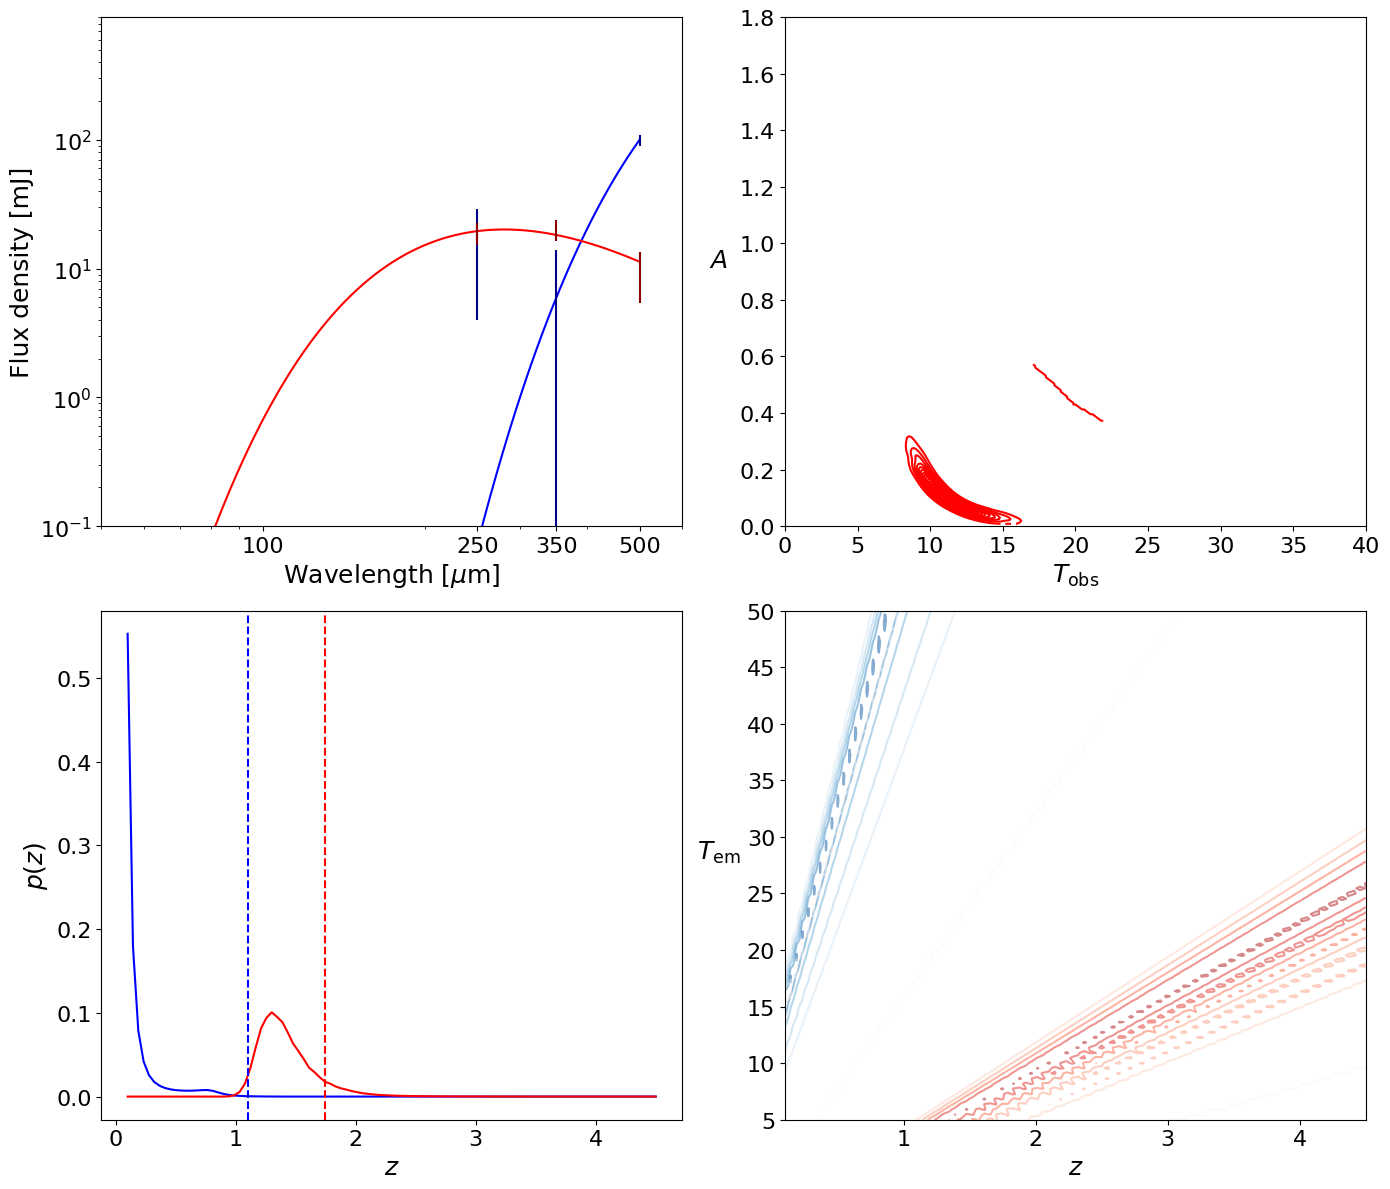

In [19]:
compare_3_flux(index1=0, index2=49)



GALAXY ID =  0
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [126.41081312 109.29979022]


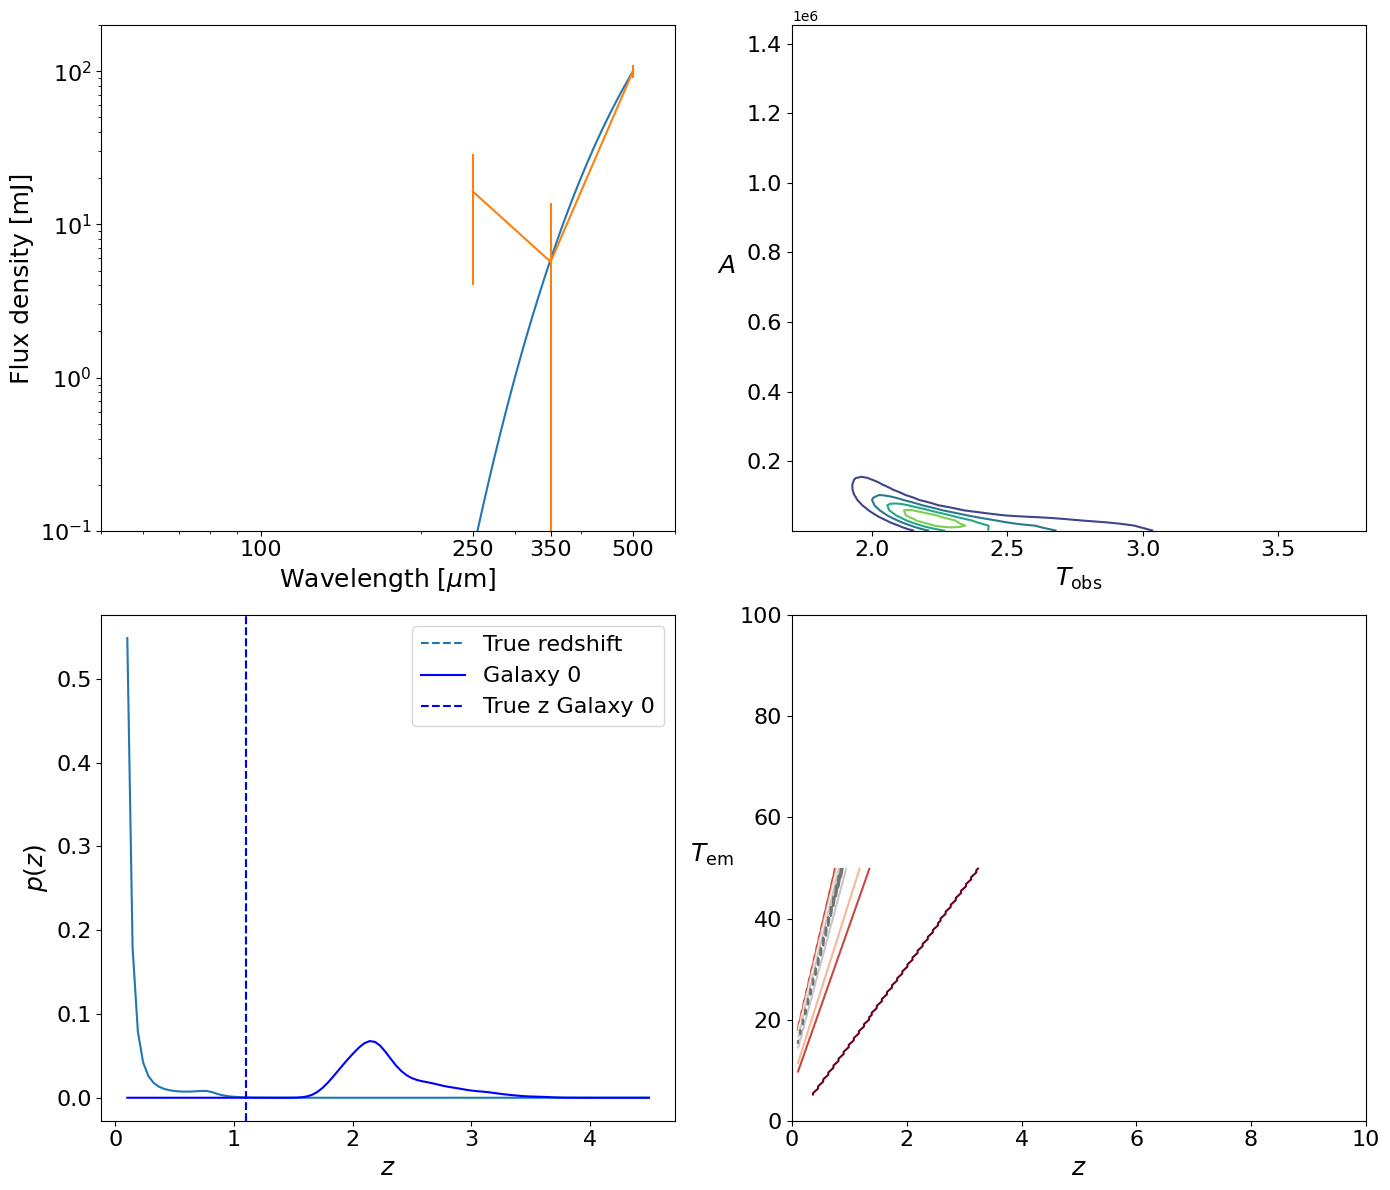

----------------------------------------------------------
GALAXY ID =  1
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [71.61505411 68.41088677]


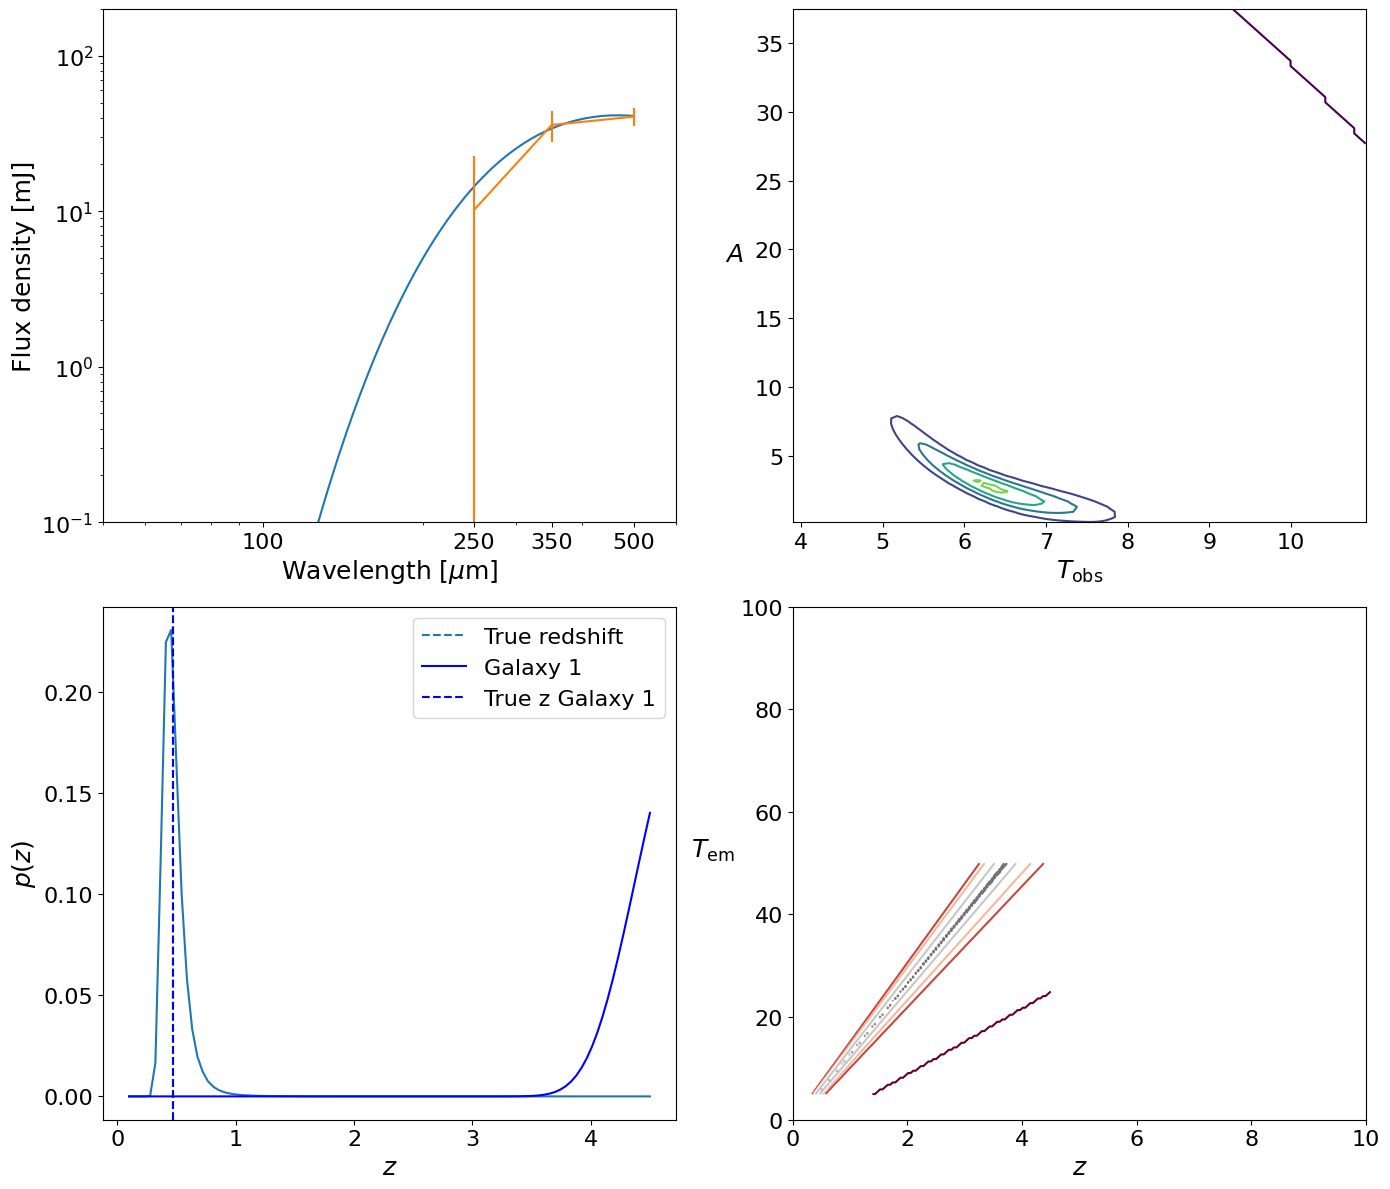

----------------------------------------------------------
GALAXY ID =  2
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [68.60983922 60.92450536]


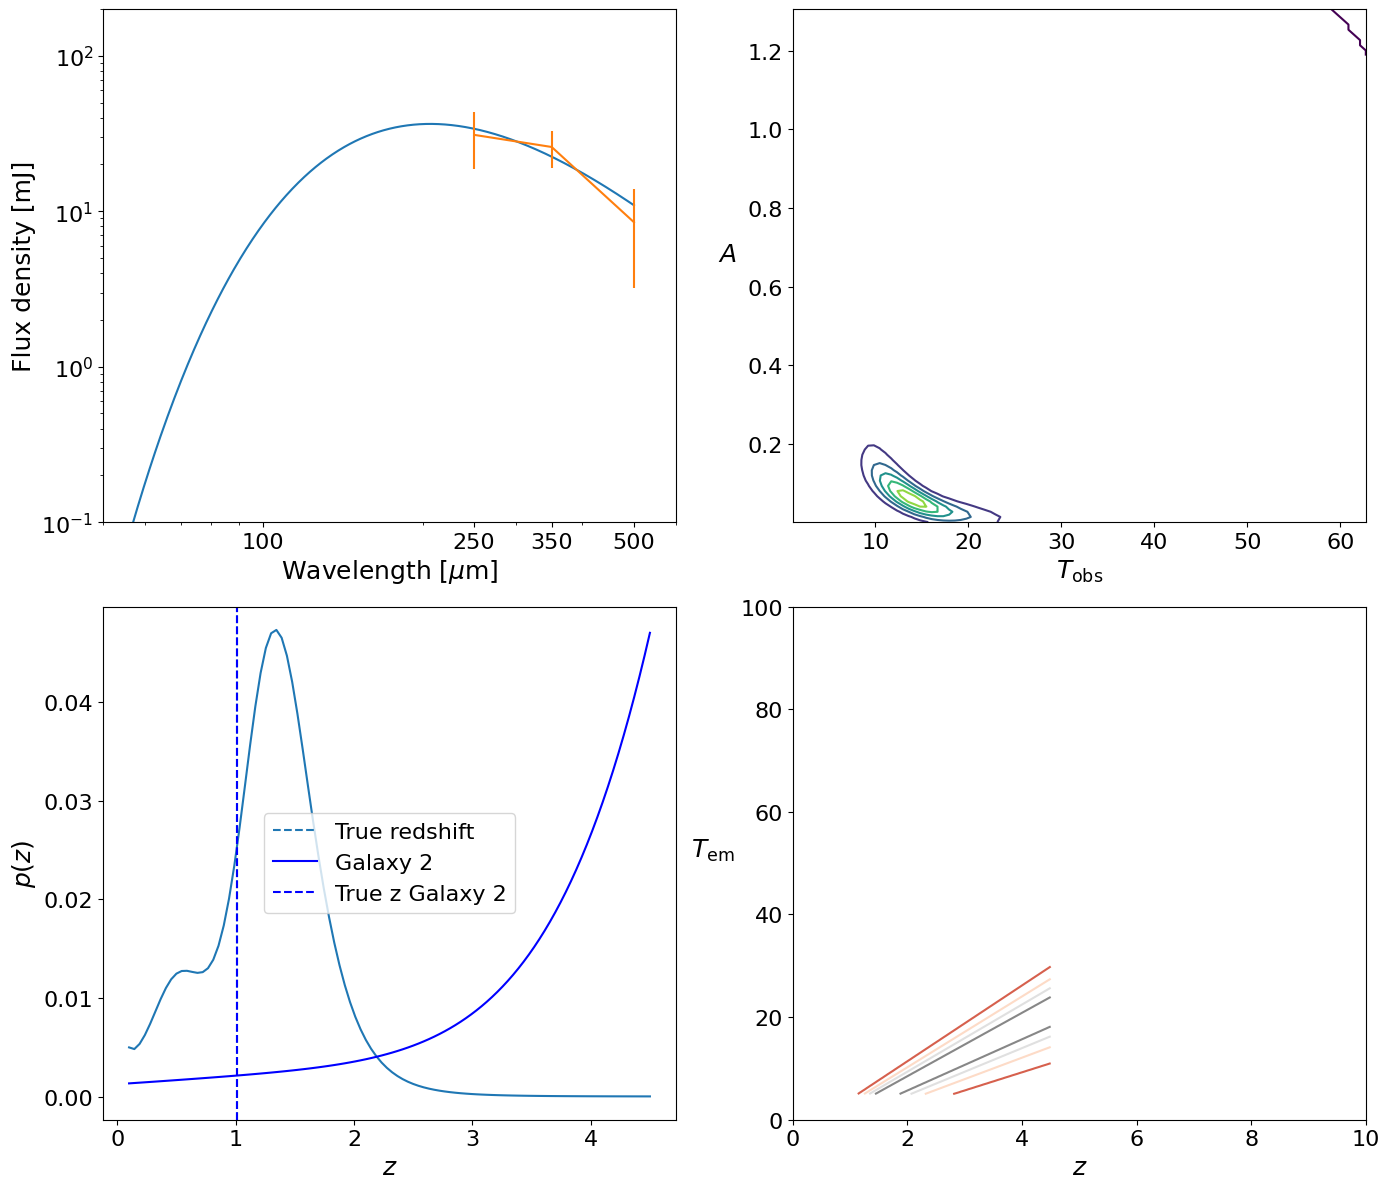

----------------------------------------------------------
GALAXY ID =  3
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [67.37861256 63.99471197]


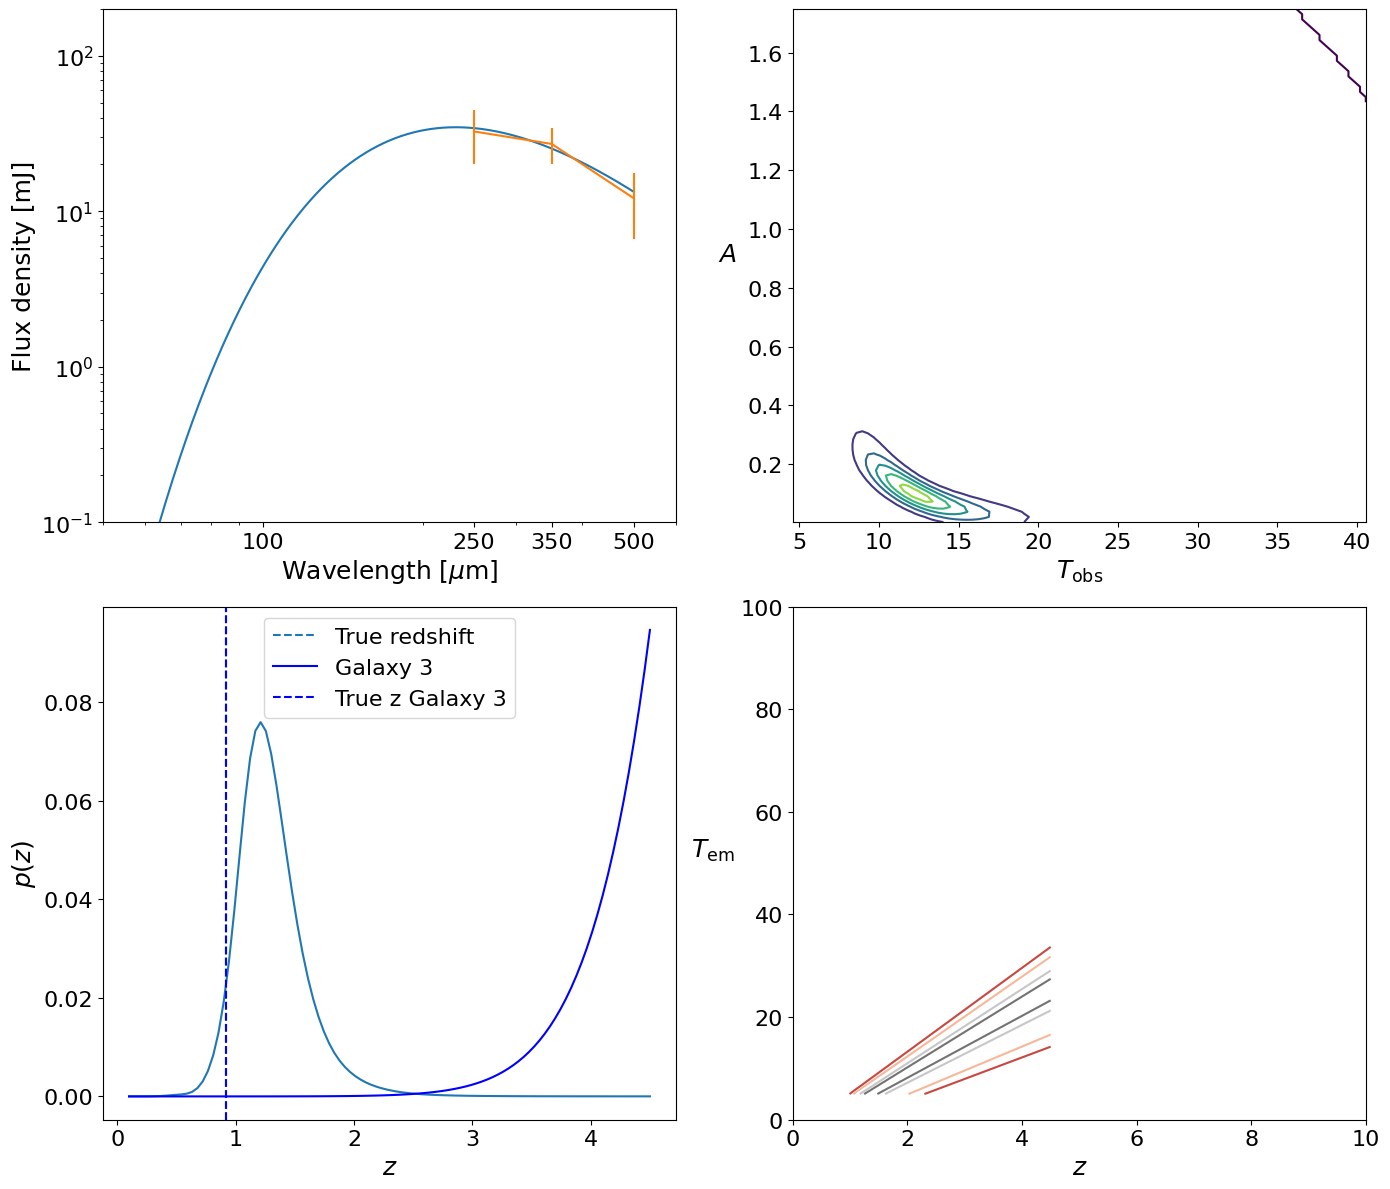

----------------------------------------------------------
GALAXY ID =  4
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [108.30880682  89.42938286]


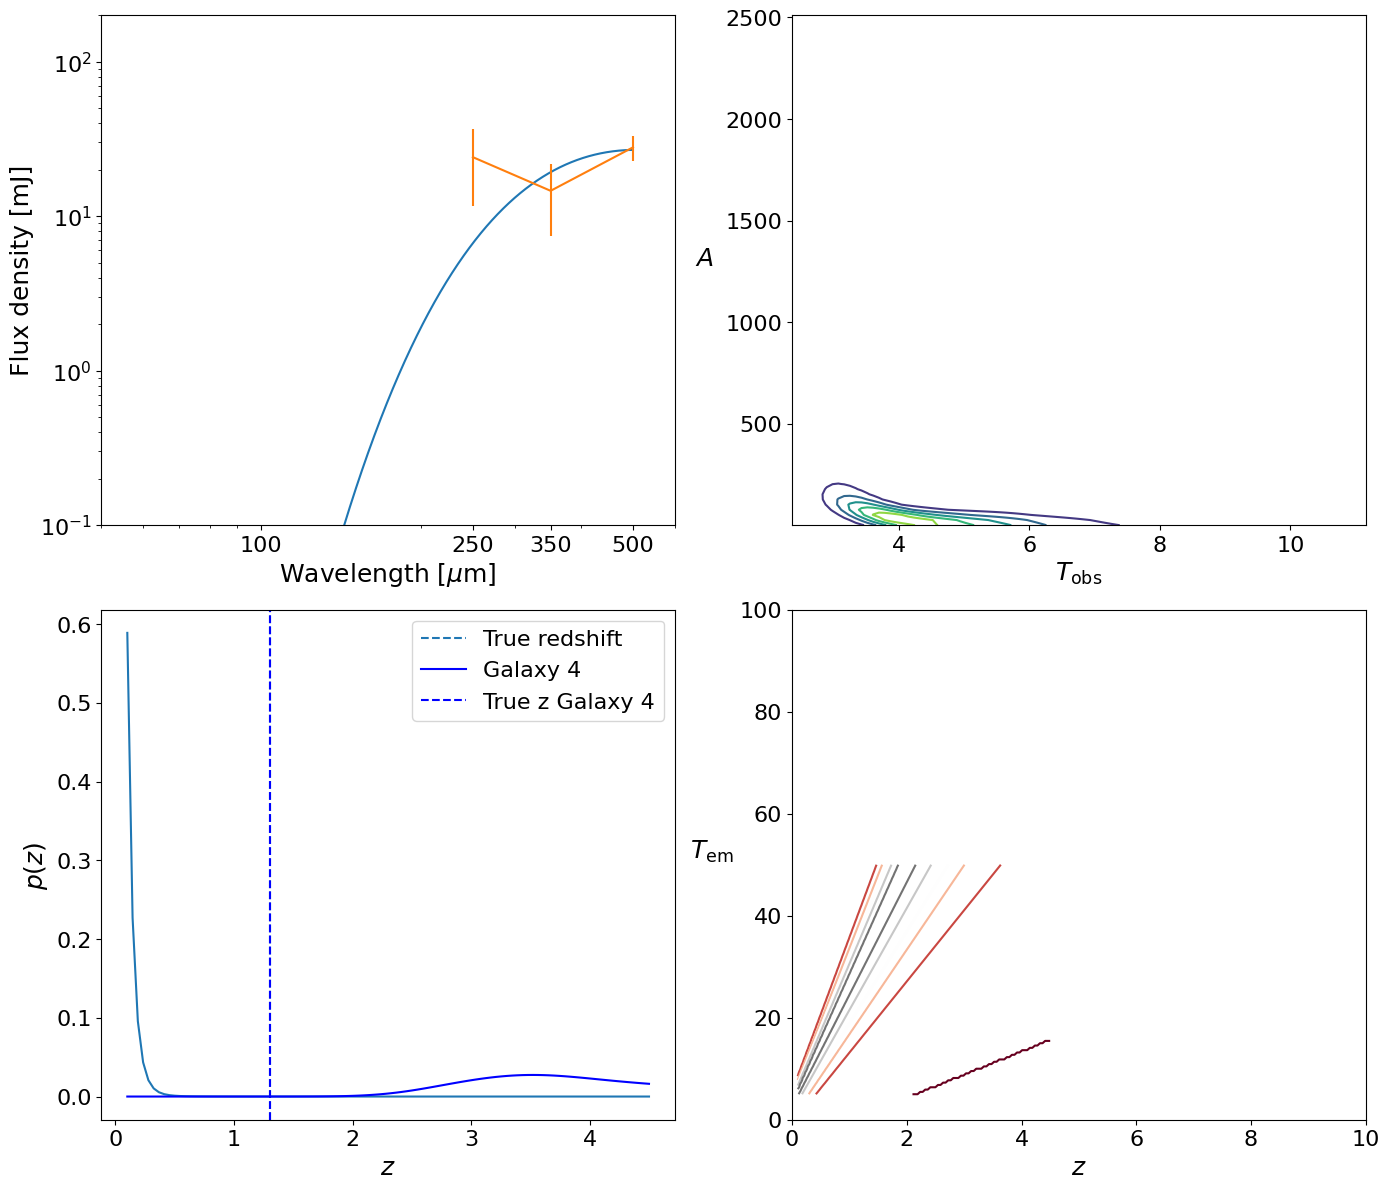

----------------------------------------------------------
GALAXY ID =  5
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [62.0434773  58.57837393]


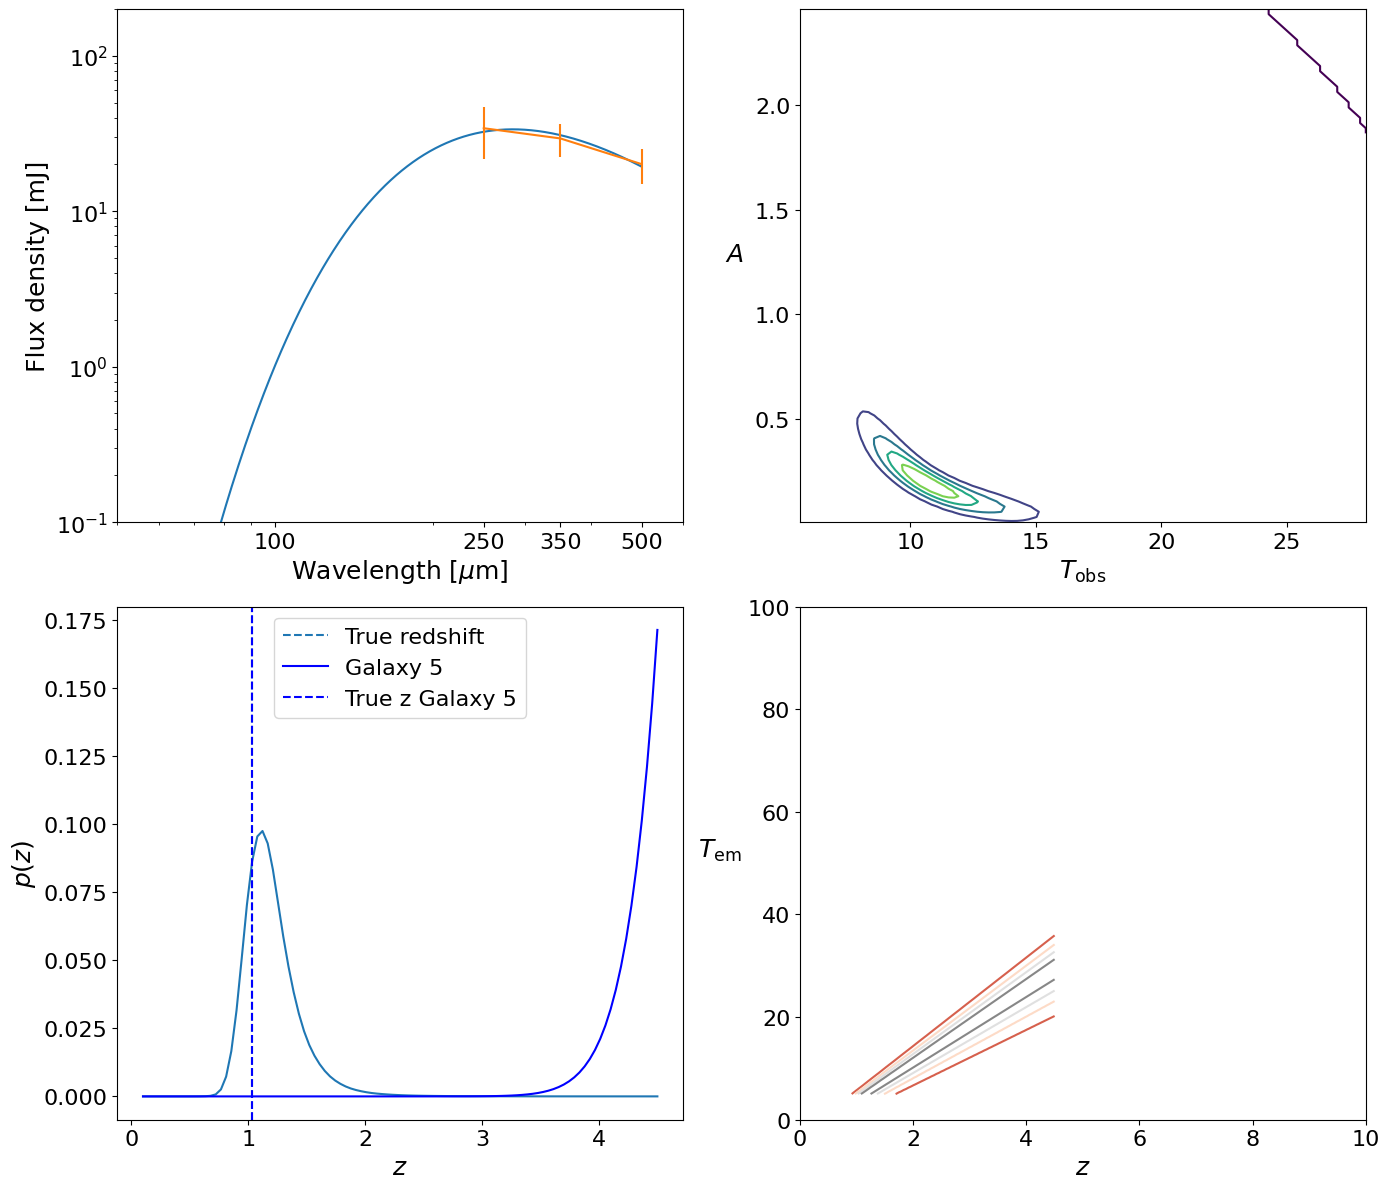

----------------------------------------------------------
GALAXY ID =  6
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [46.52526041 46.08179154]


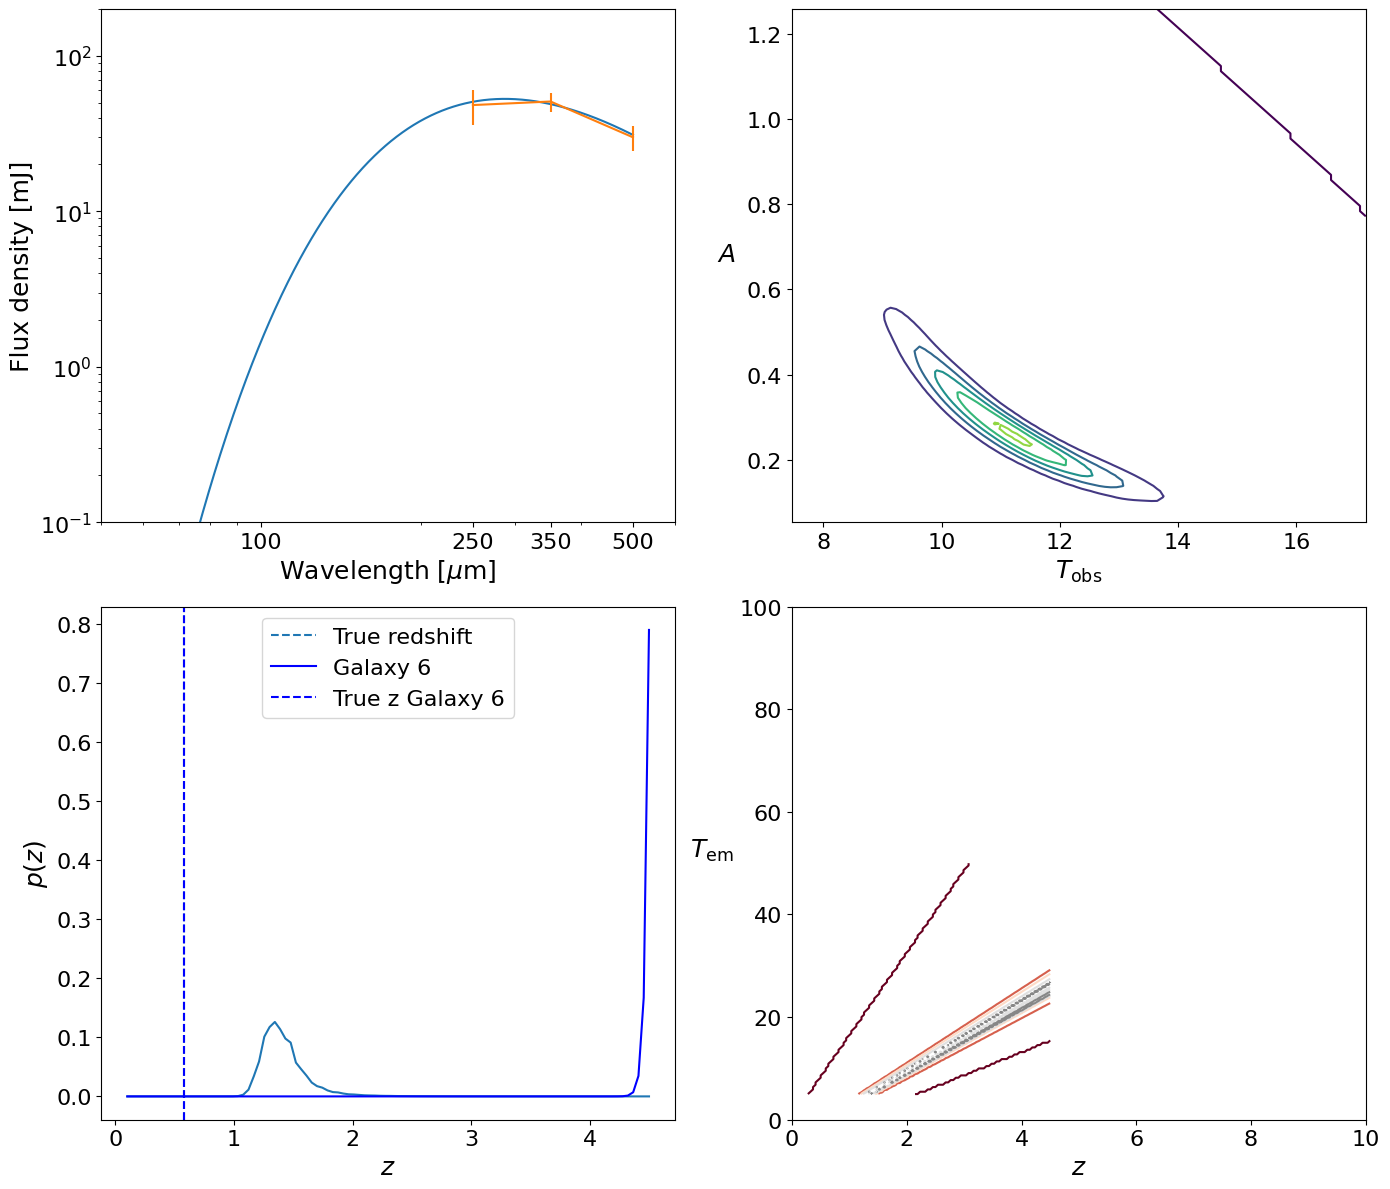

----------------------------------------------------------
GALAXY ID =  7
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [43.56133115 44.5996161 ]


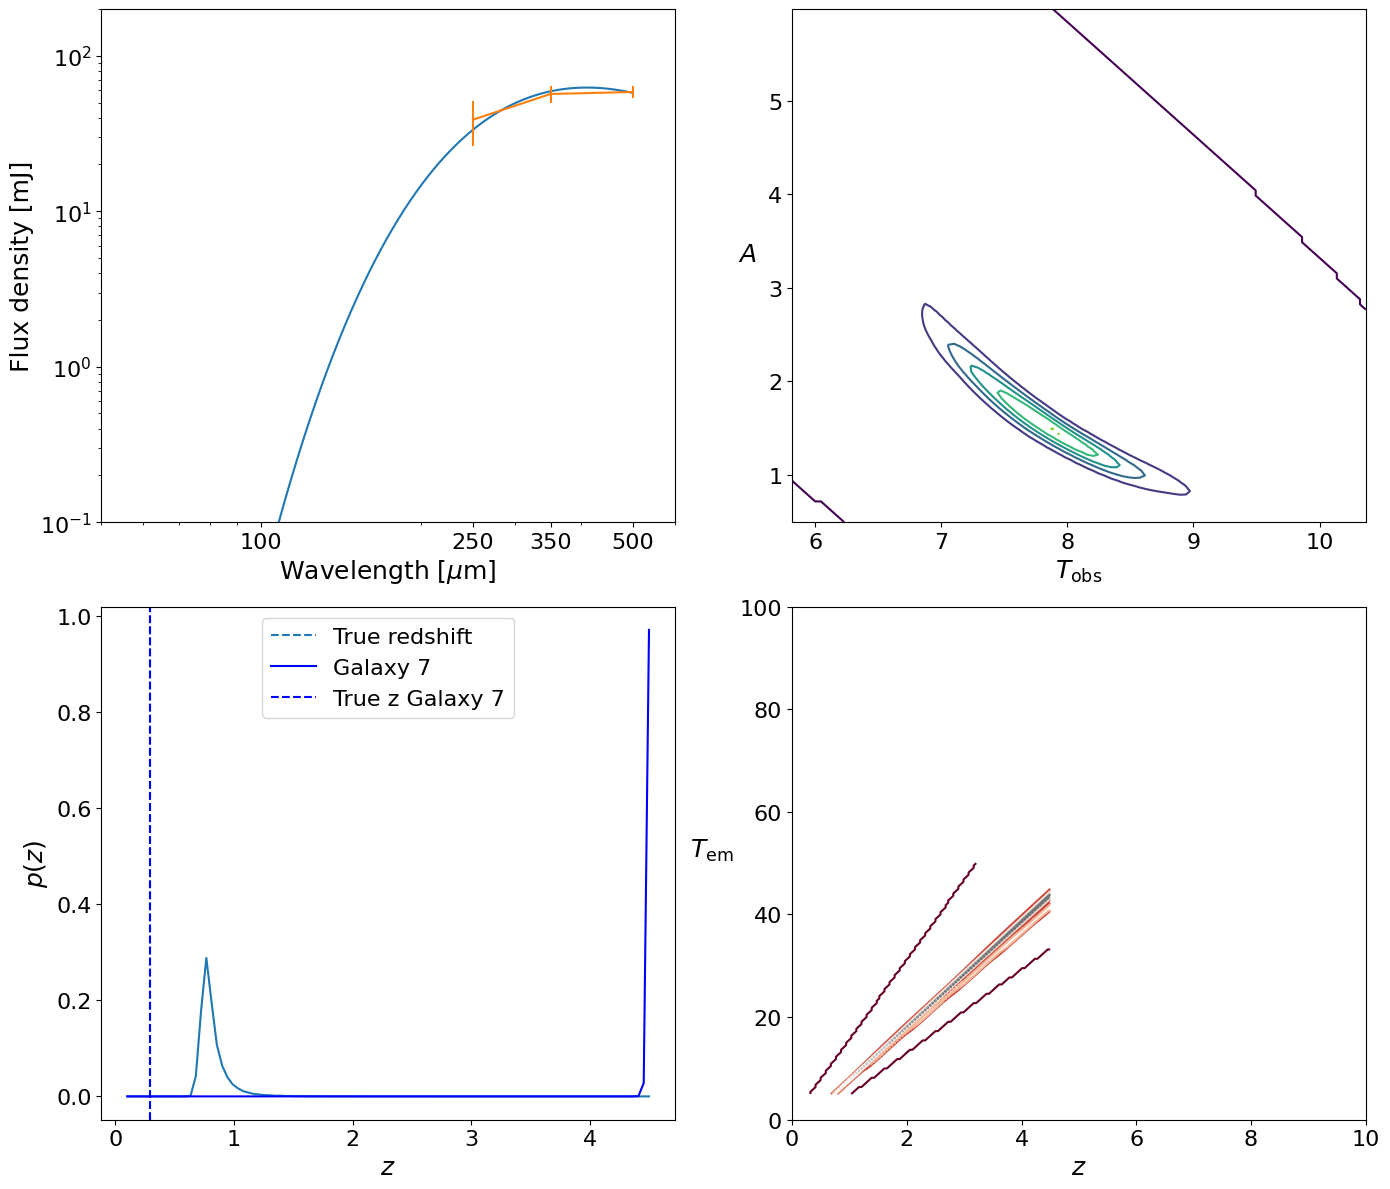

----------------------------------------------------------
GALAXY ID =  8
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [106.72738643  95.53476321]


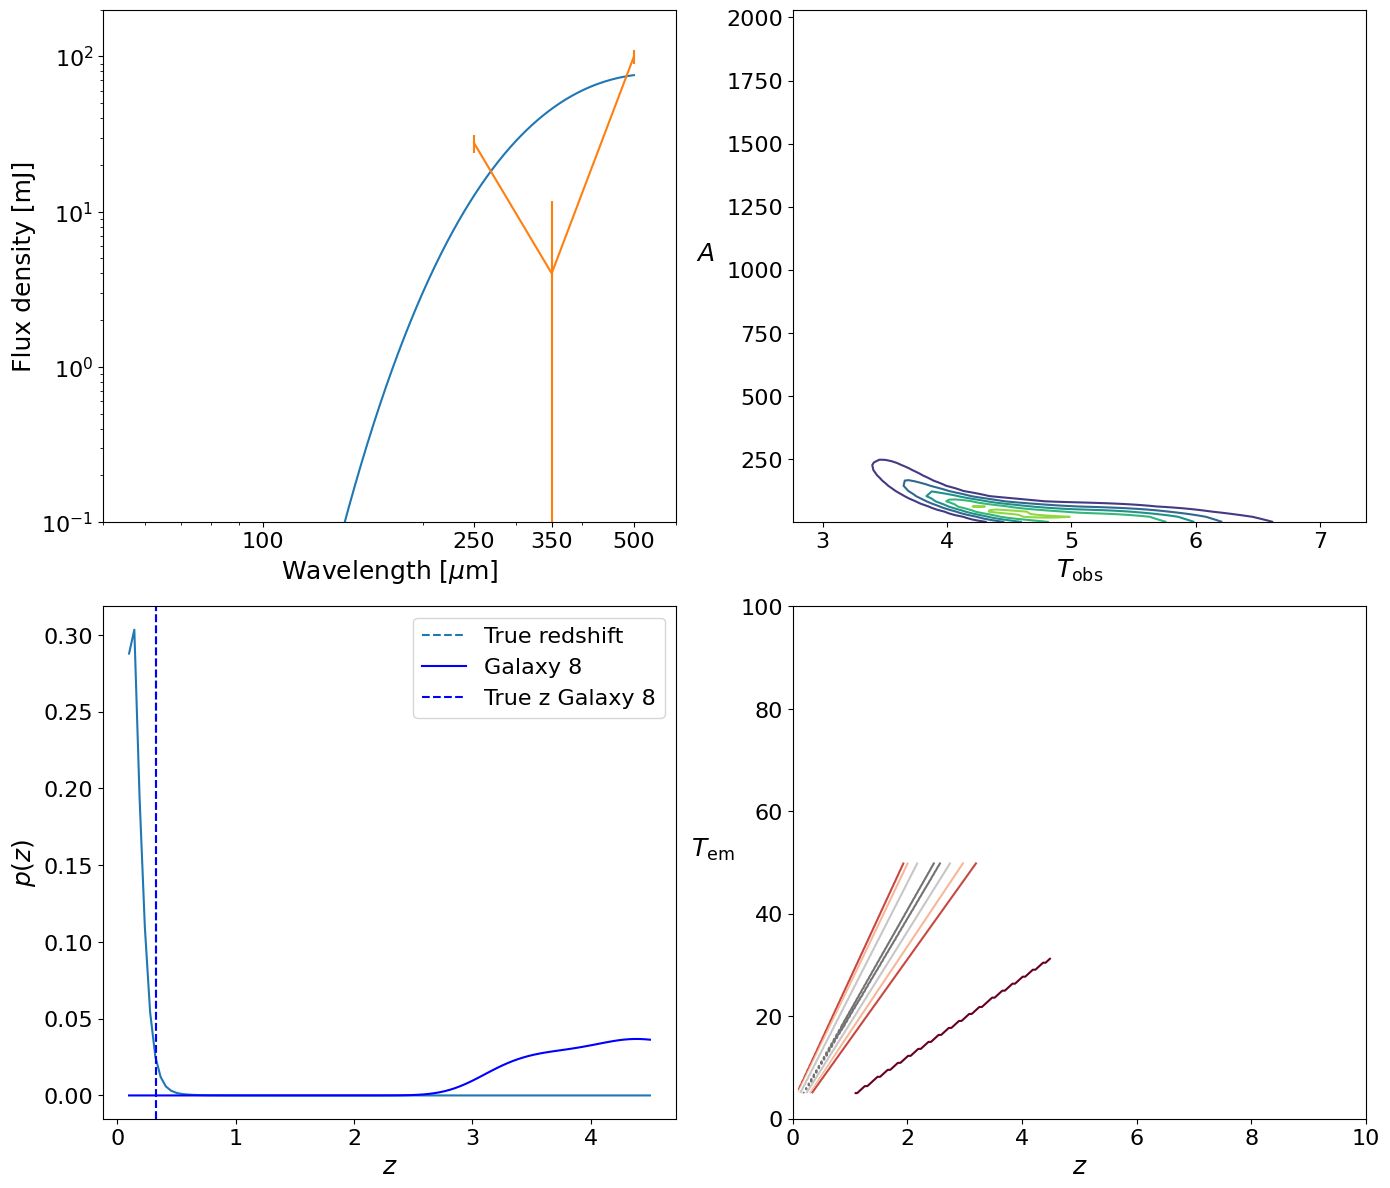

----------------------------------------------------------
GALAXY ID =  9
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [120.6999761 105.7774225]


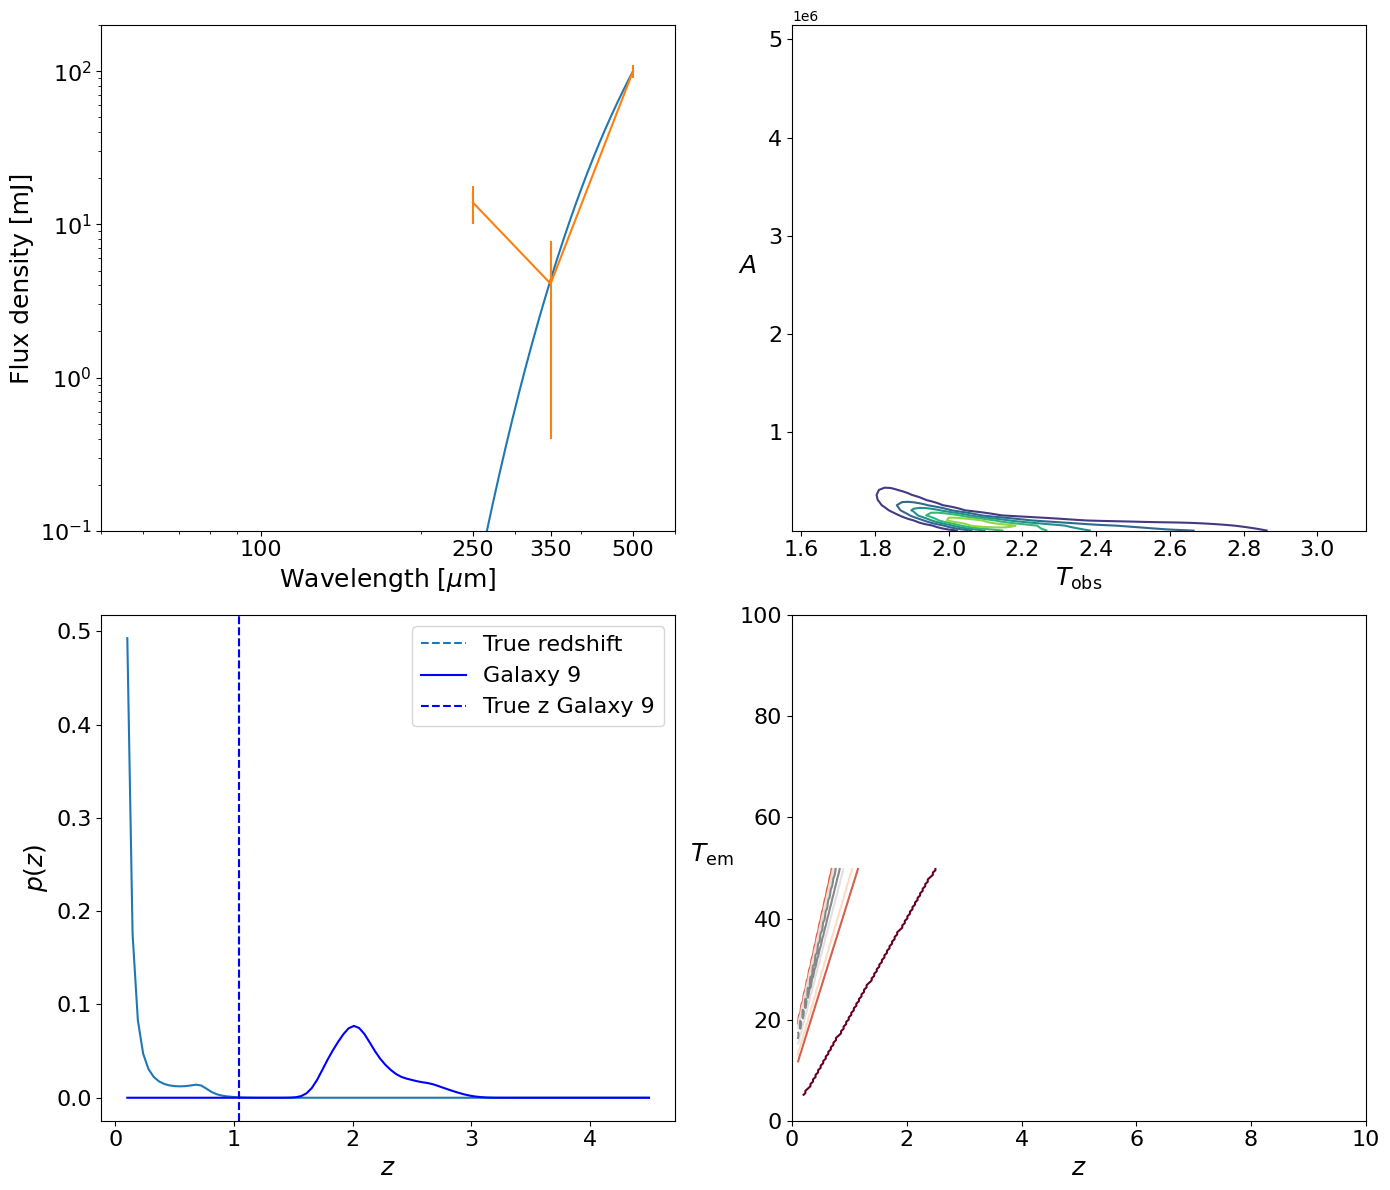

----------------------------------------------------------
GALAXY ID =  10
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [59.4449987  58.65772698]


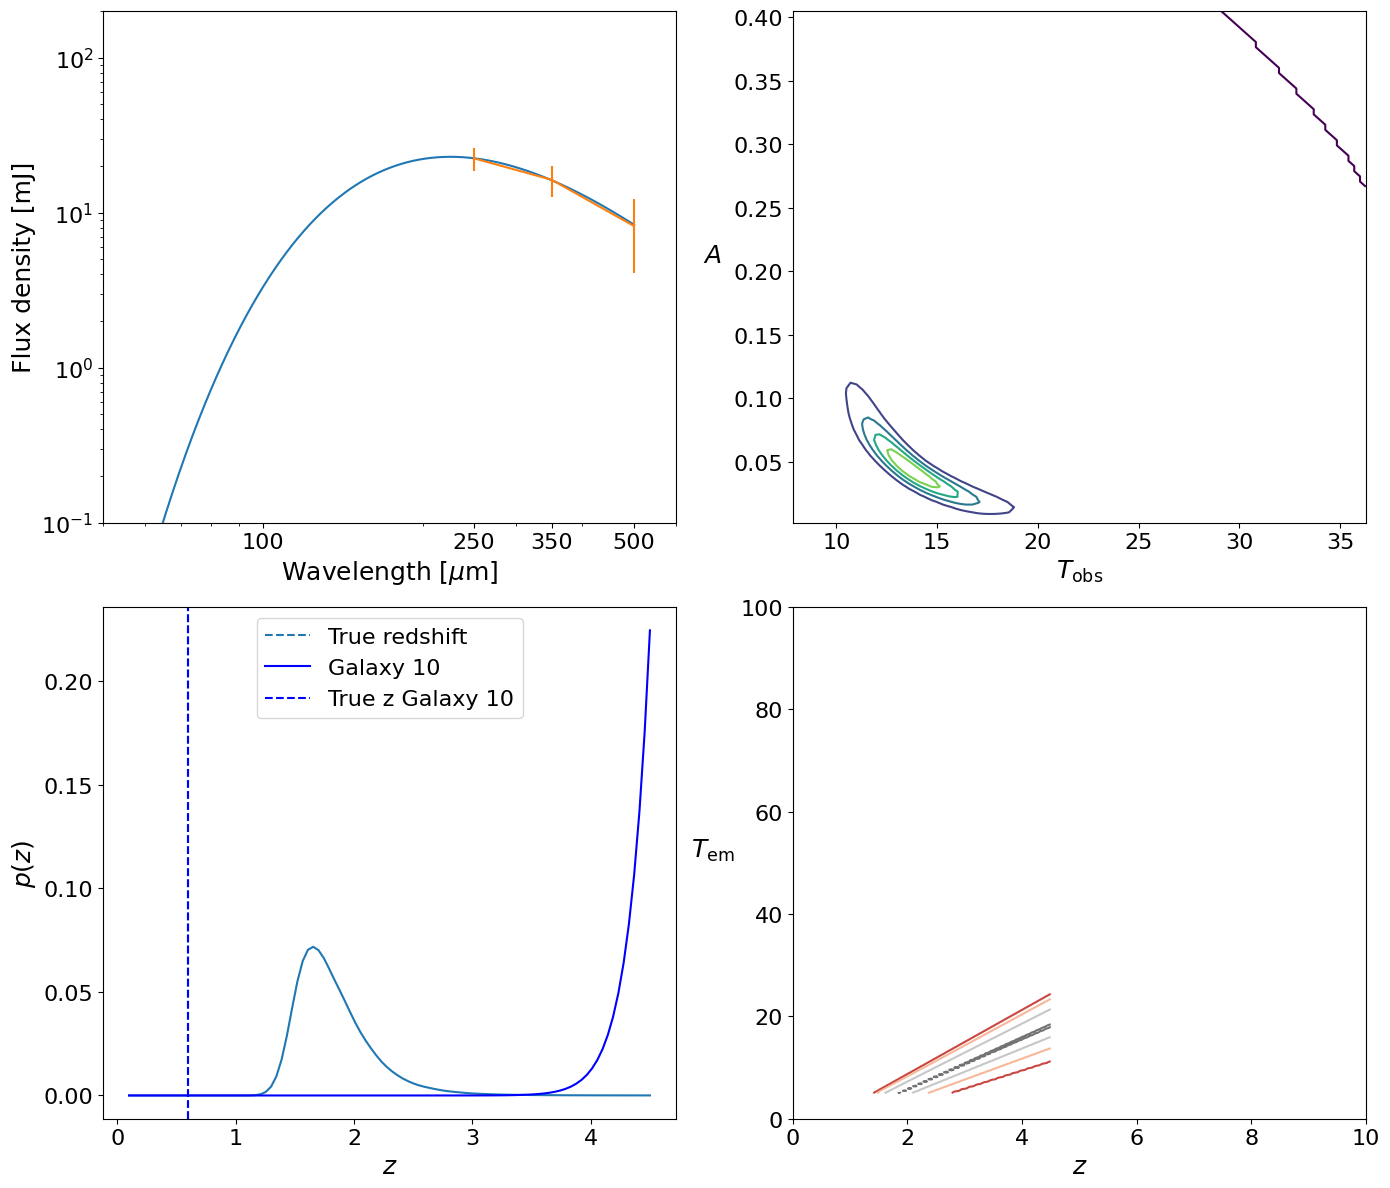

----------------------------------------------------------
GALAXY ID =  11
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [56.38321653 53.96302826]


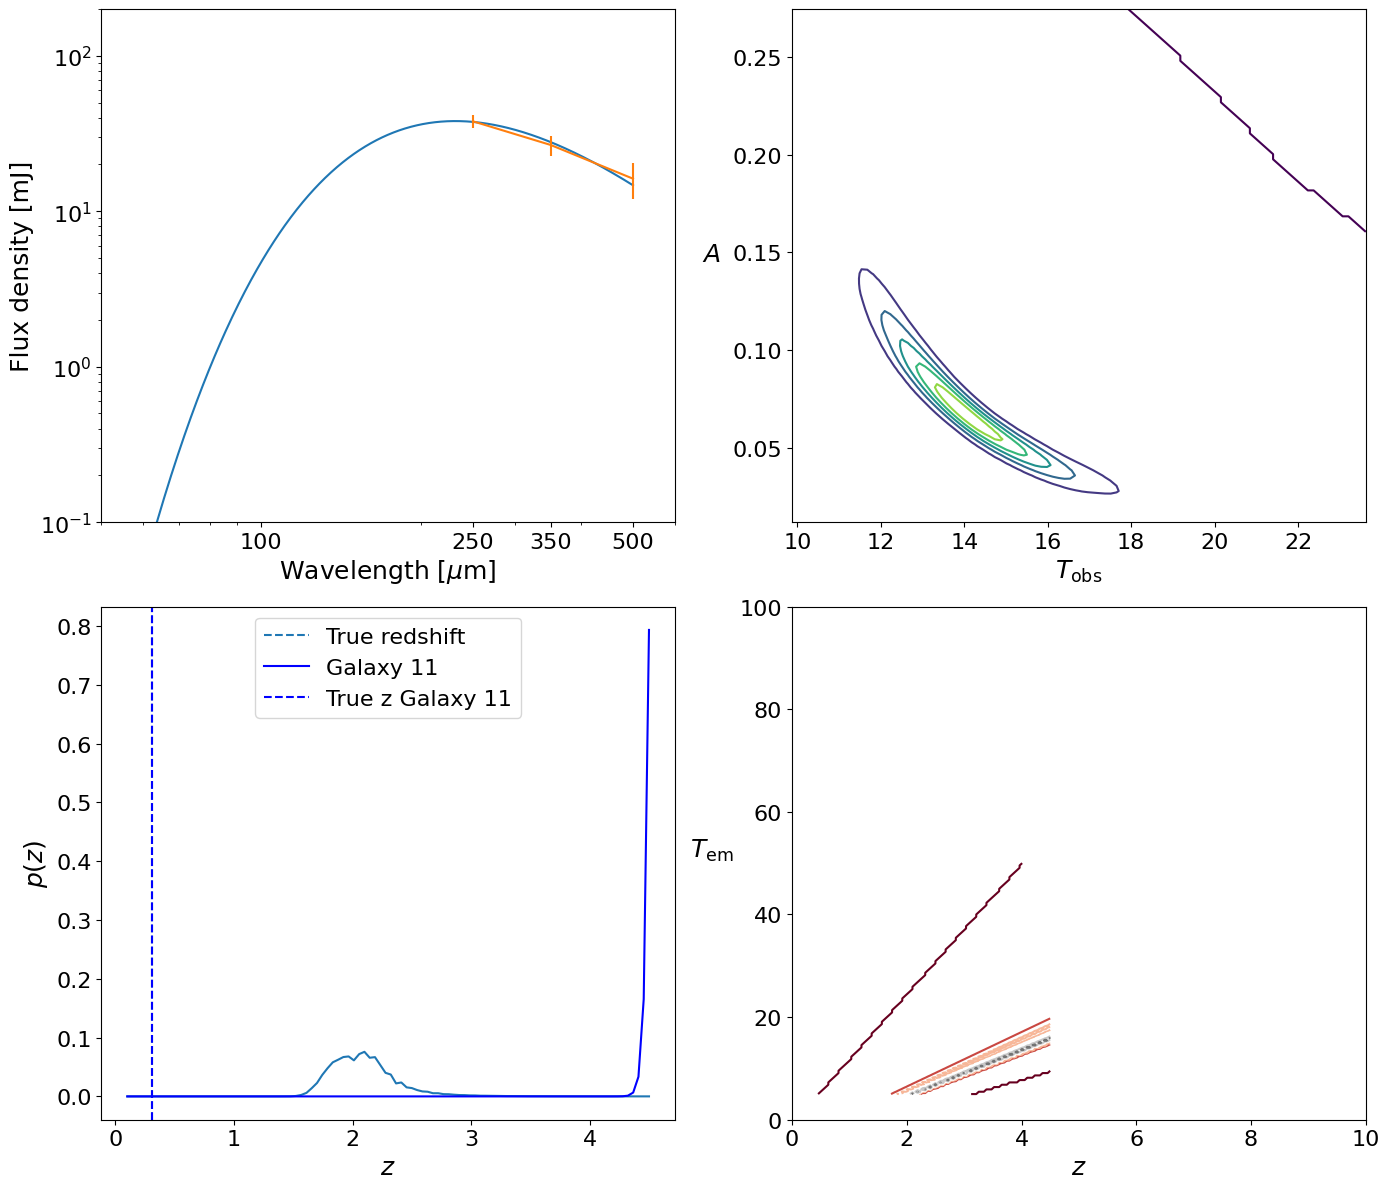

----------------------------------------------------------
GALAXY ID =  12
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [64.01685643 61.10624376]


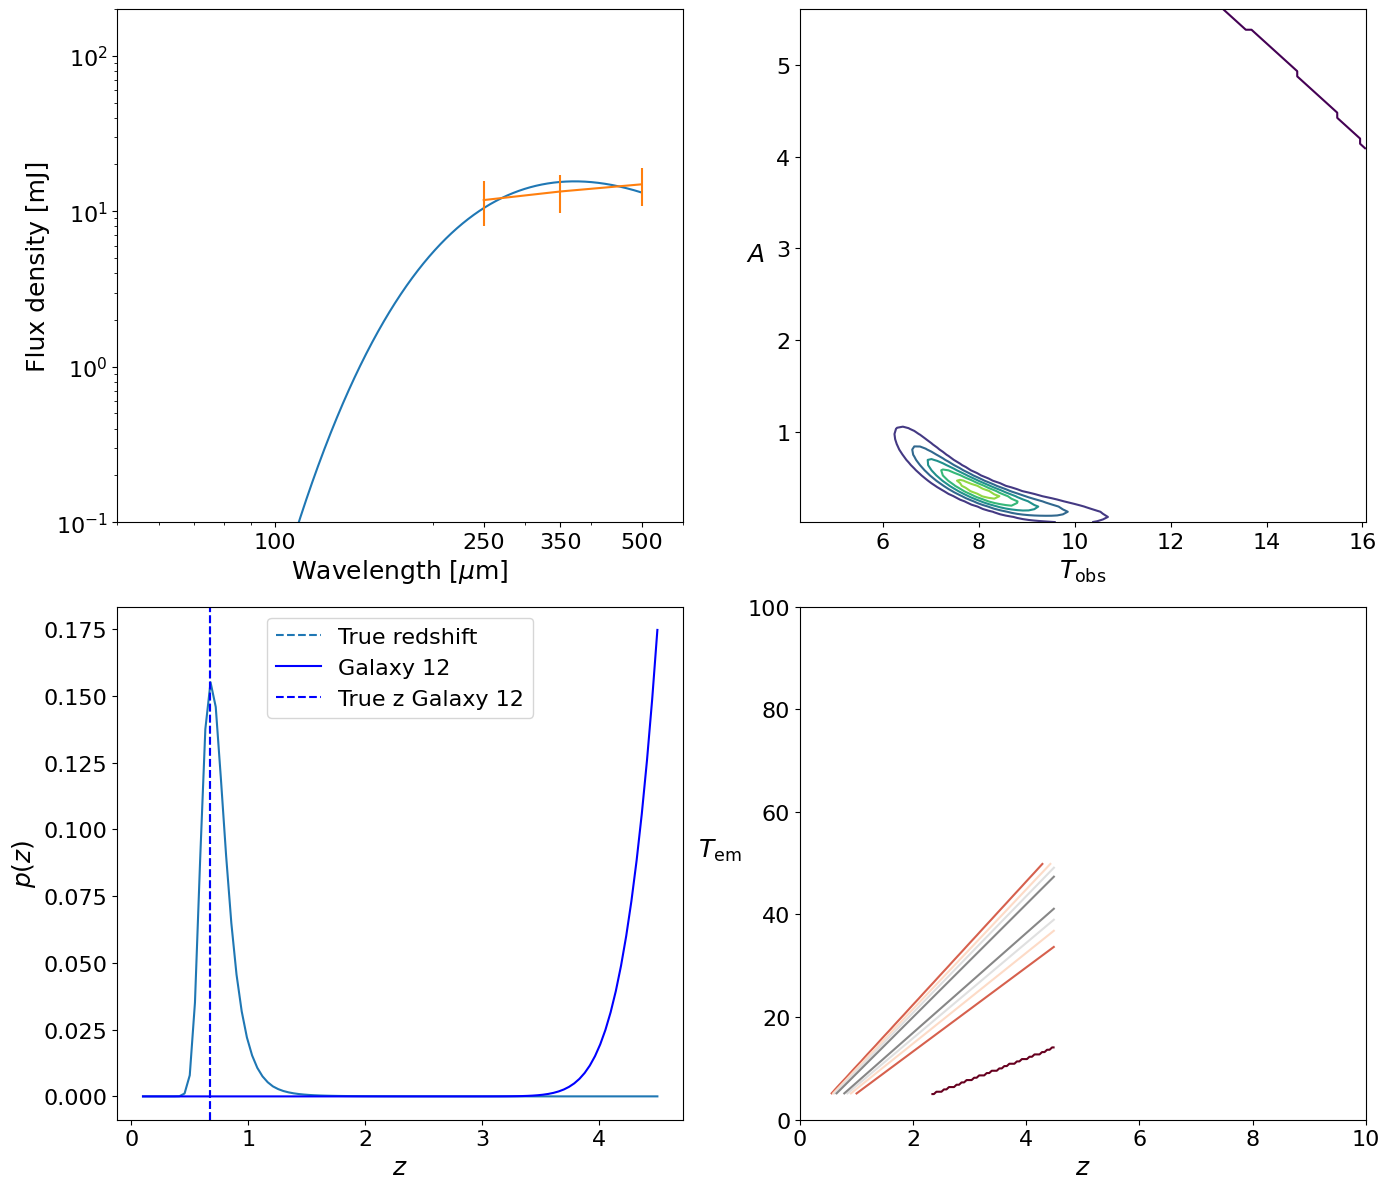

----------------------------------------------------------
GALAXY ID =  13
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [66.87551202 62.24407137]


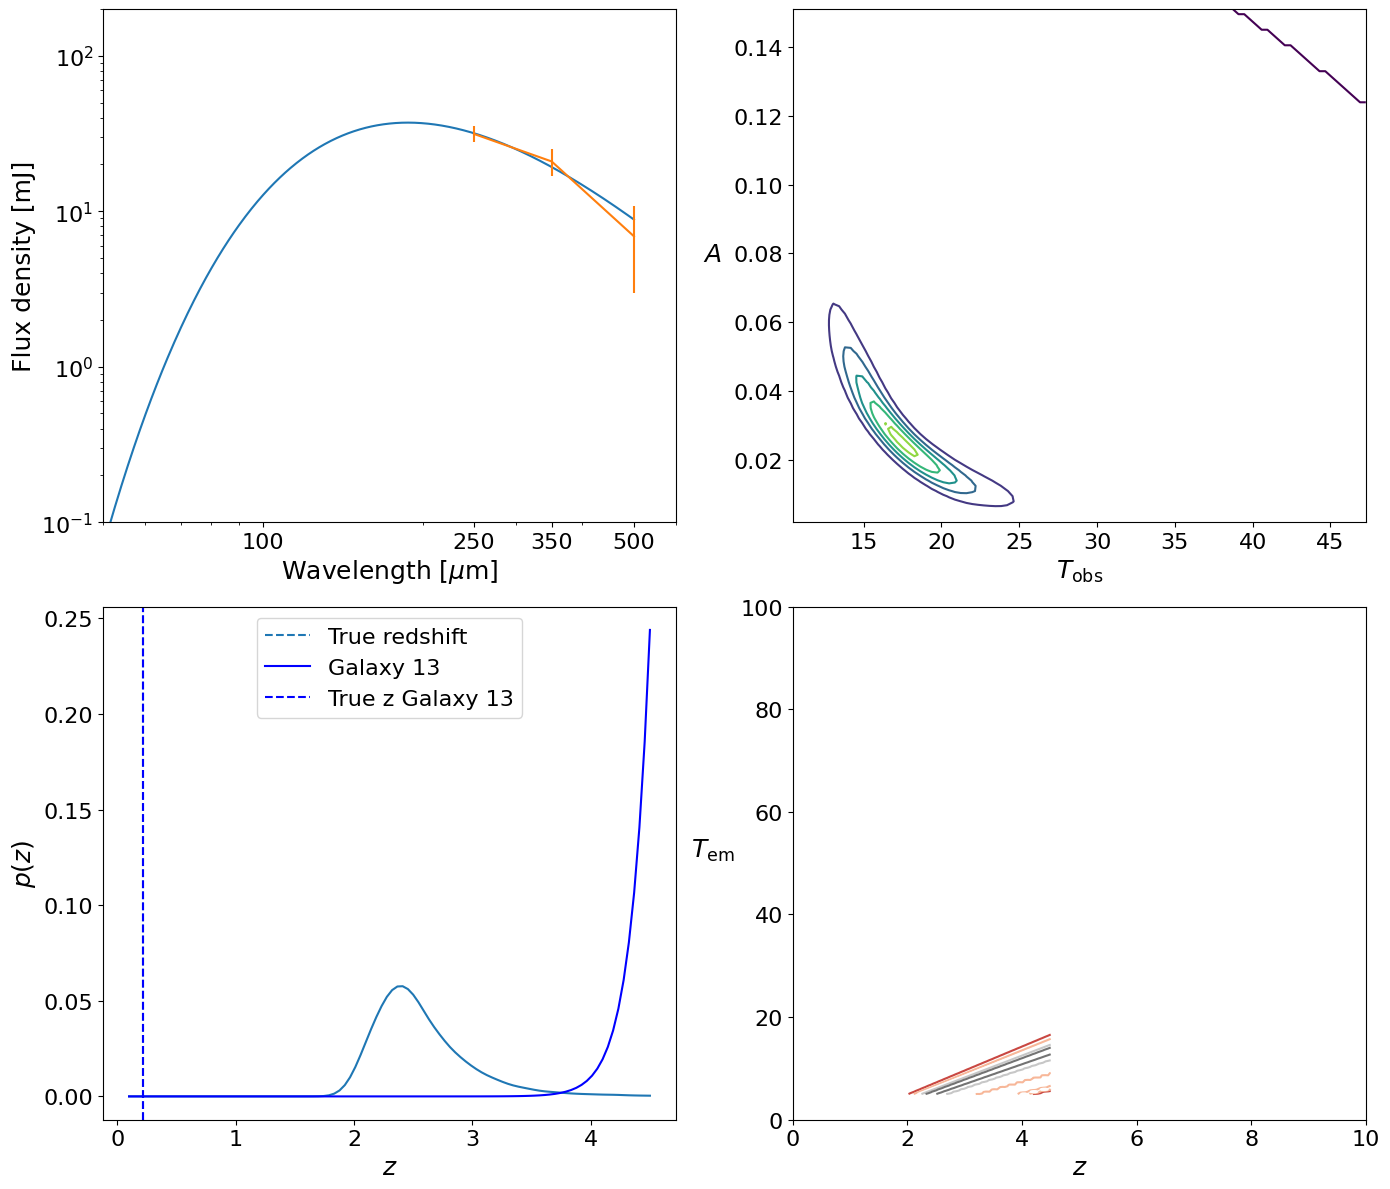

----------------------------------------------------------
GALAXY ID =  14
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [114.81487561 102.17555528]


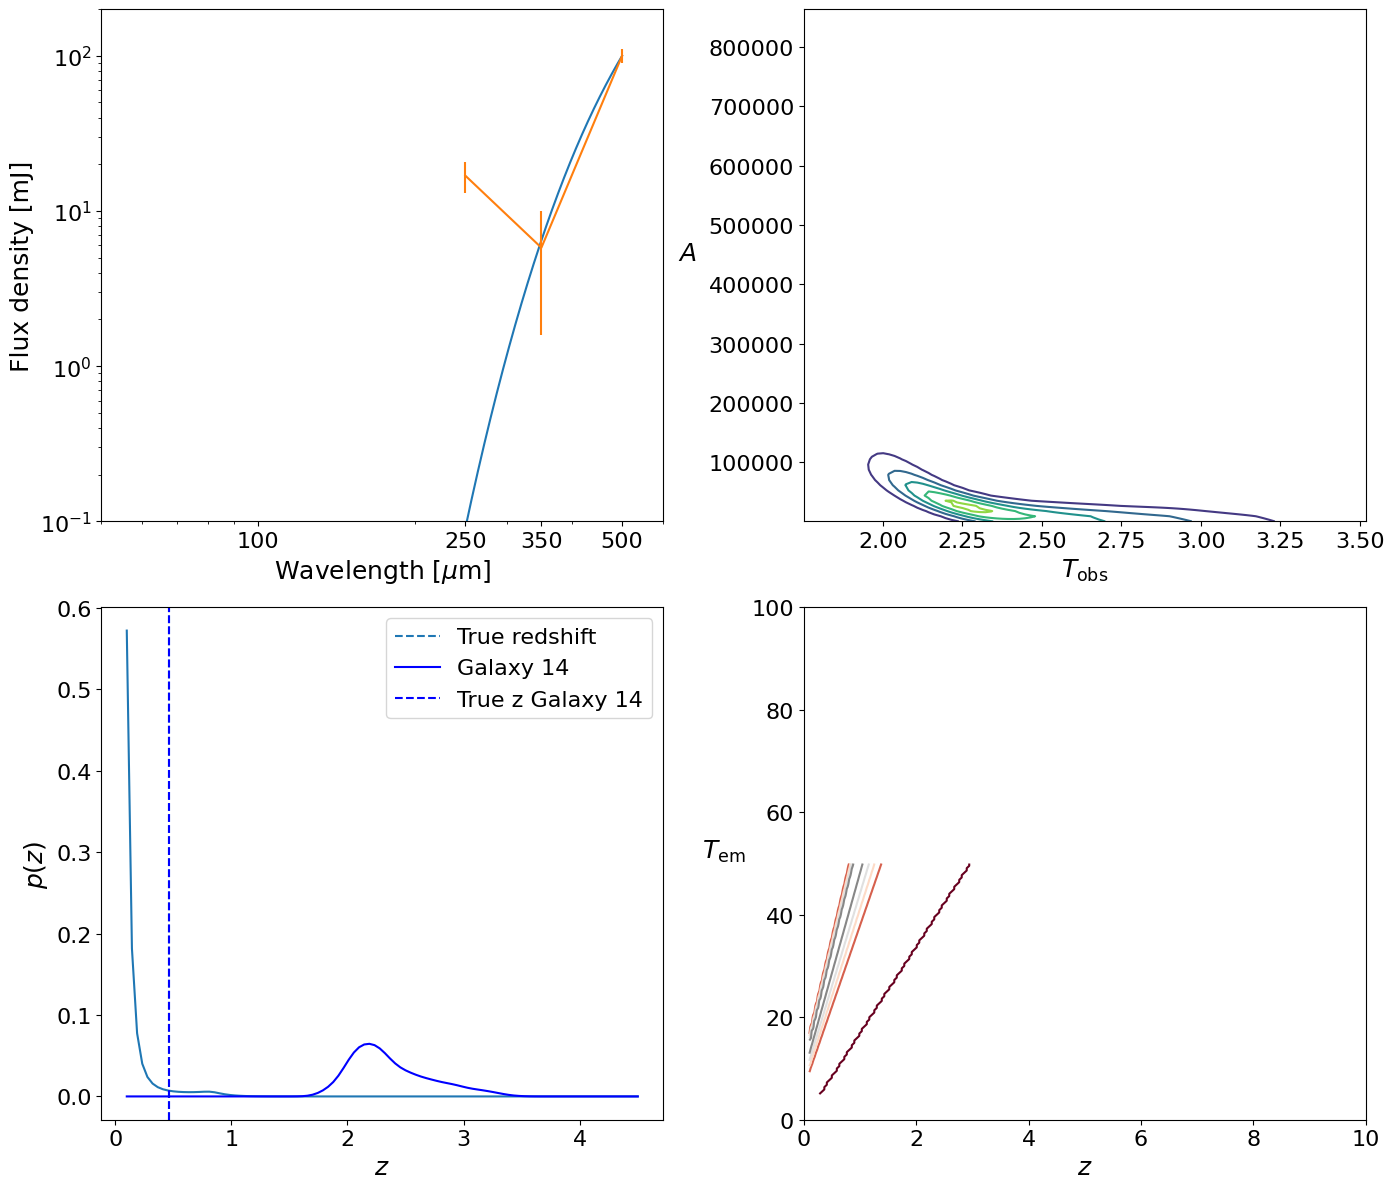

----------------------------------------------------------
GALAXY ID =  15
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [115.36554542 100.12262154]


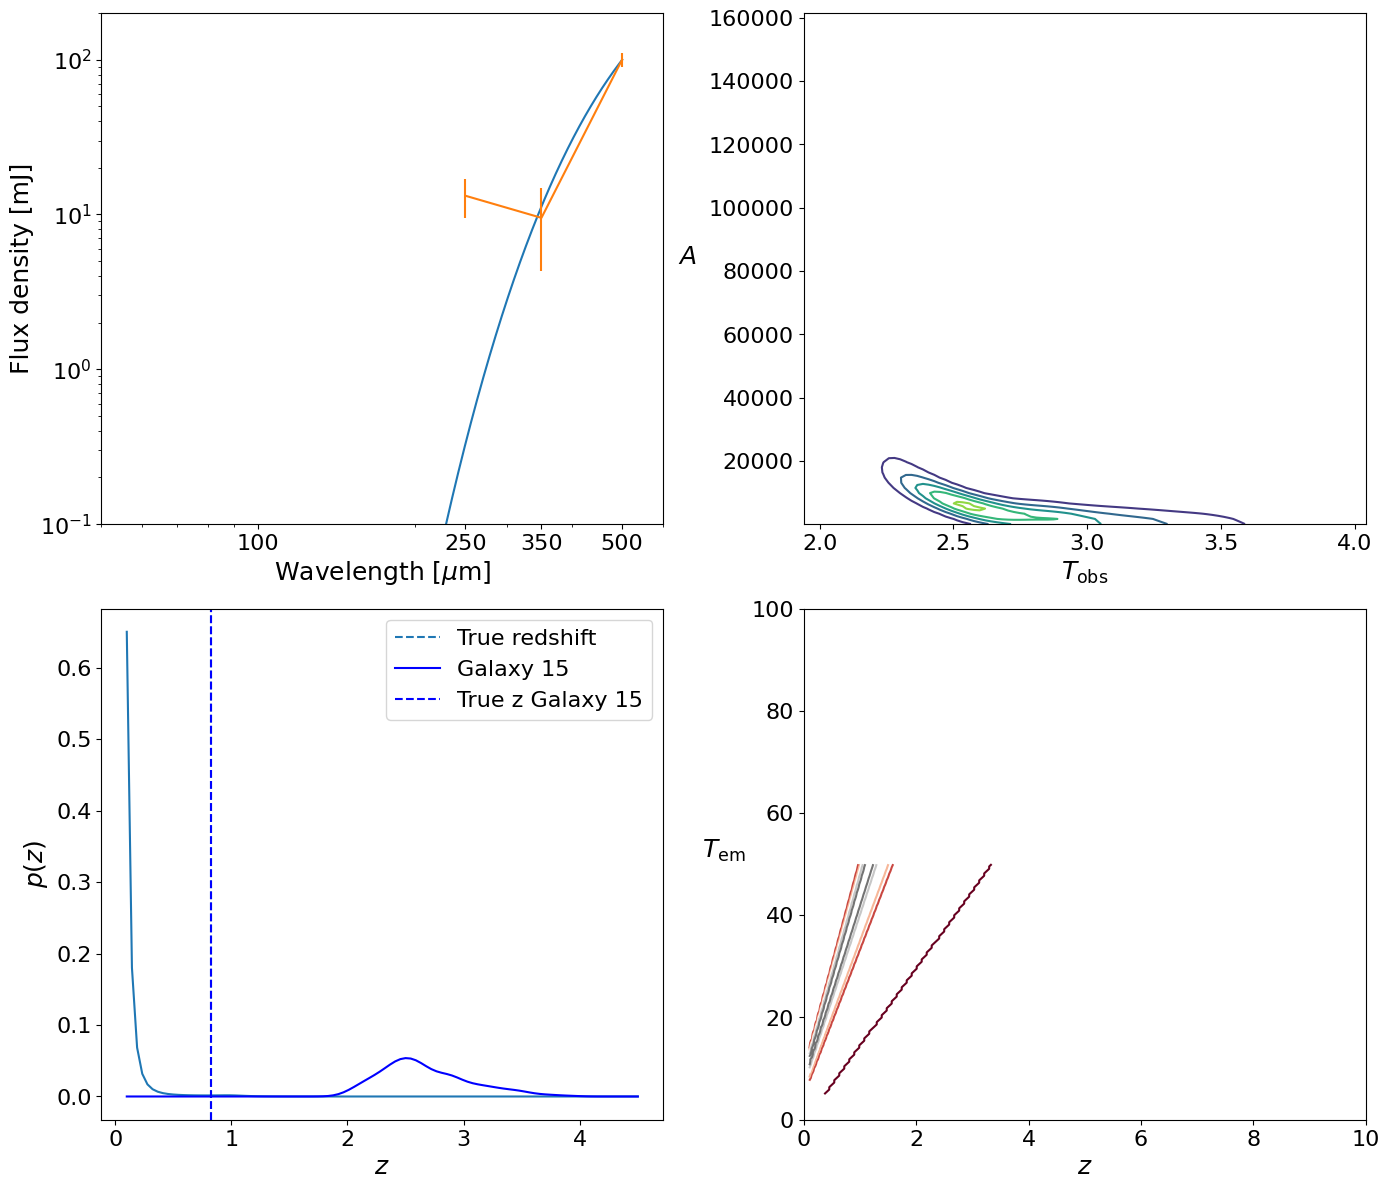

----------------------------------------------------------
GALAXY ID =  16
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.66008965 49.11297187]


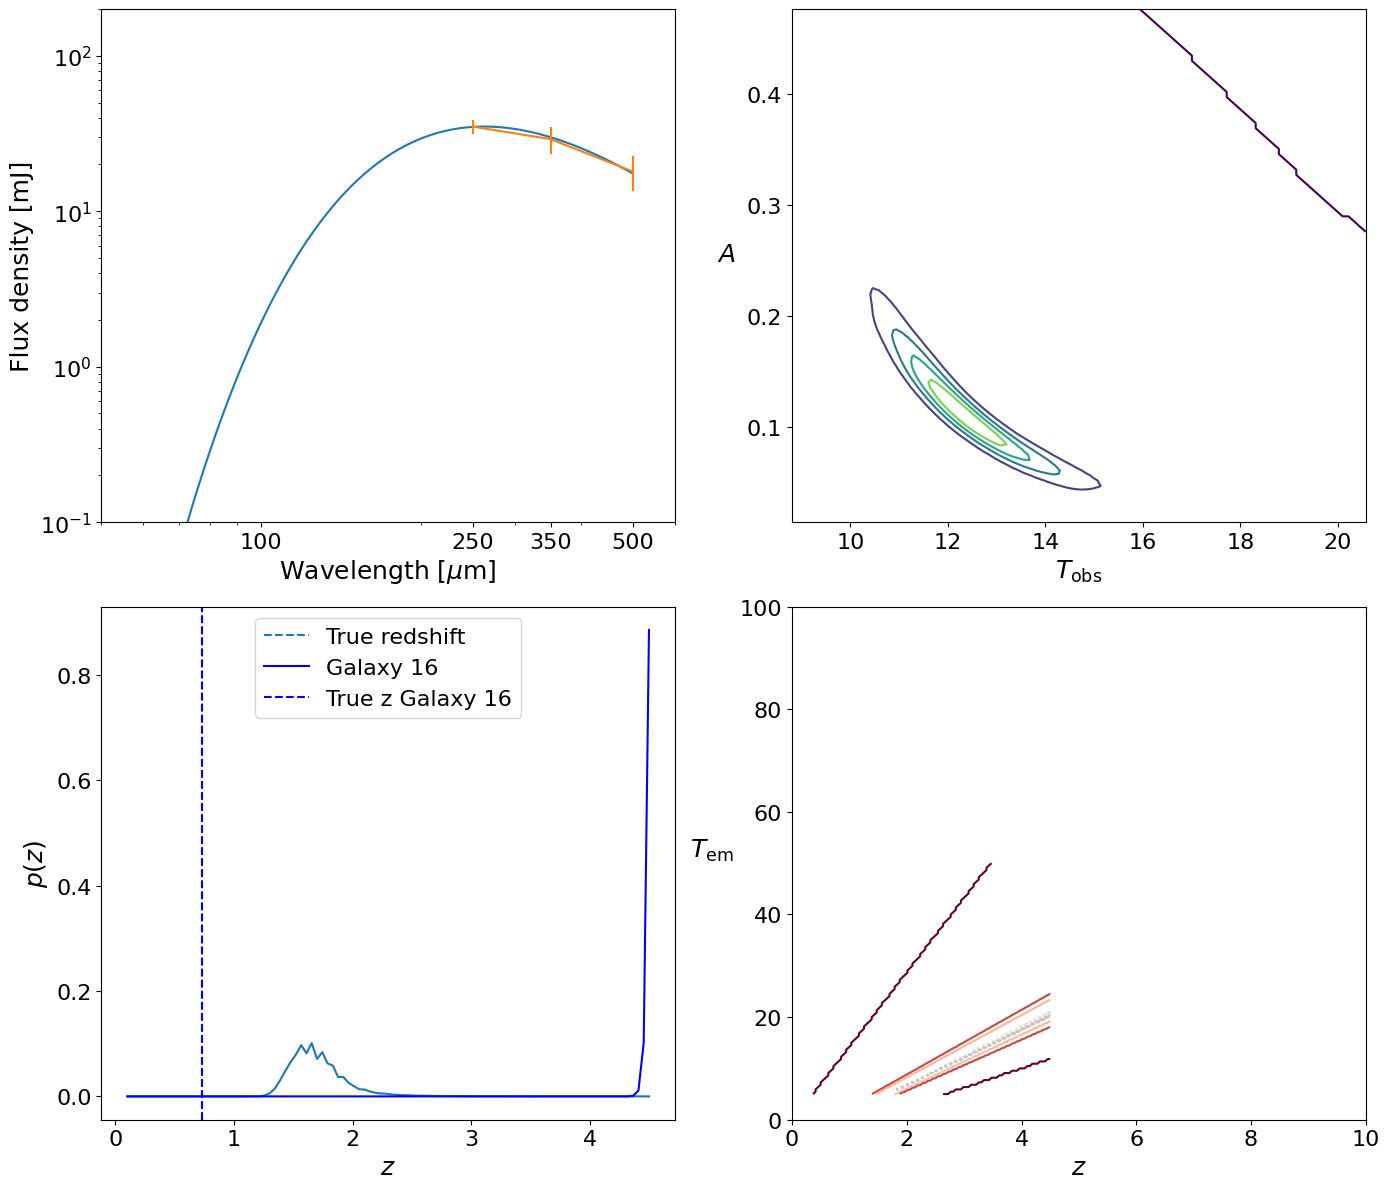

----------------------------------------------------------
GALAXY ID =  17
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [62.81737697 60.09029344]


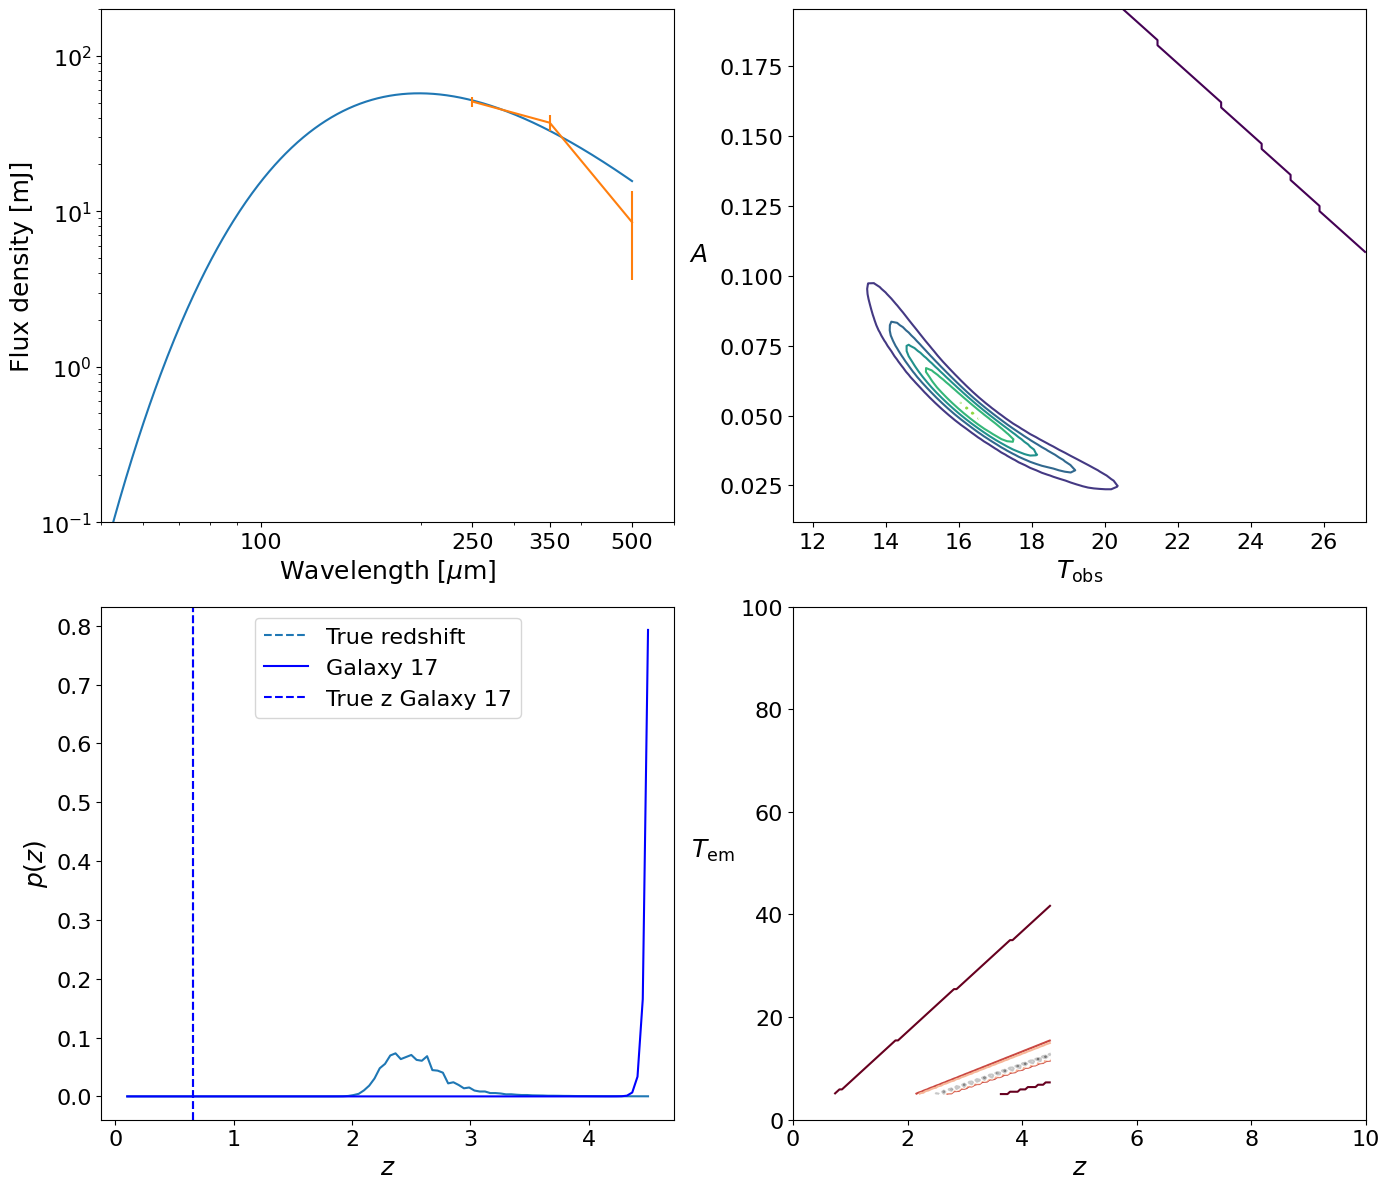

----------------------------------------------------------
GALAXY ID =  18
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [85.82462632 81.03452898]


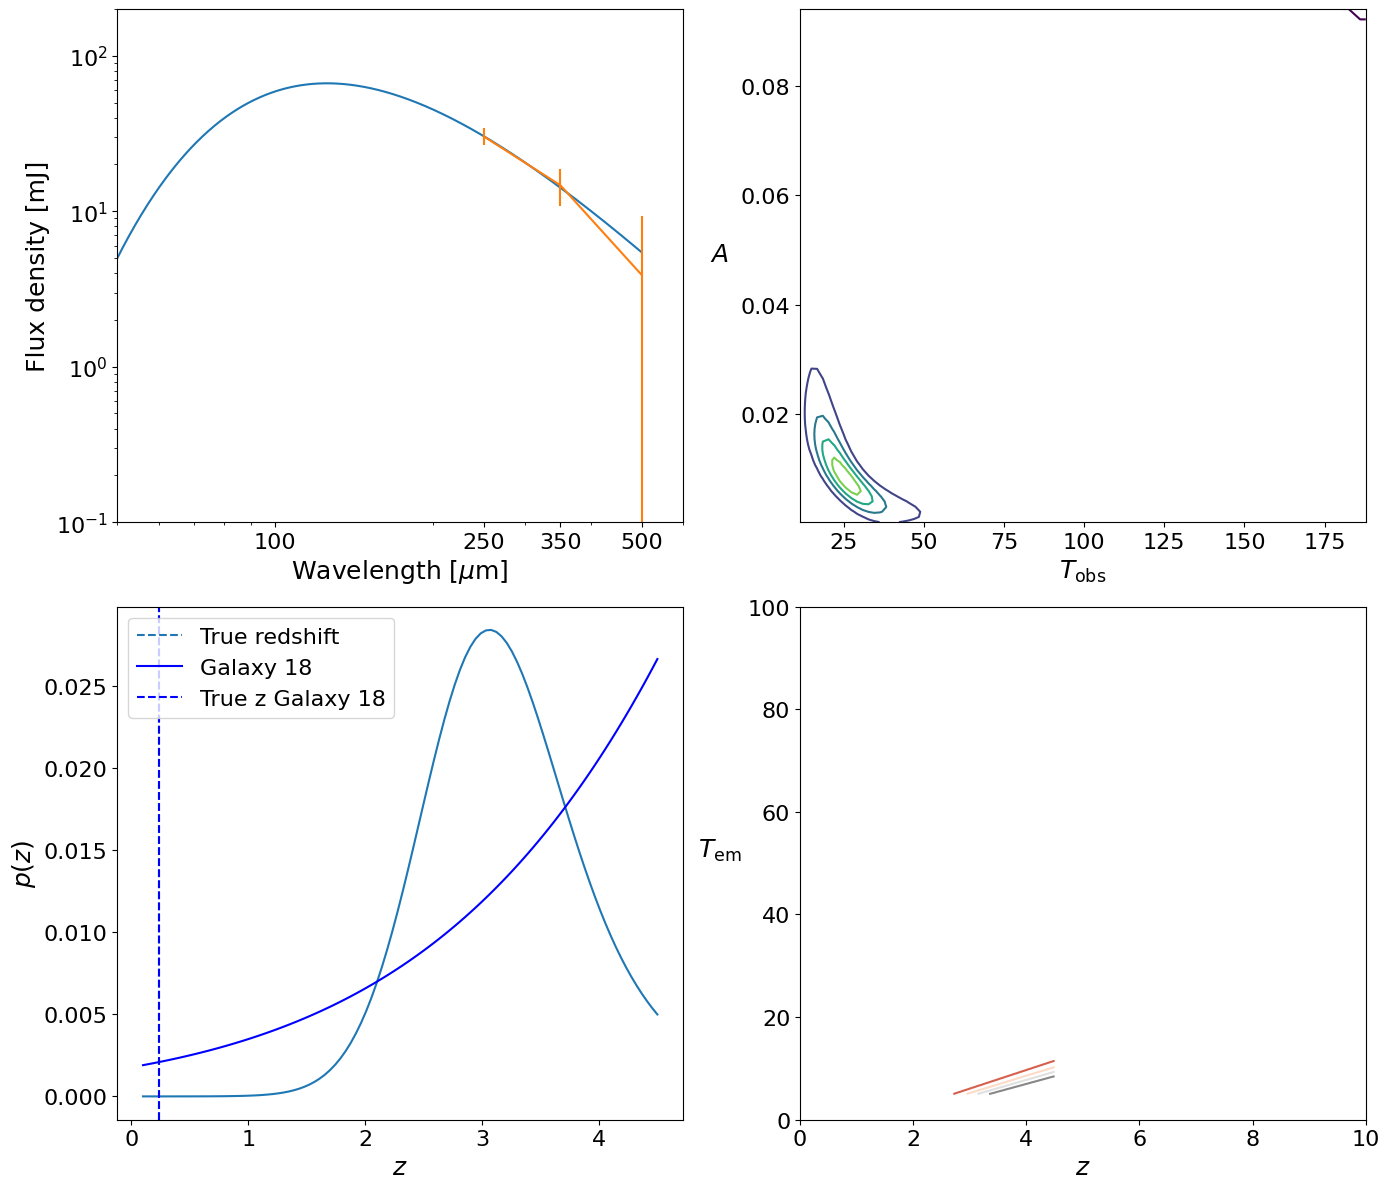

----------------------------------------------------------
GALAXY ID =  19
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [98.03390482 90.00453131]


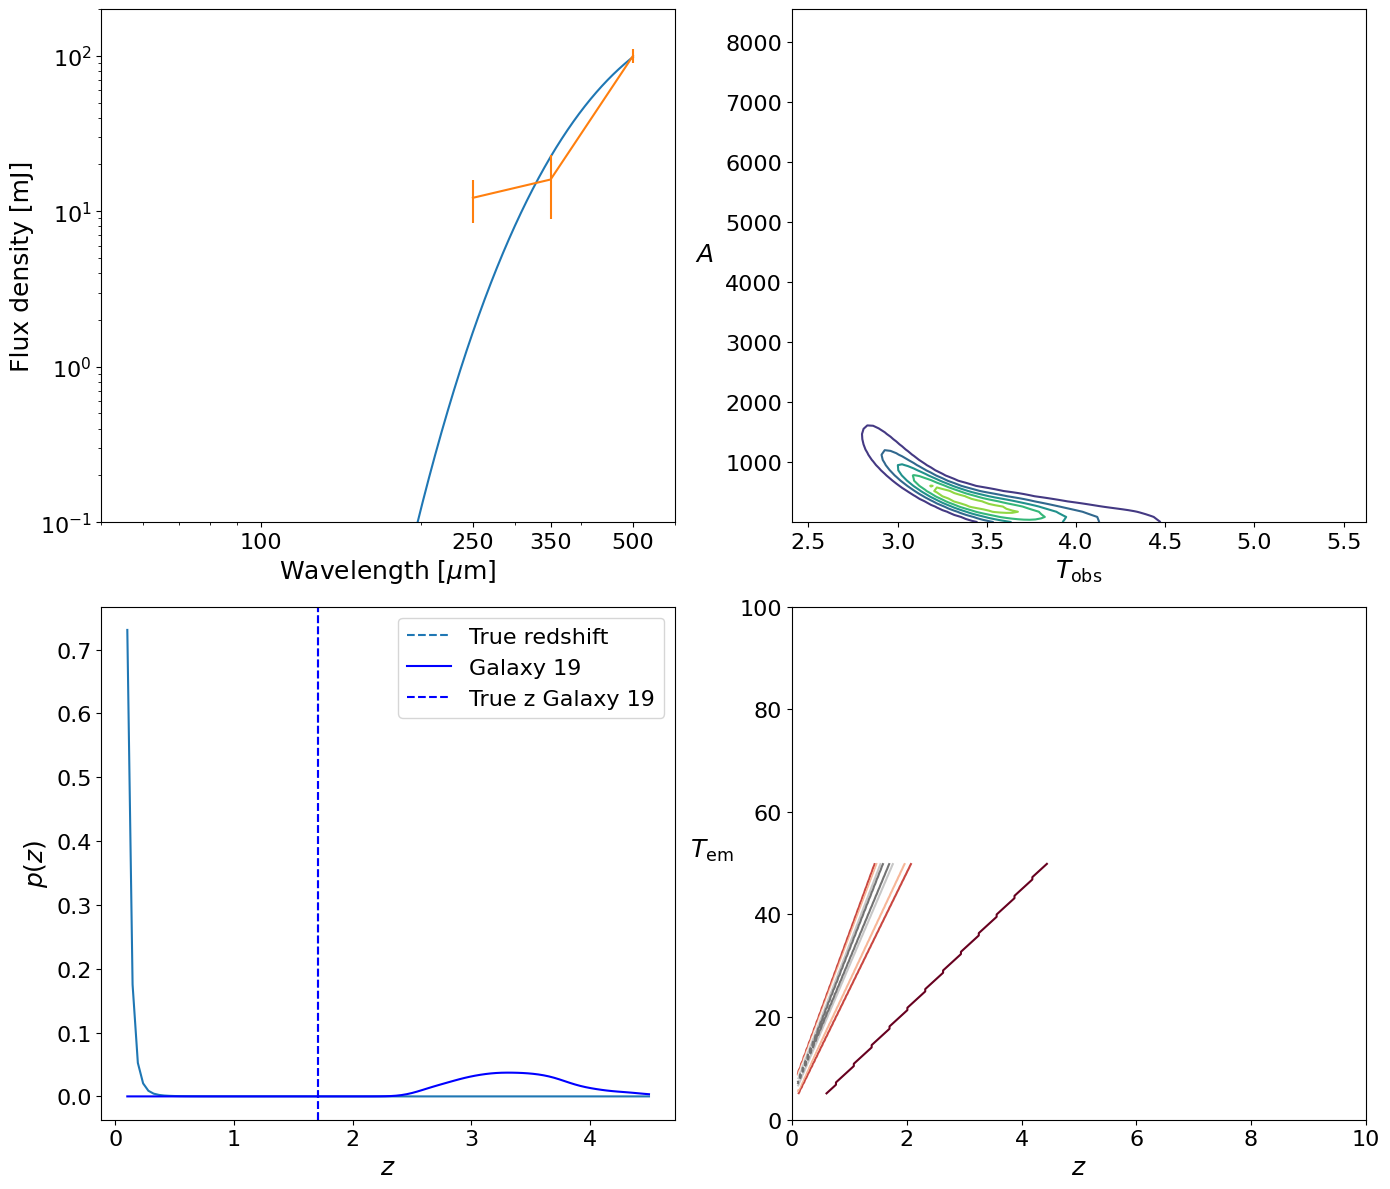

----------------------------------------------------------
GALAXY ID =  20
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [63.02195596 56.25953218]


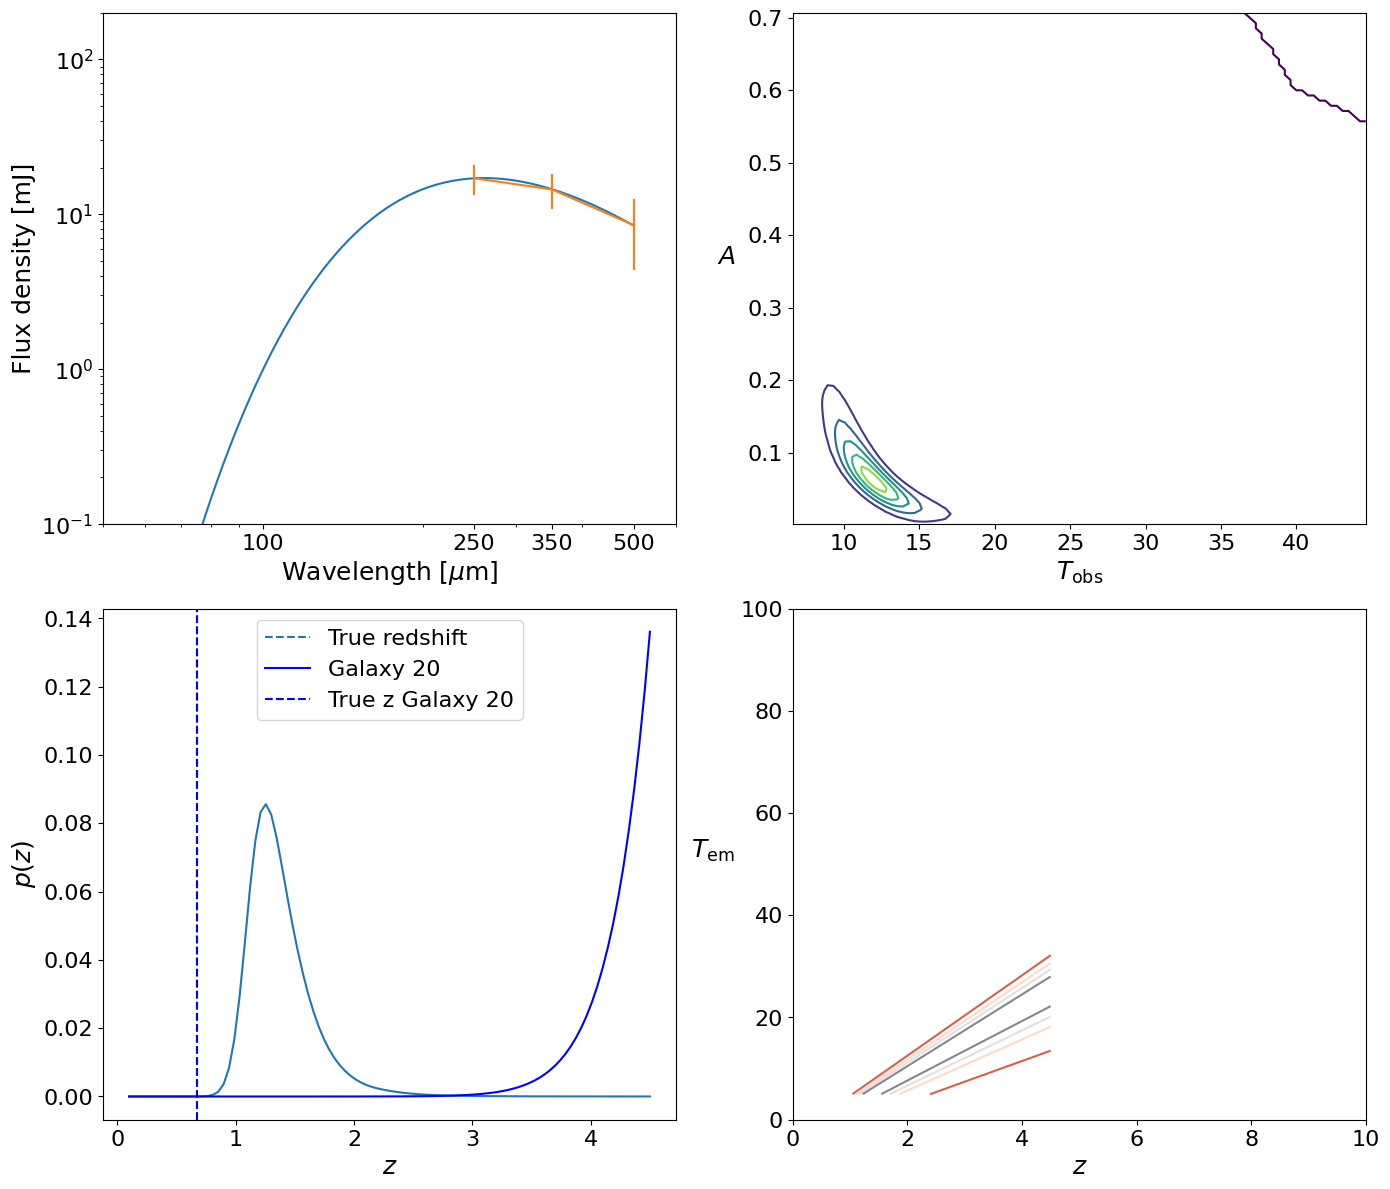

----------------------------------------------------------
GALAXY ID =  21
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [72.17515273 66.65994014]


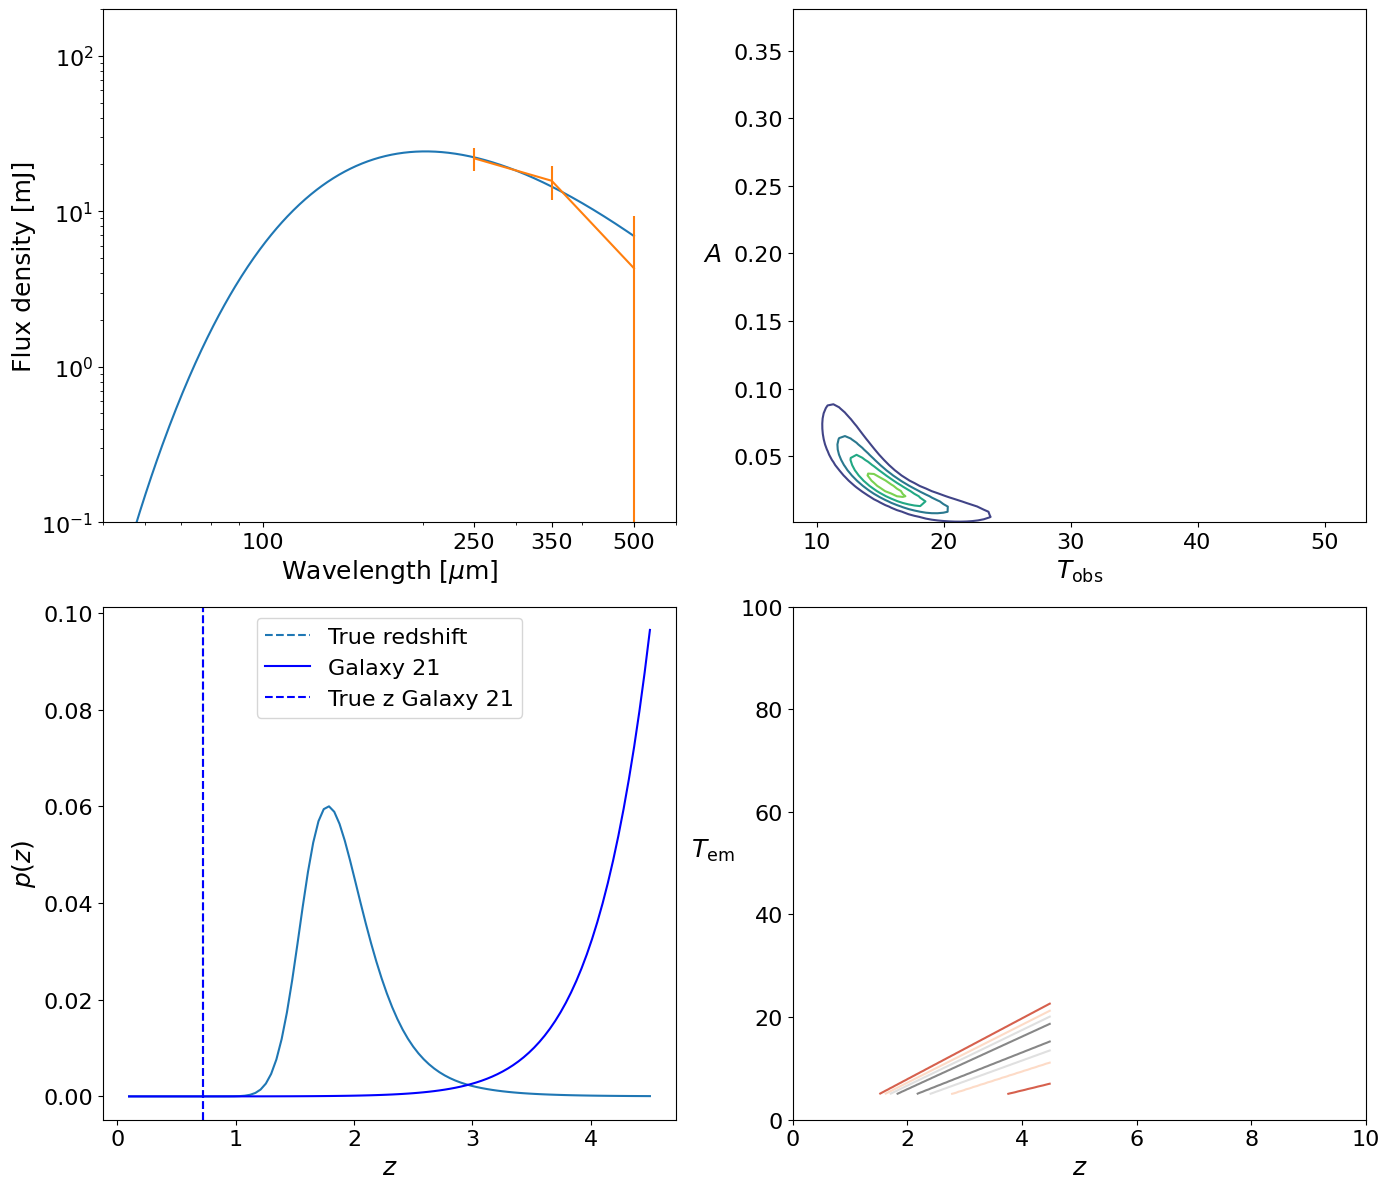

----------------------------------------------------------
GALAXY ID =  22
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [65.18674192 61.11196051]


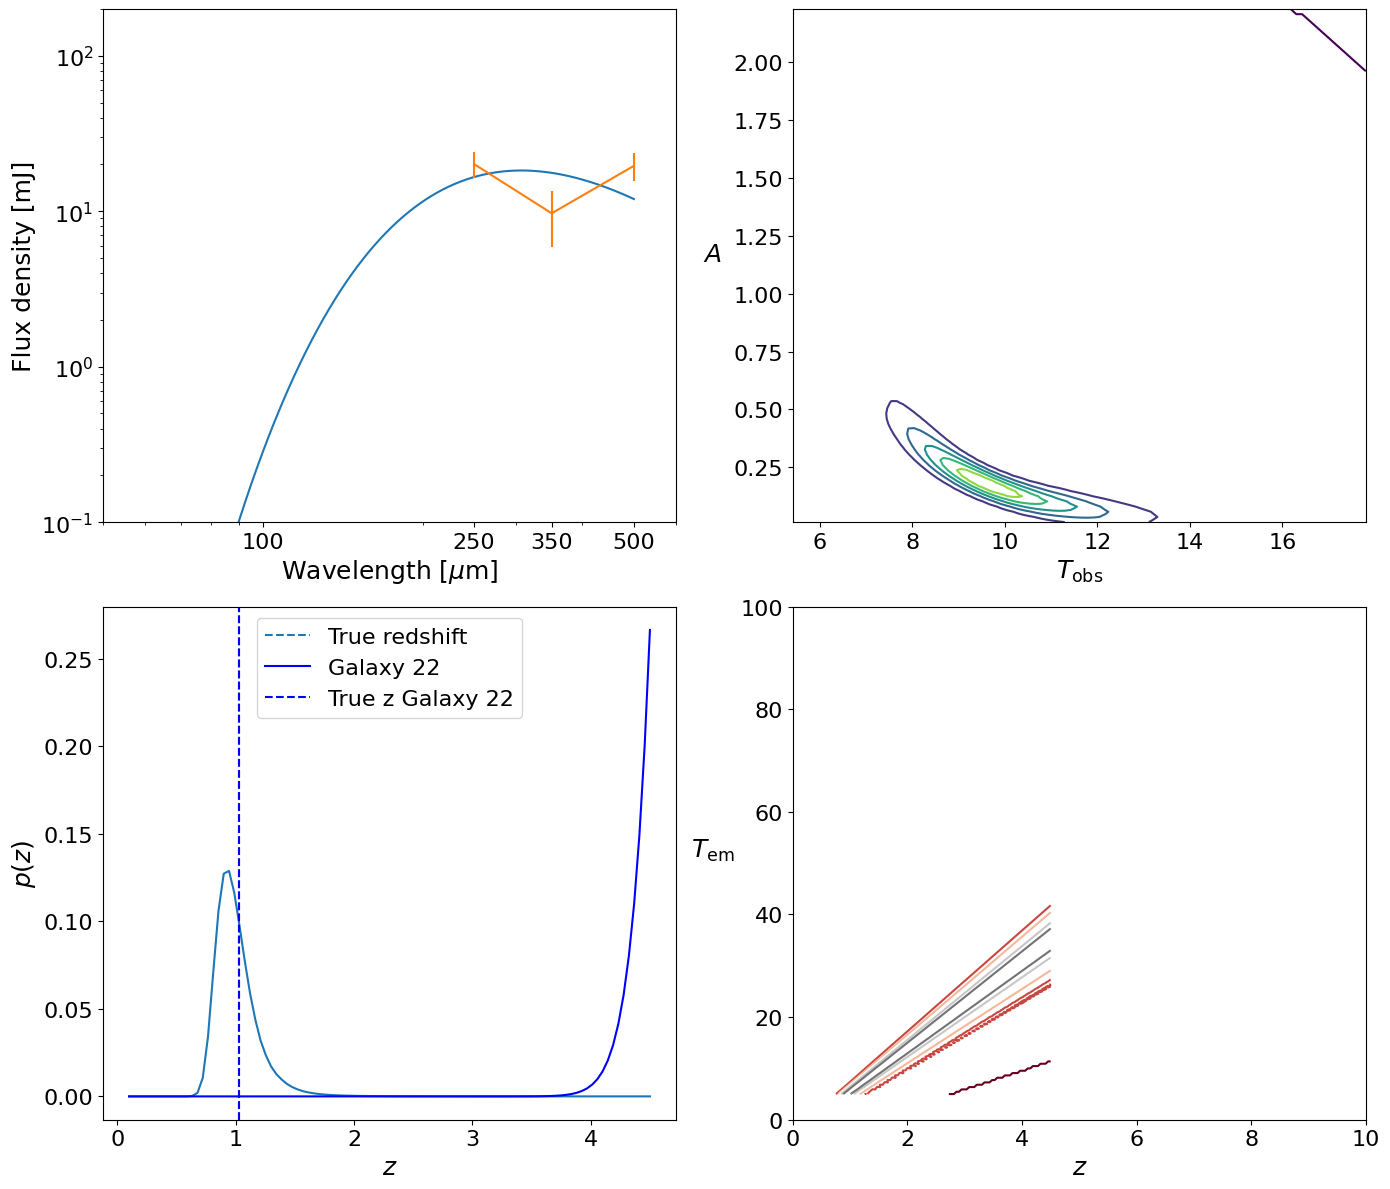

----------------------------------------------------------
GALAXY ID =  23
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [70.47166844 63.76861361]


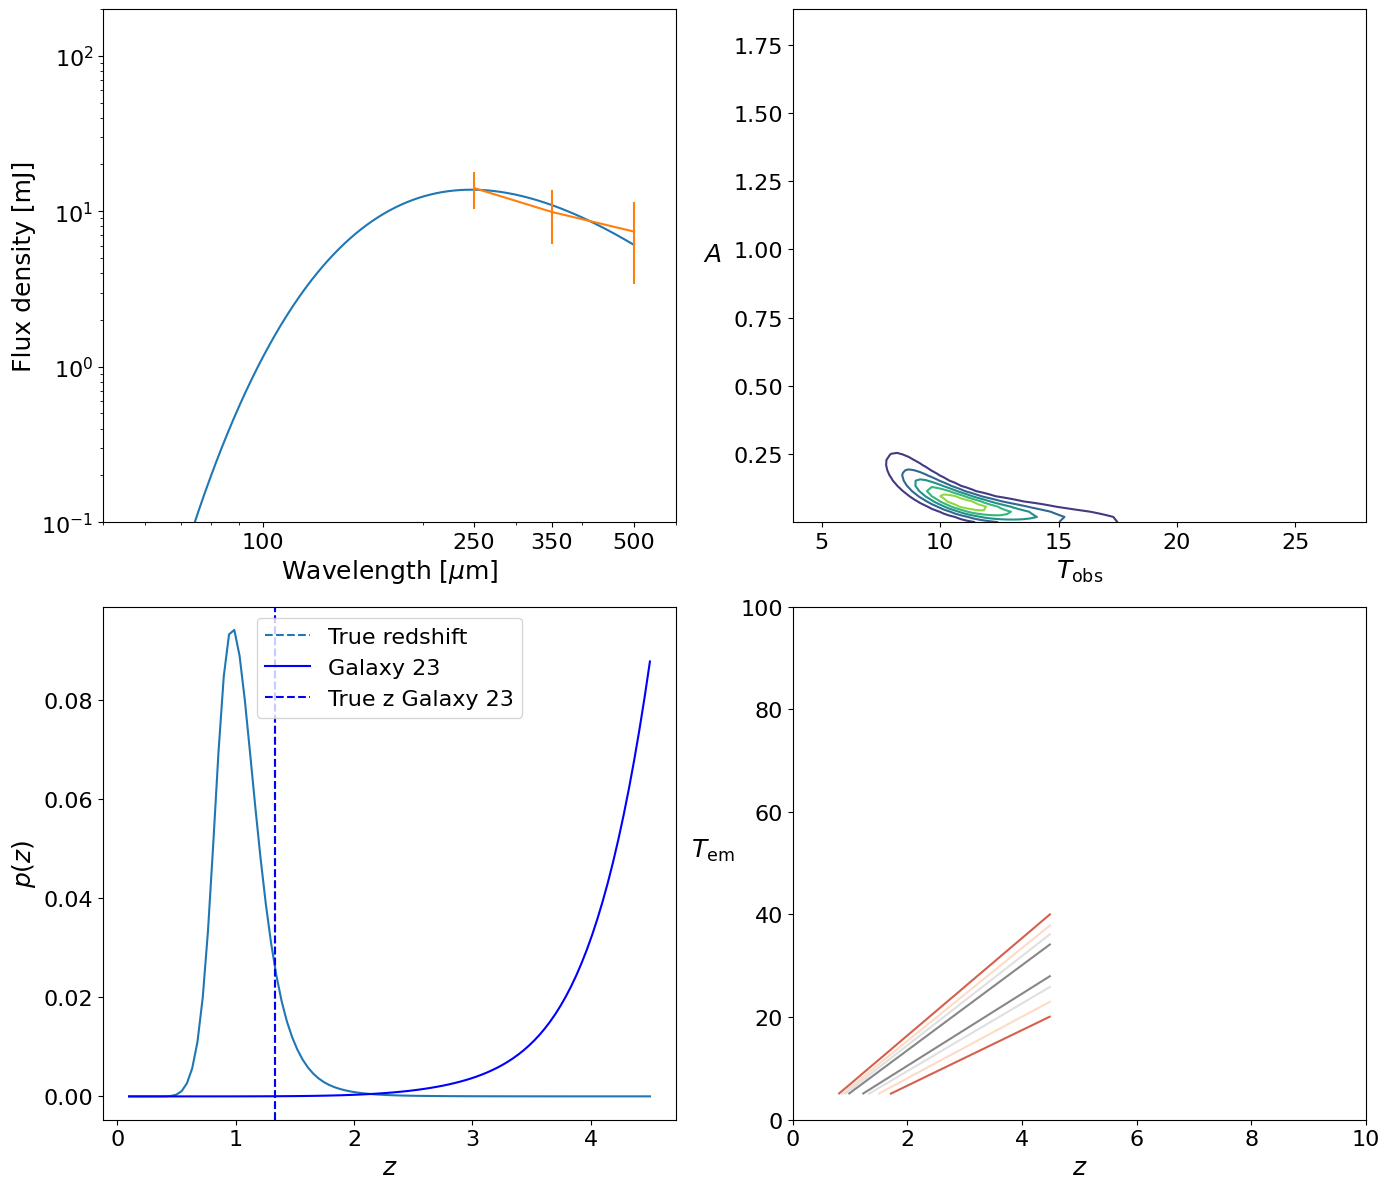

----------------------------------------------------------
GALAXY ID =  24
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [69.02402653 66.32882507]


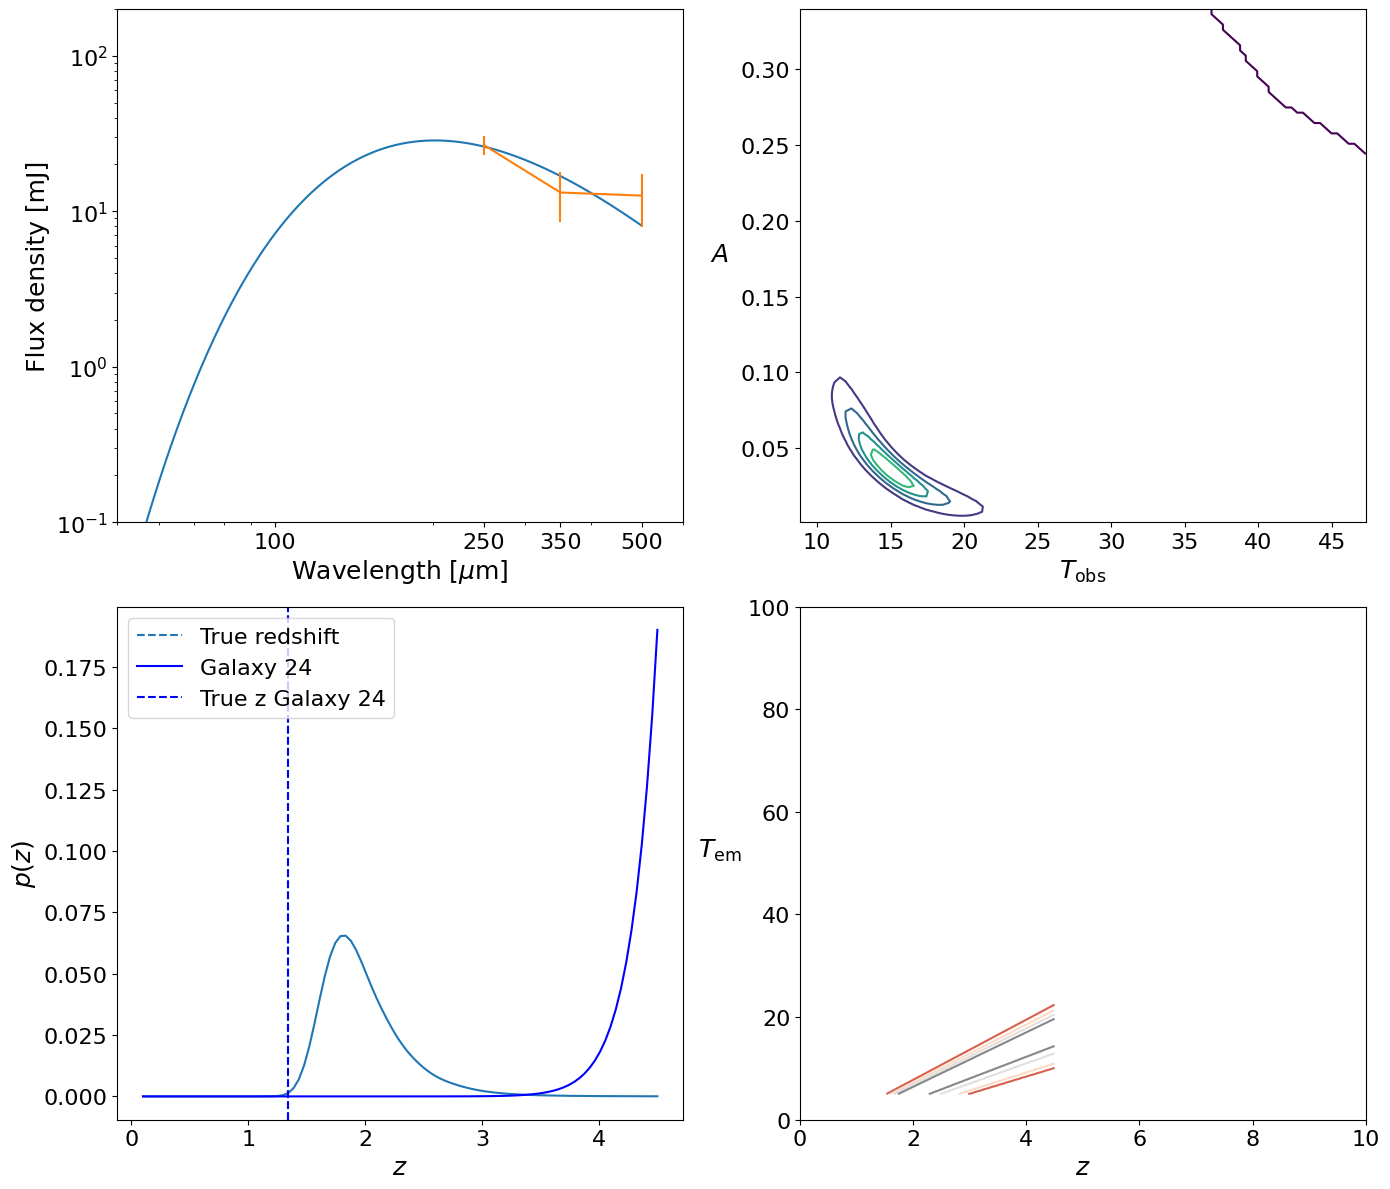

----------------------------------------------------------
GALAXY ID =  25
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [70.87066215 66.01169595]


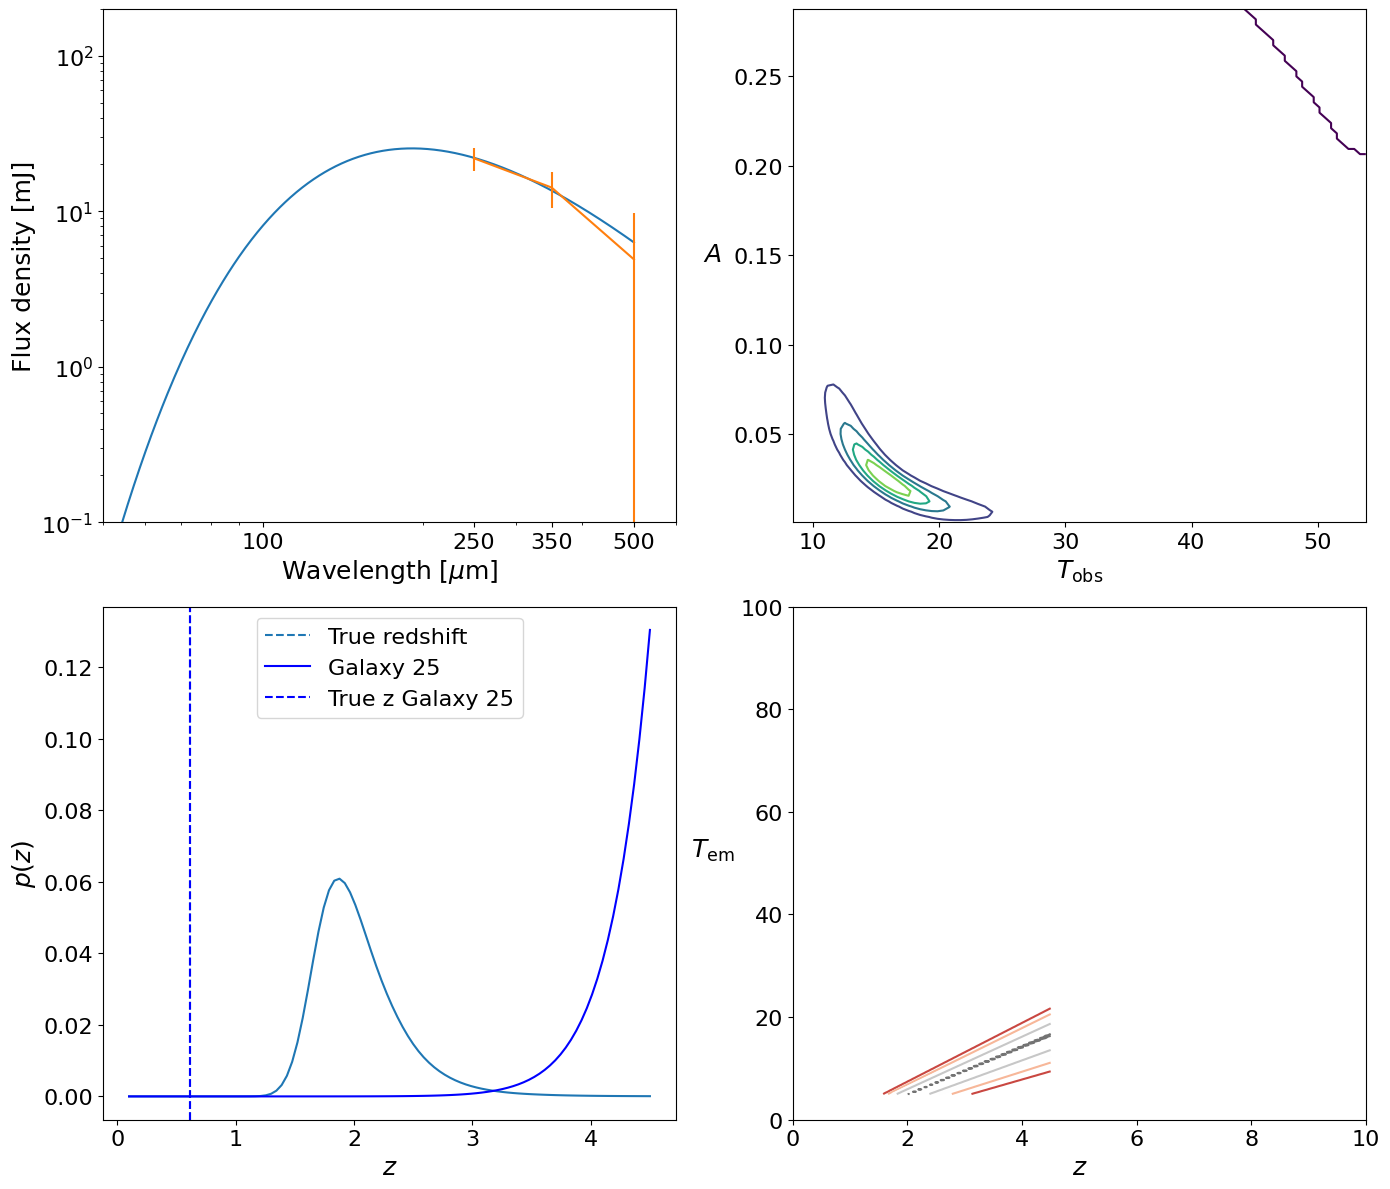

----------------------------------------------------------
GALAXY ID =  26
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.57775802 48.14659636]


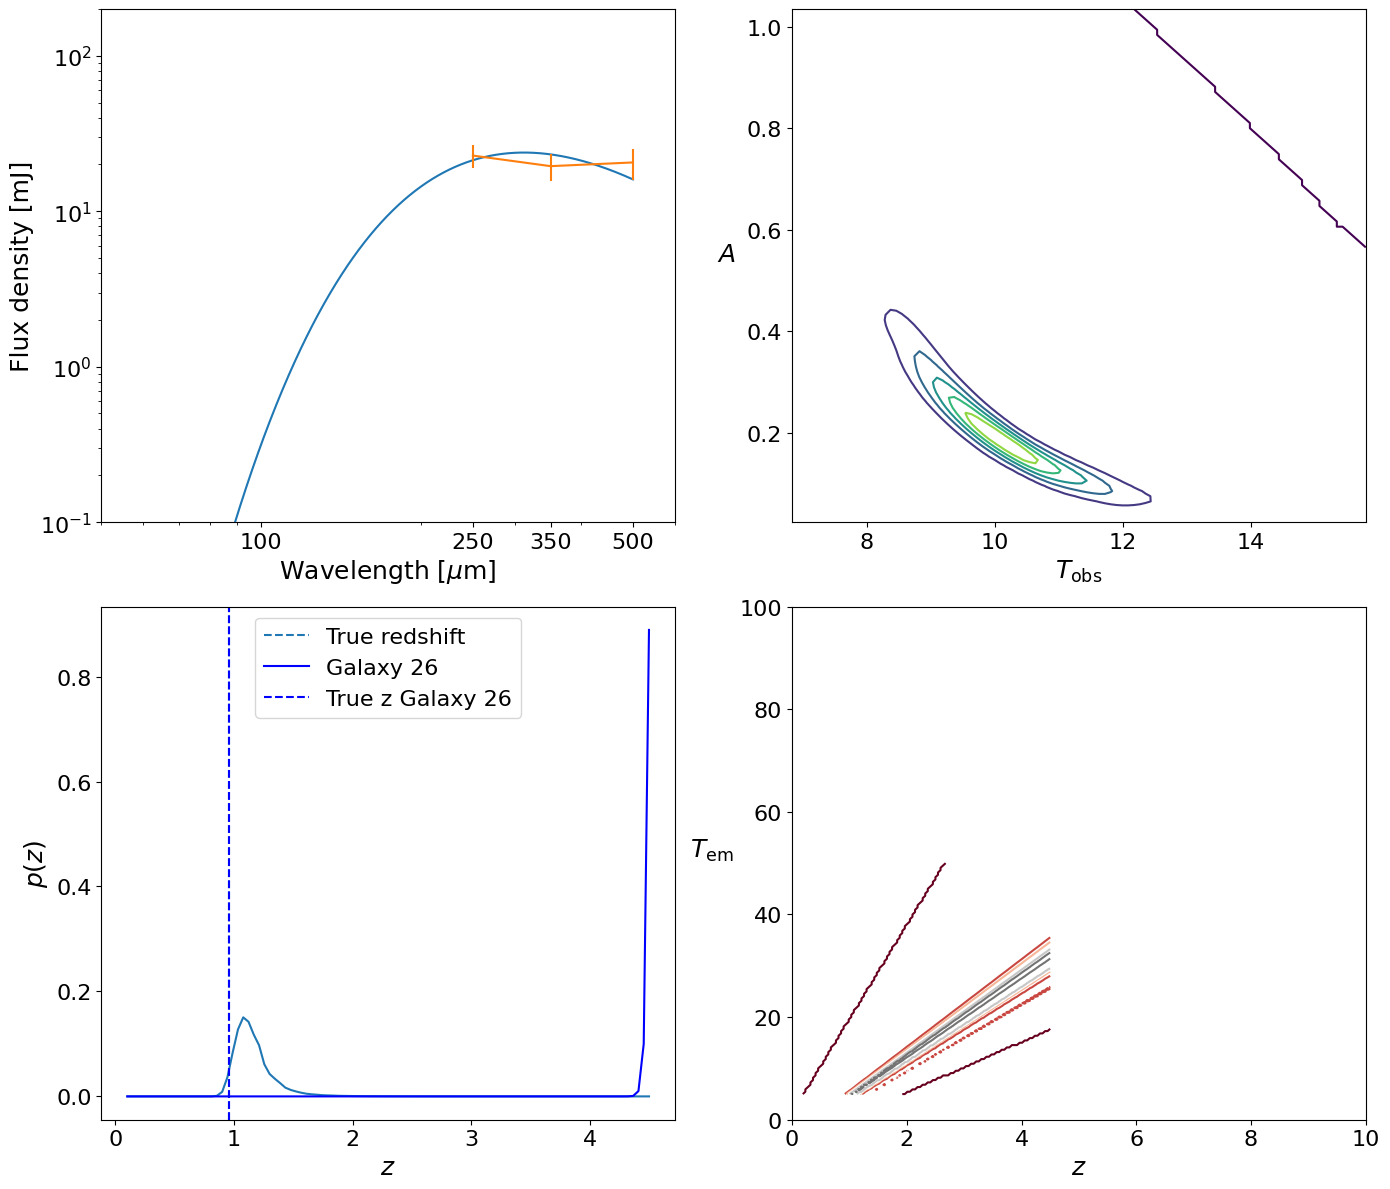

----------------------------------------------------------
GALAXY ID =  27
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [75.75876273 69.78794337]


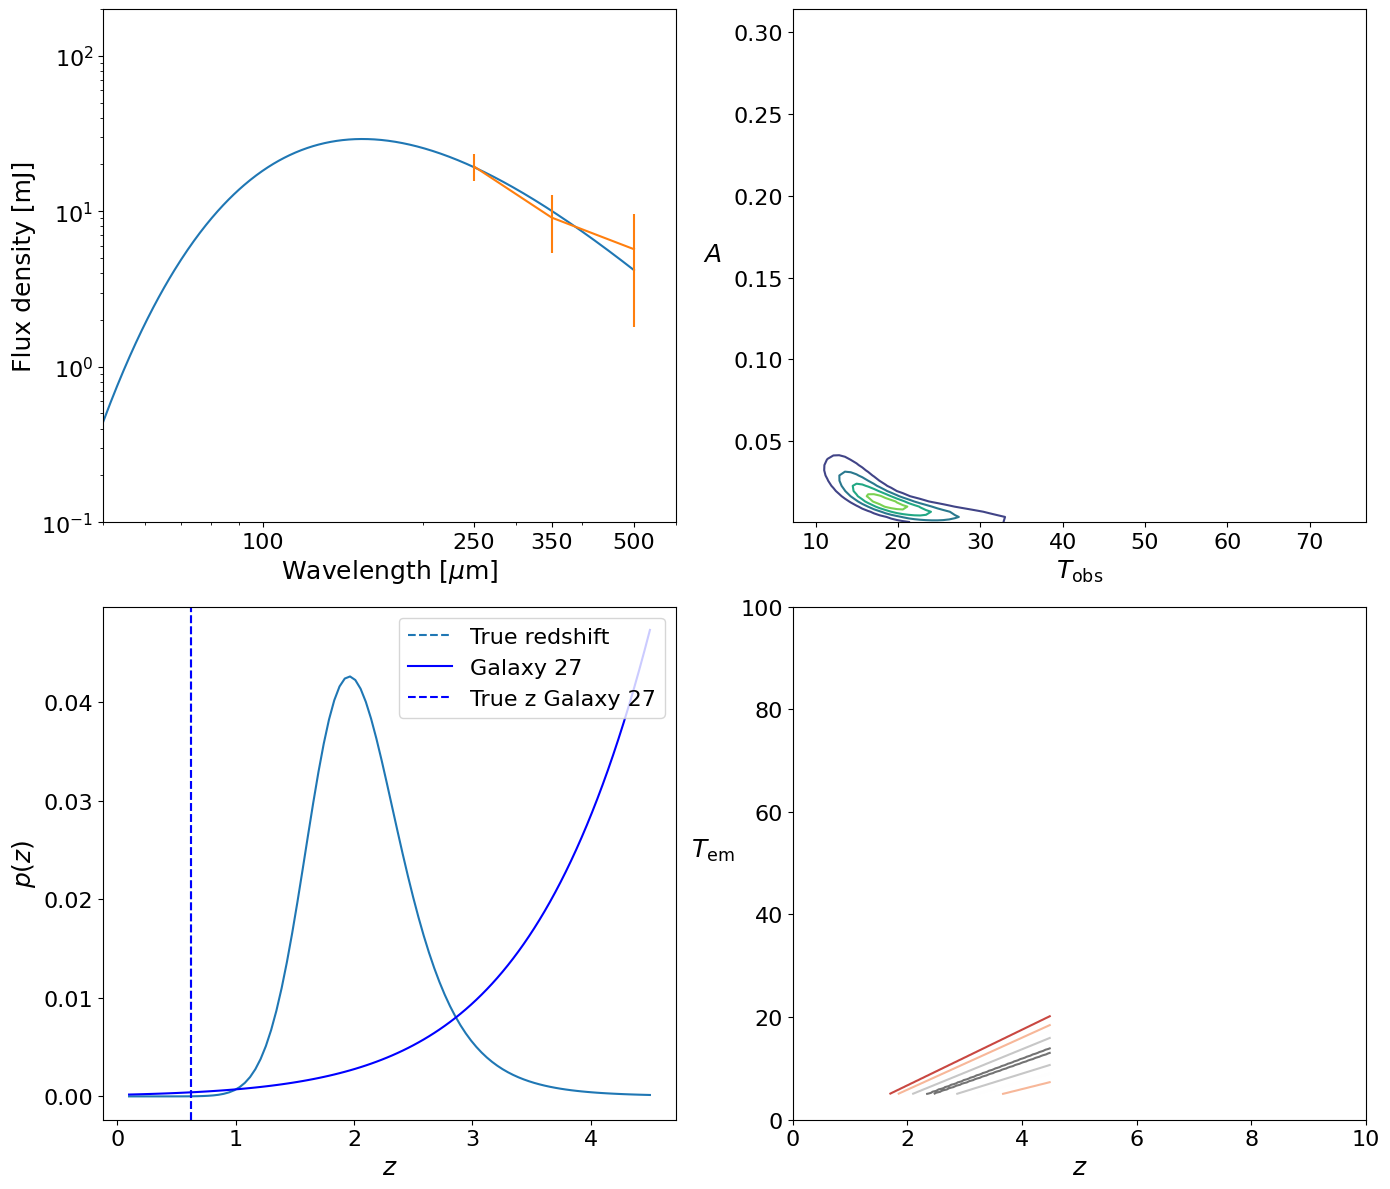

----------------------------------------------------------
GALAXY ID =  28
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [40.87512986 43.32515487]


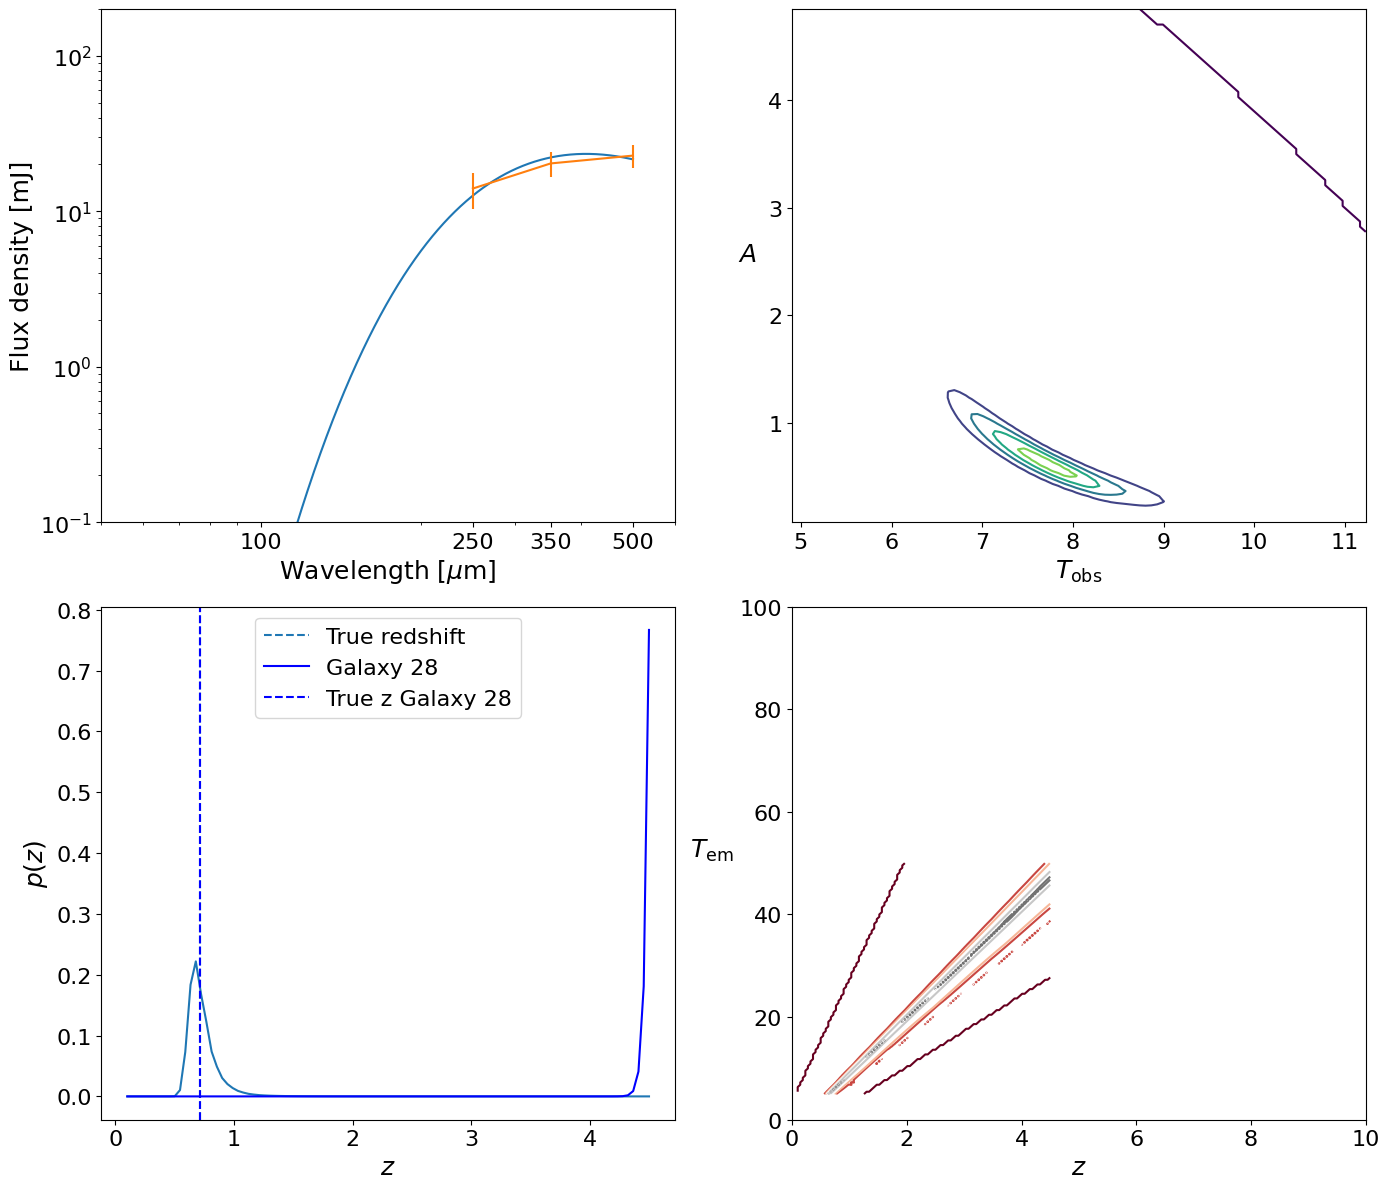

----------------------------------------------------------
GALAXY ID =  29
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [109.5267657   57.72356148]


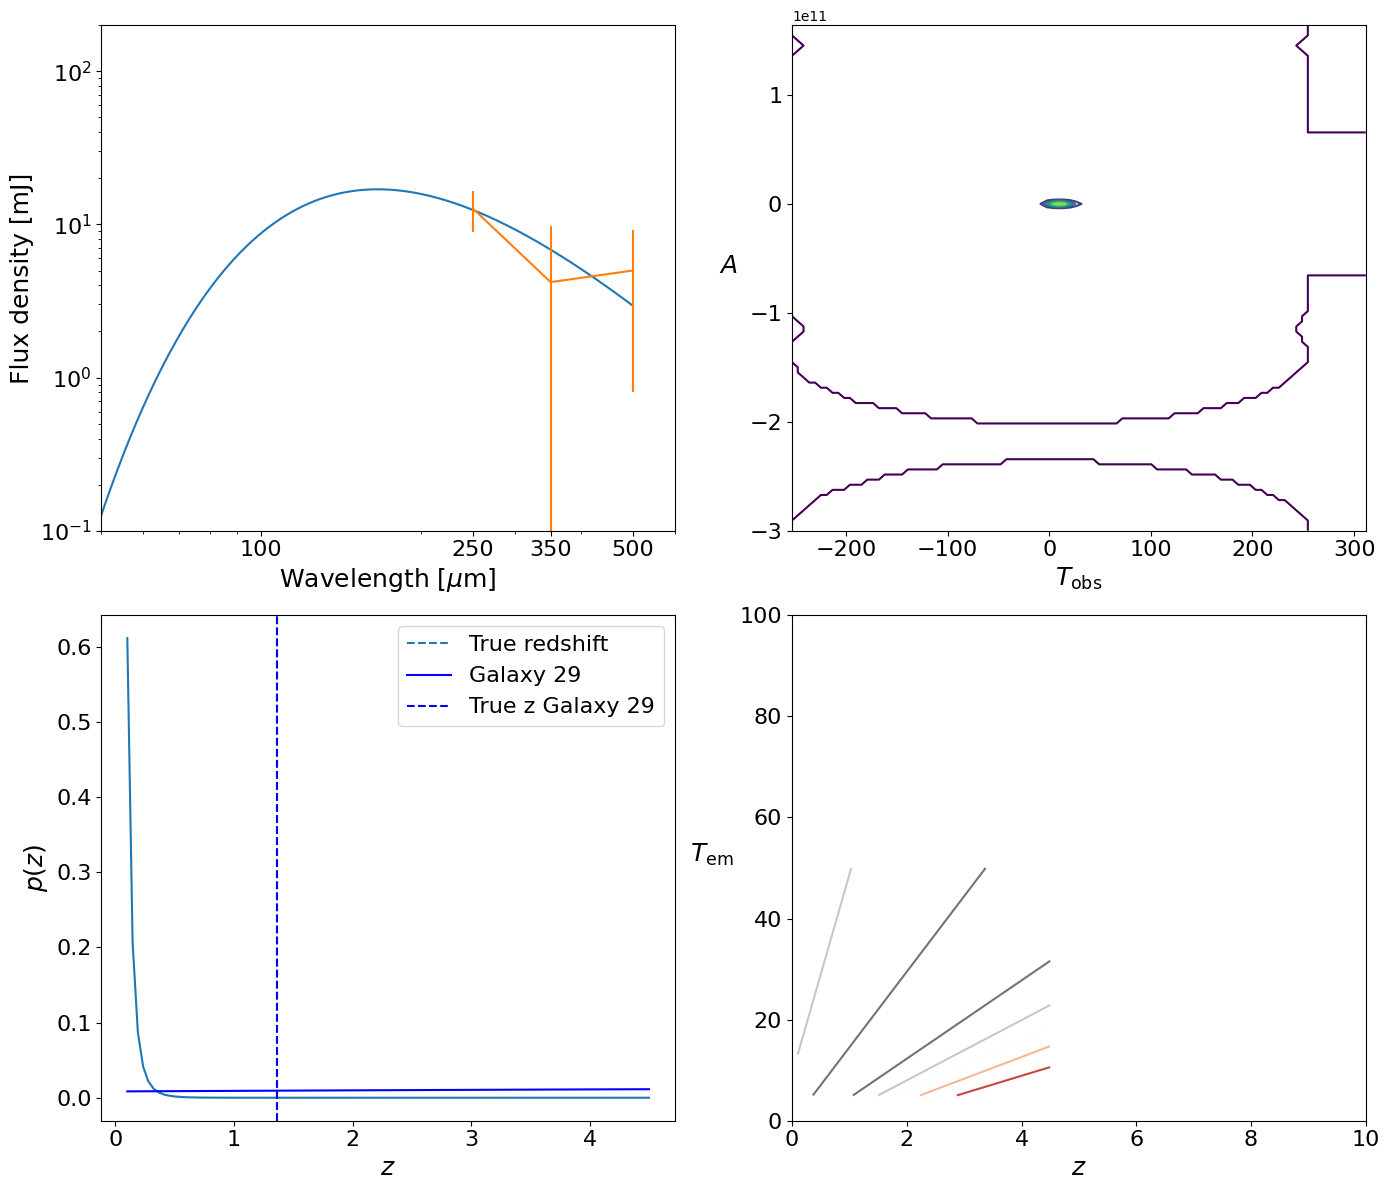

----------------------------------------------------------
GALAXY ID =  30
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [115.52923993  47.22648061]


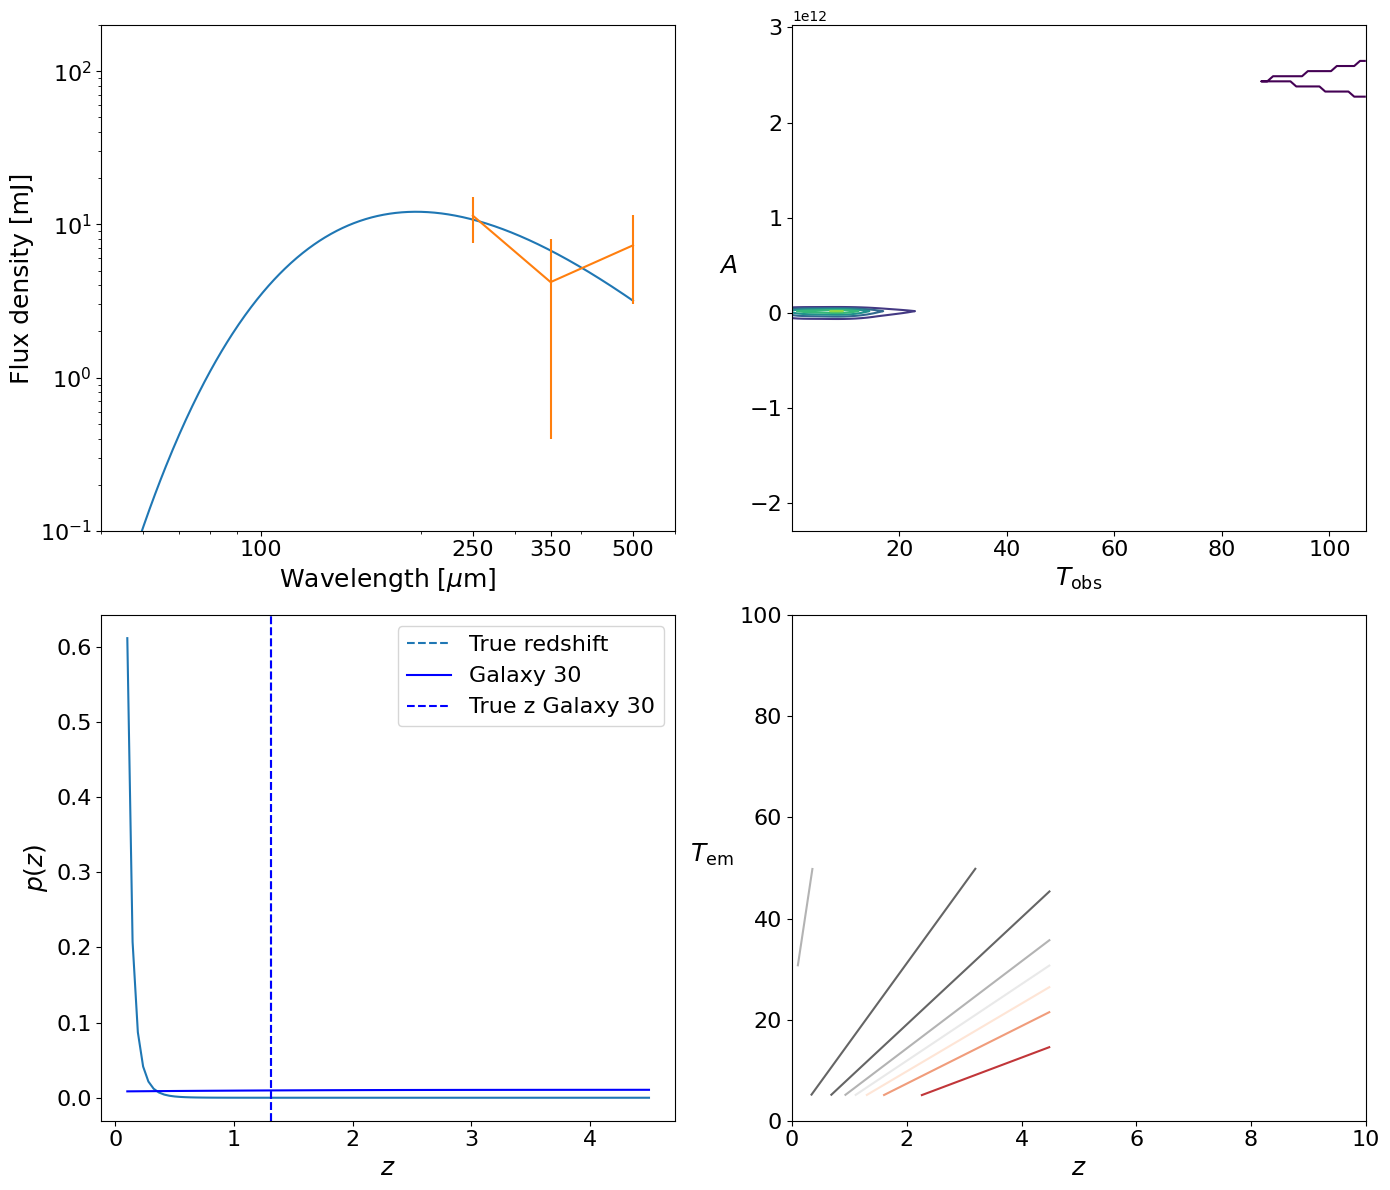

----------------------------------------------------------
GALAXY ID =  31
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [55.88551884 53.92546106]


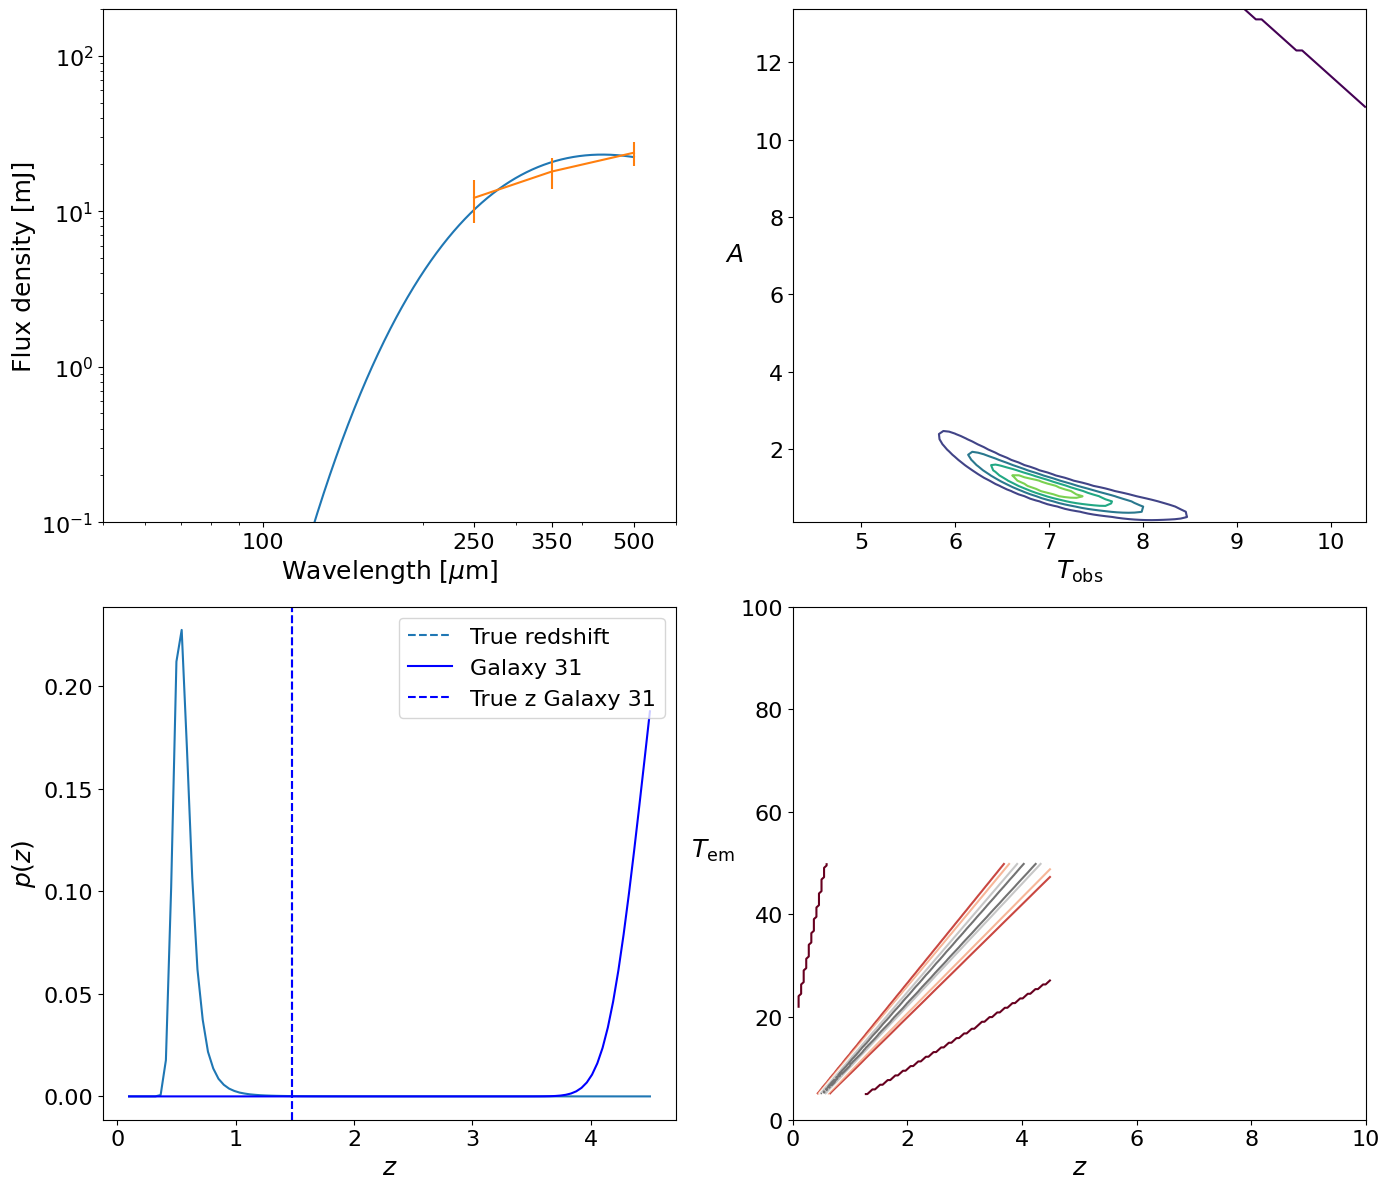

----------------------------------------------------------
GALAXY ID =  32
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [120.76872252 107.77410583]


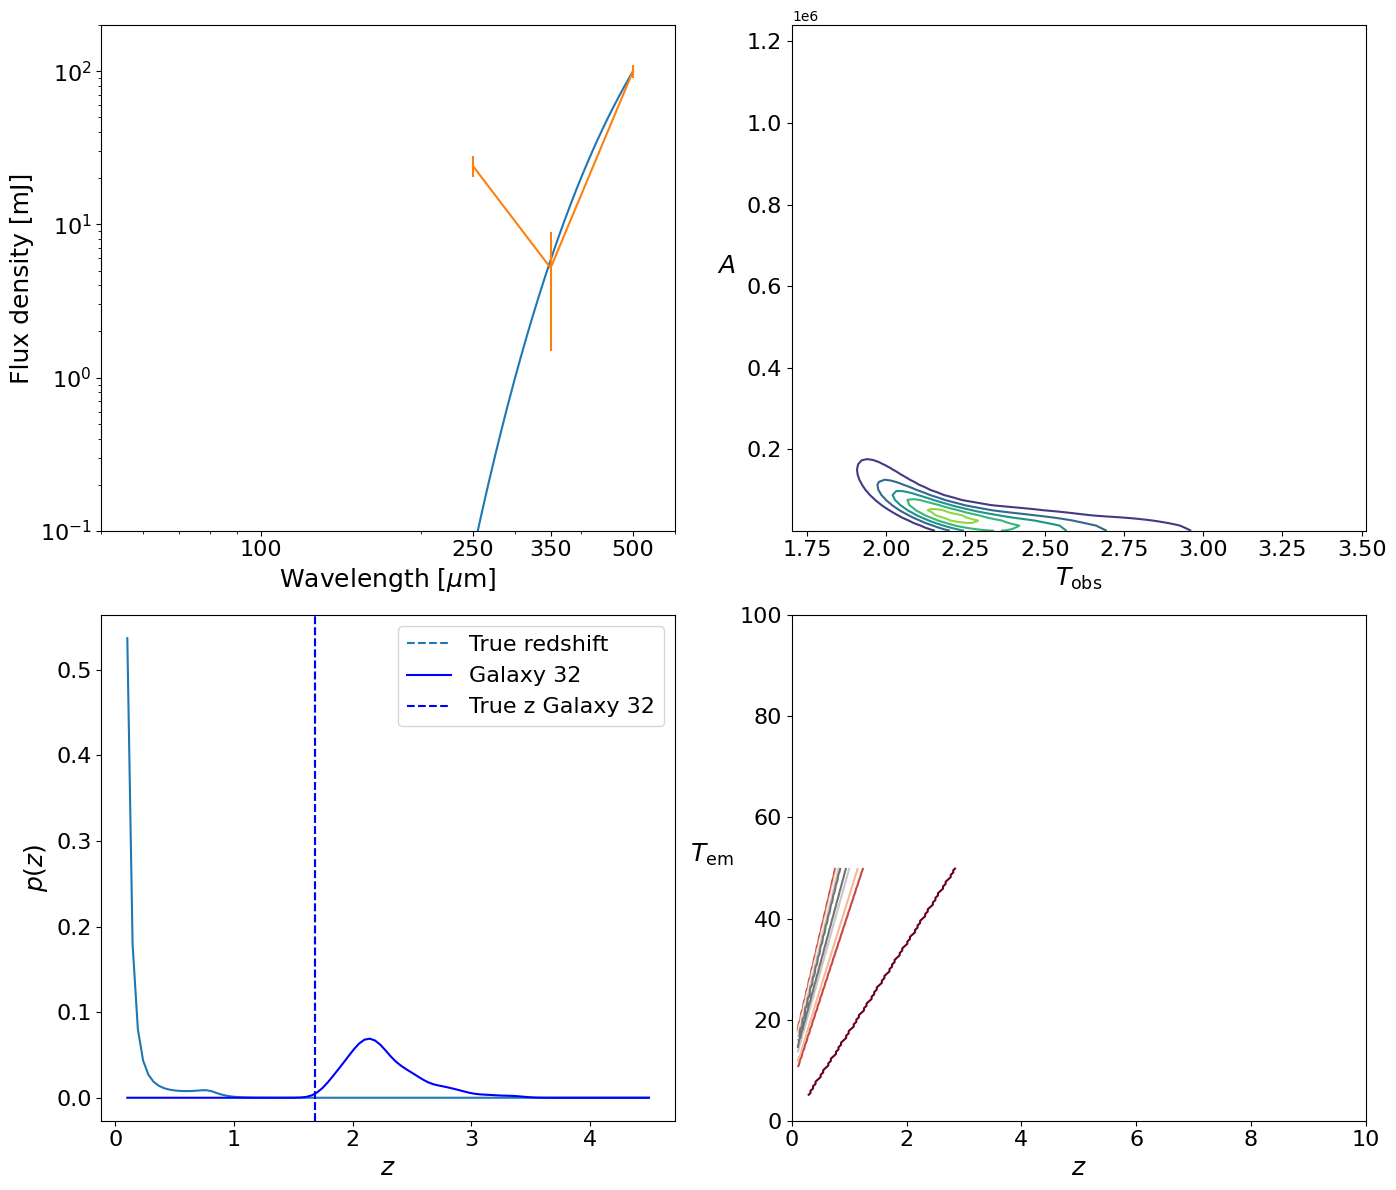

----------------------------------------------------------
GALAXY ID =  33
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [58.06997047 55.73501215]


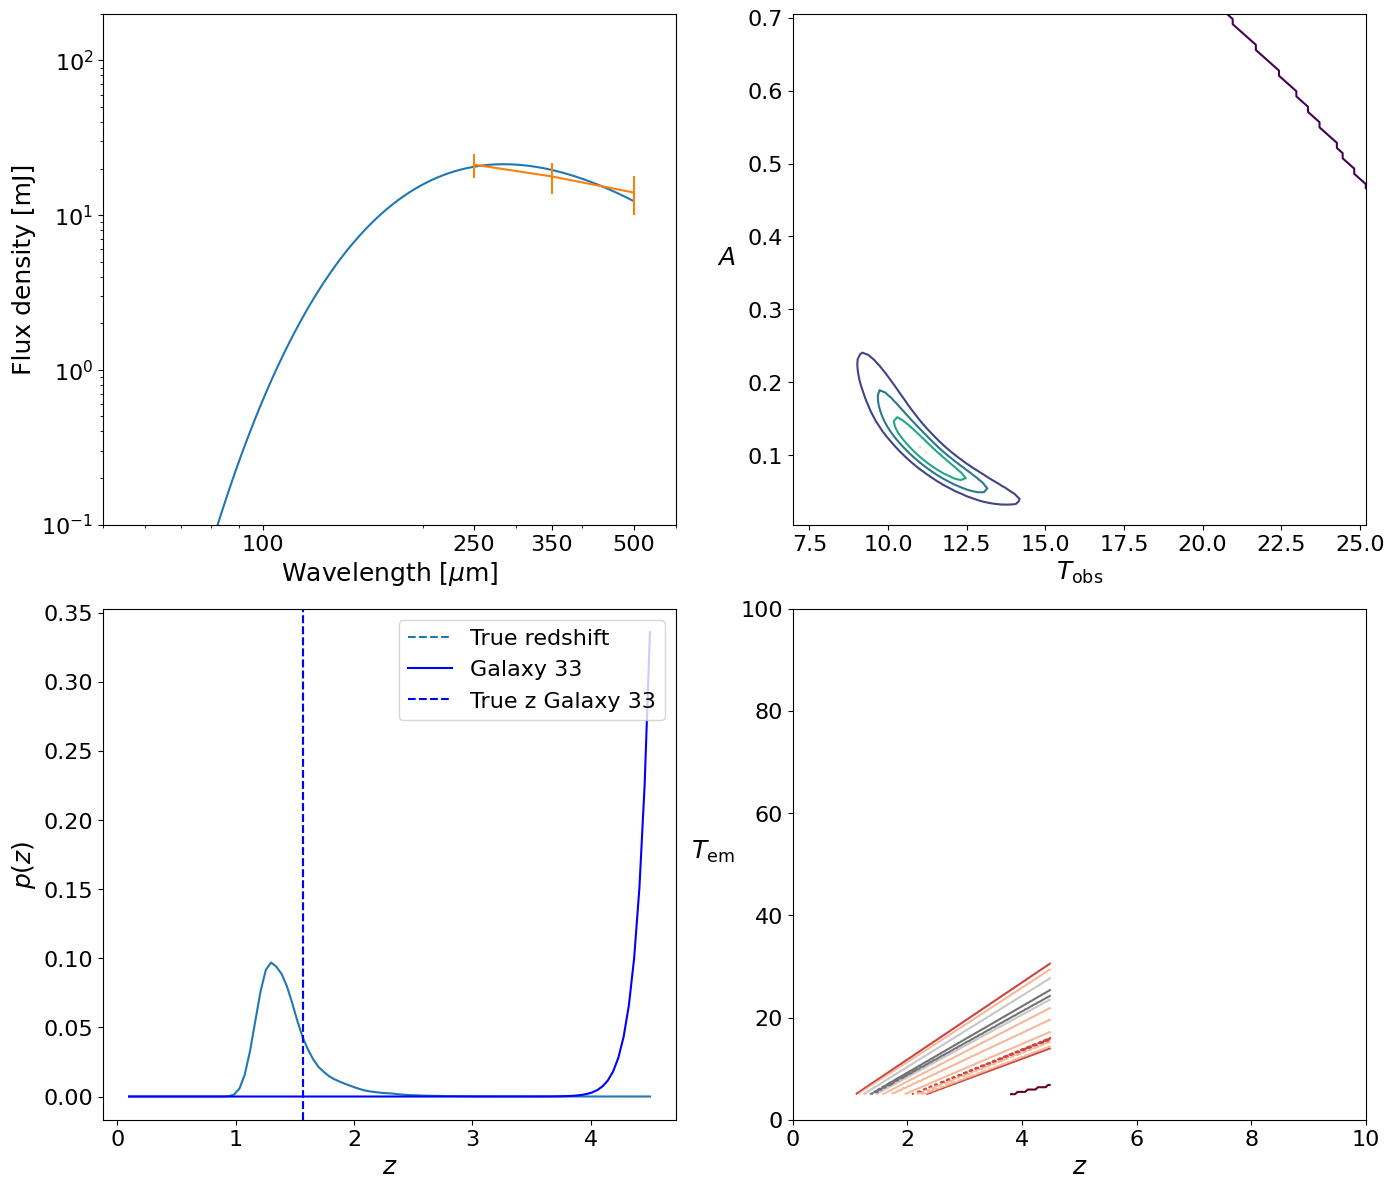

----------------------------------------------------------
GALAXY ID =  34
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [58.27216521 54.09454829]


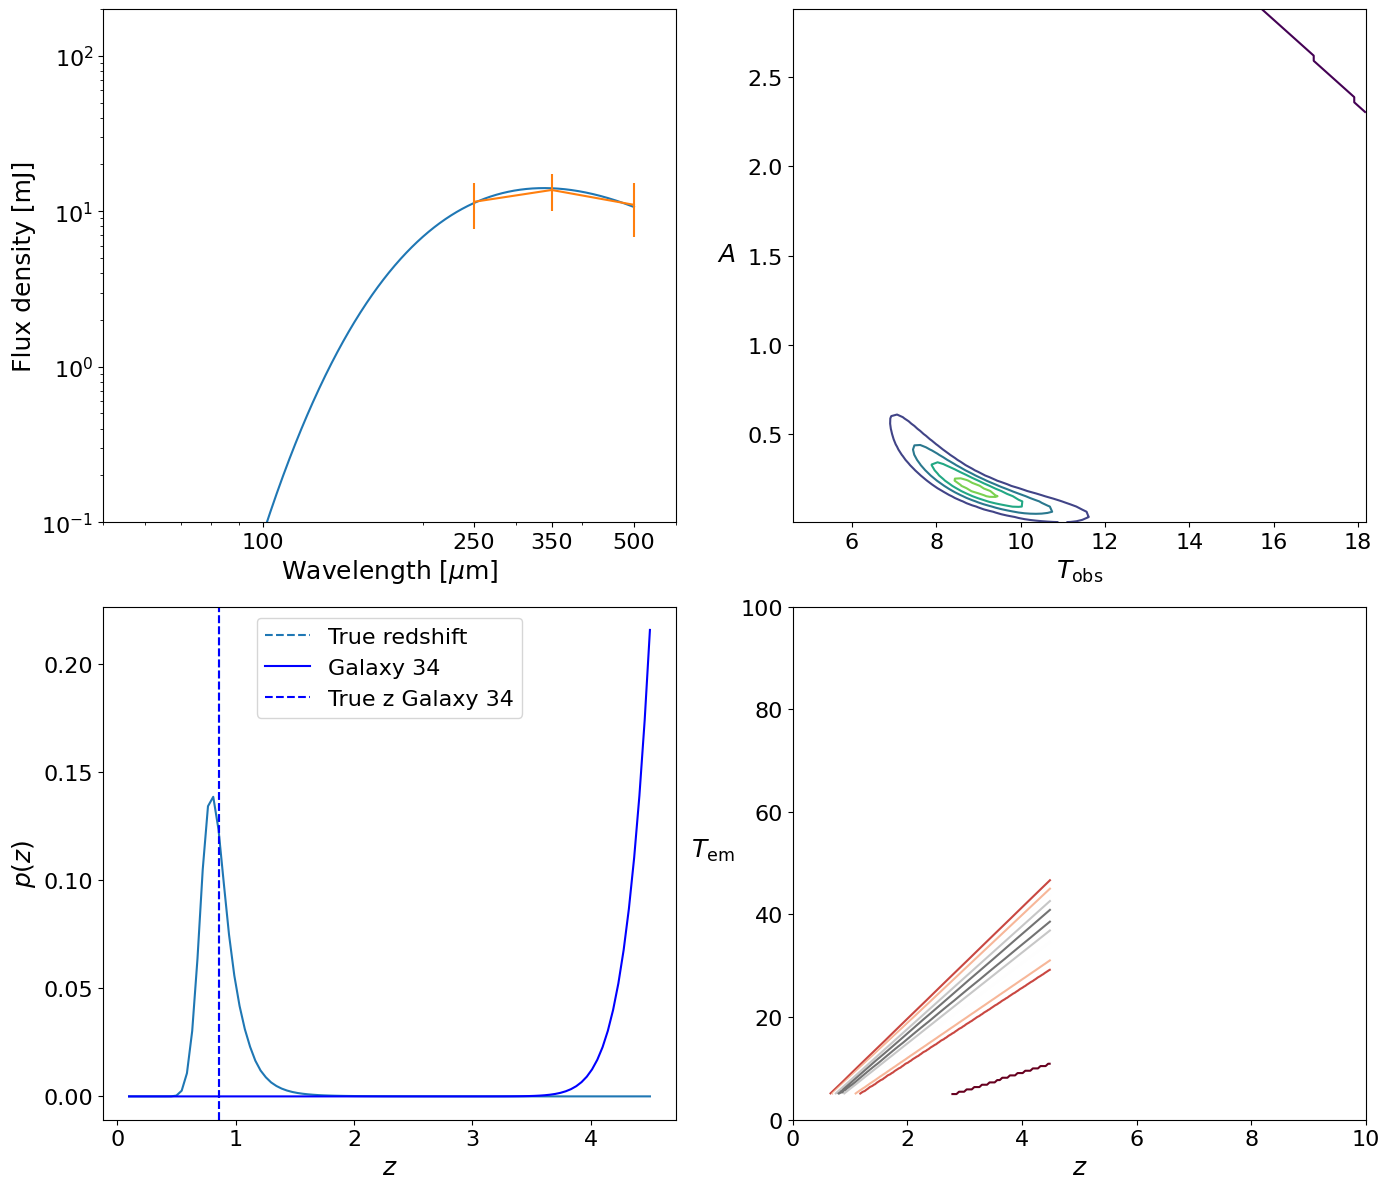

----------------------------------------------------------
GALAXY ID =  35
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [80.45832862 70.75691844]


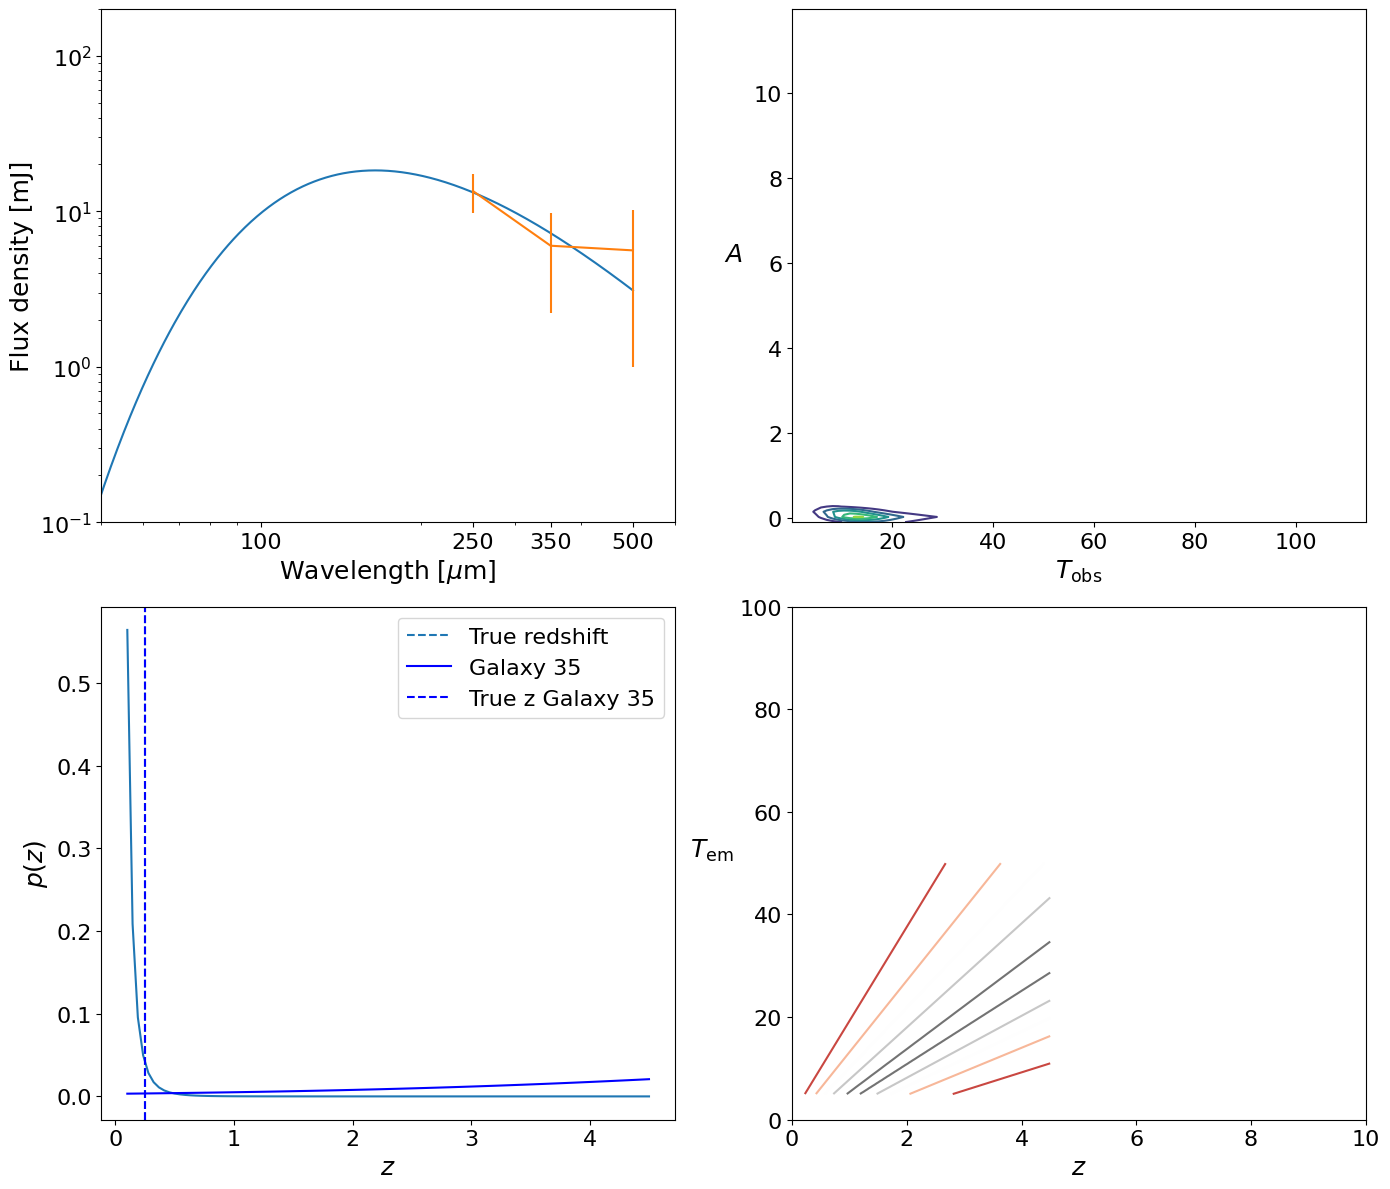

----------------------------------------------------------
GALAXY ID =  36
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [23.95444025 24.31754974]


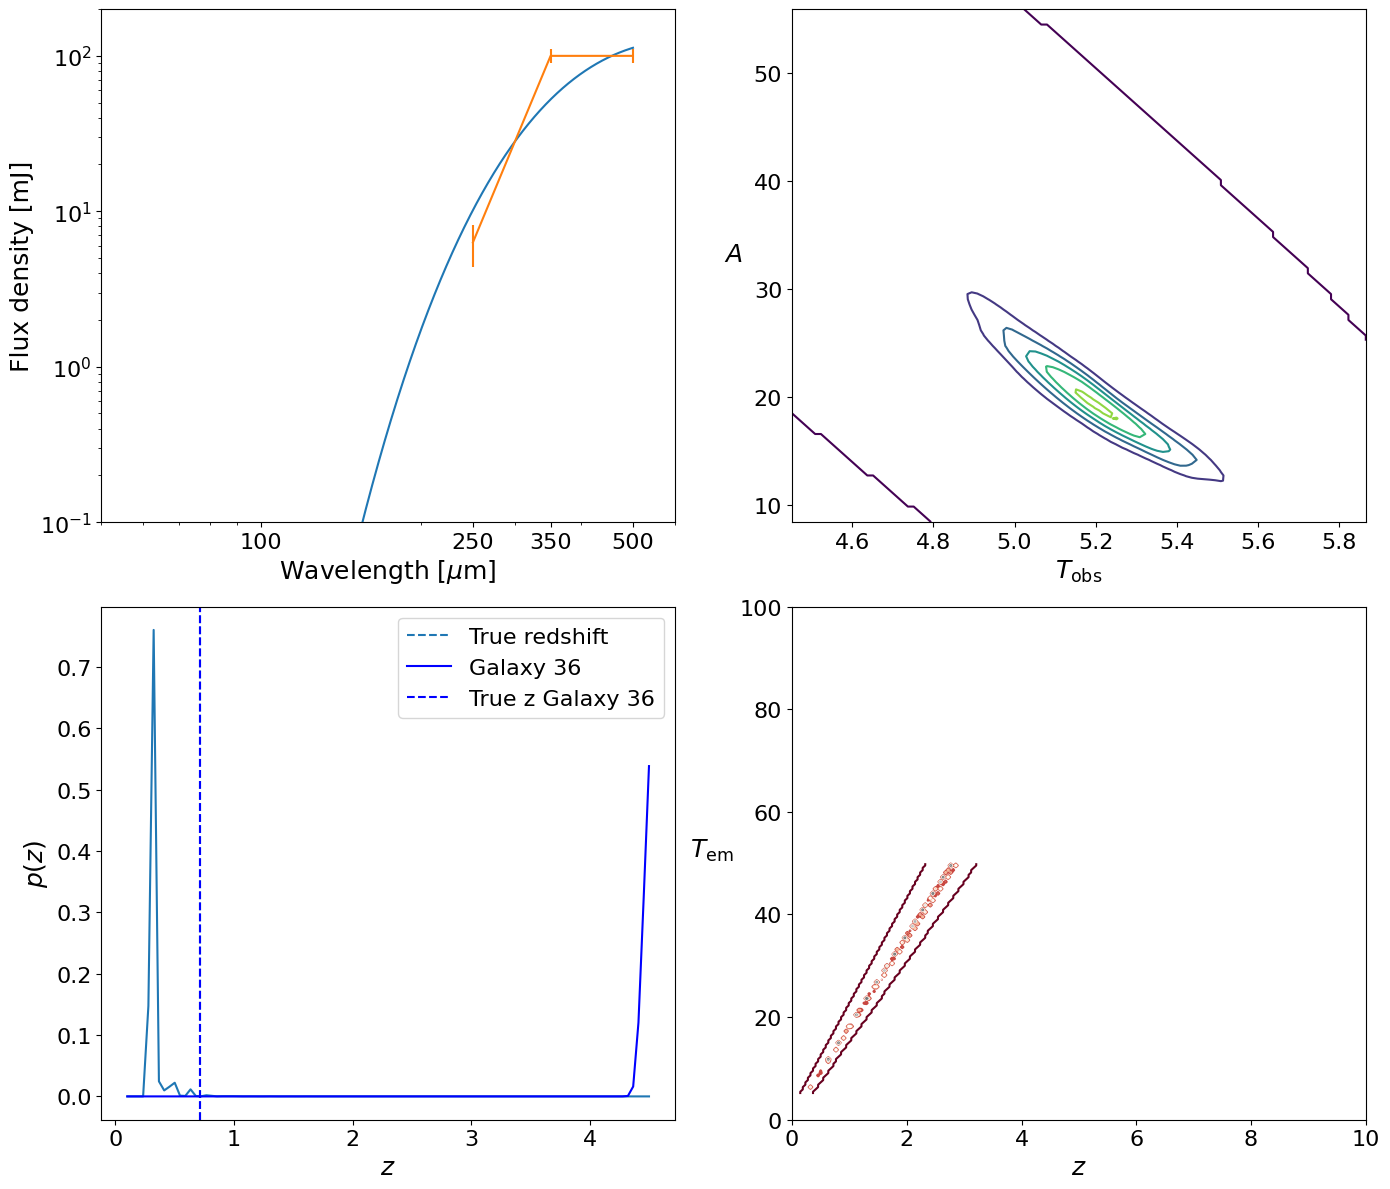

----------------------------------------------------------
GALAXY ID =  37
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [86.20819884 66.58345215]


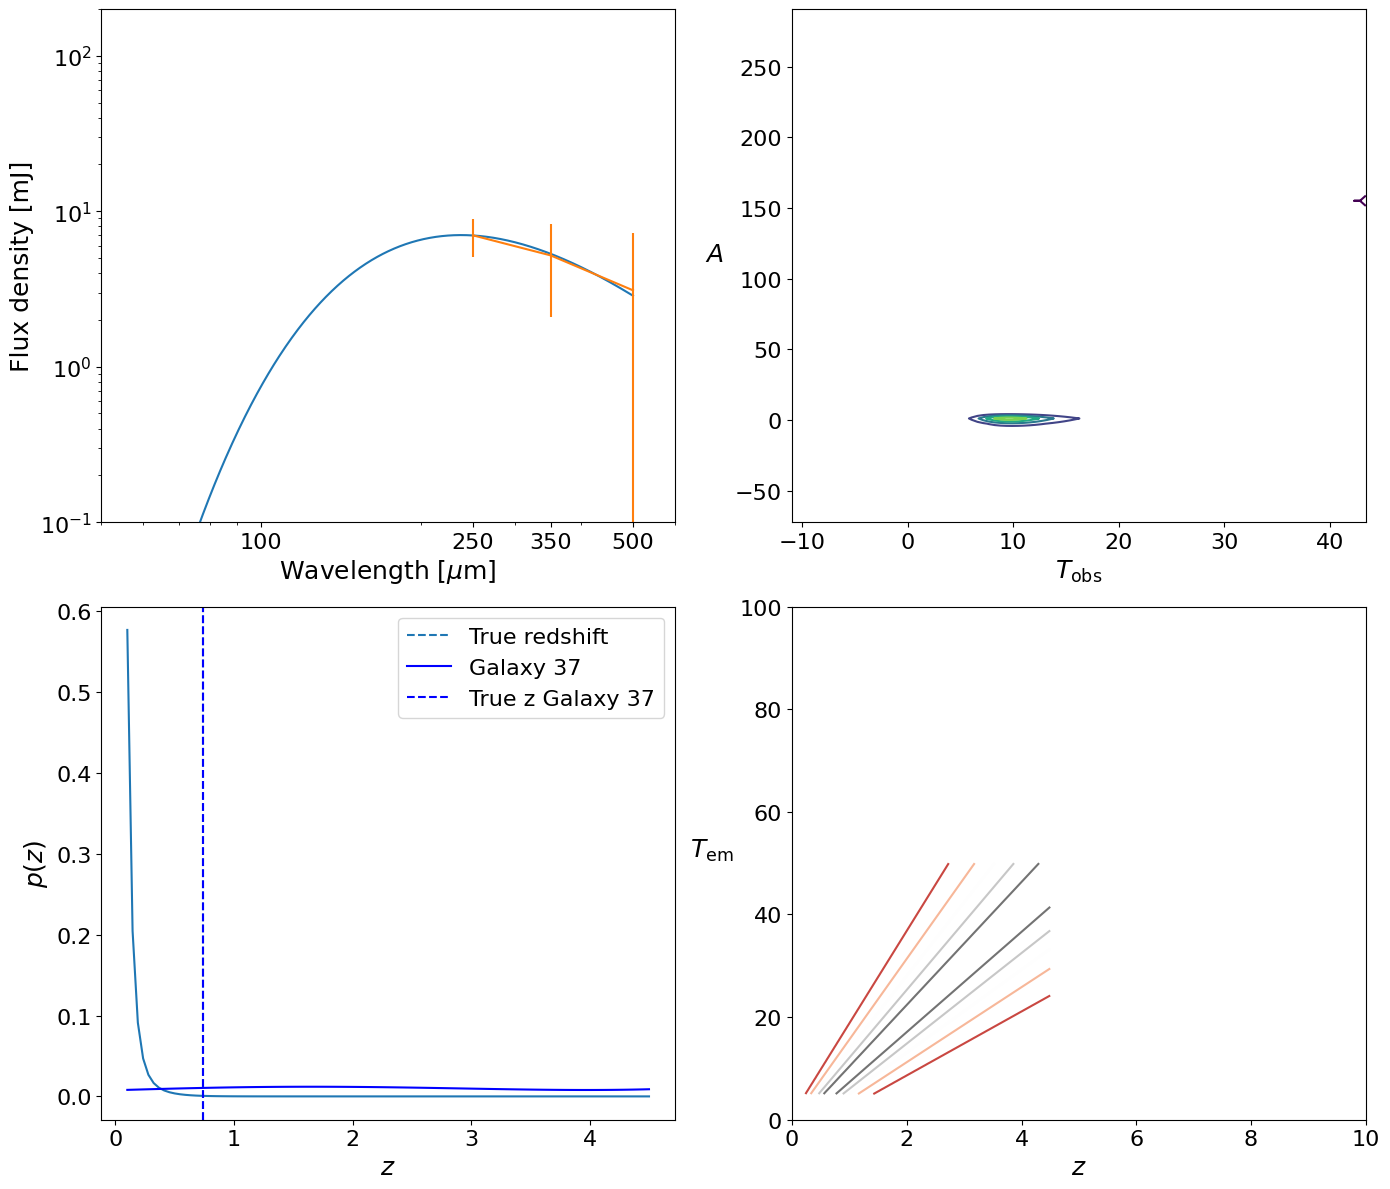

----------------------------------------------------------
GALAXY ID =  38
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [117.84541322 105.14602975]


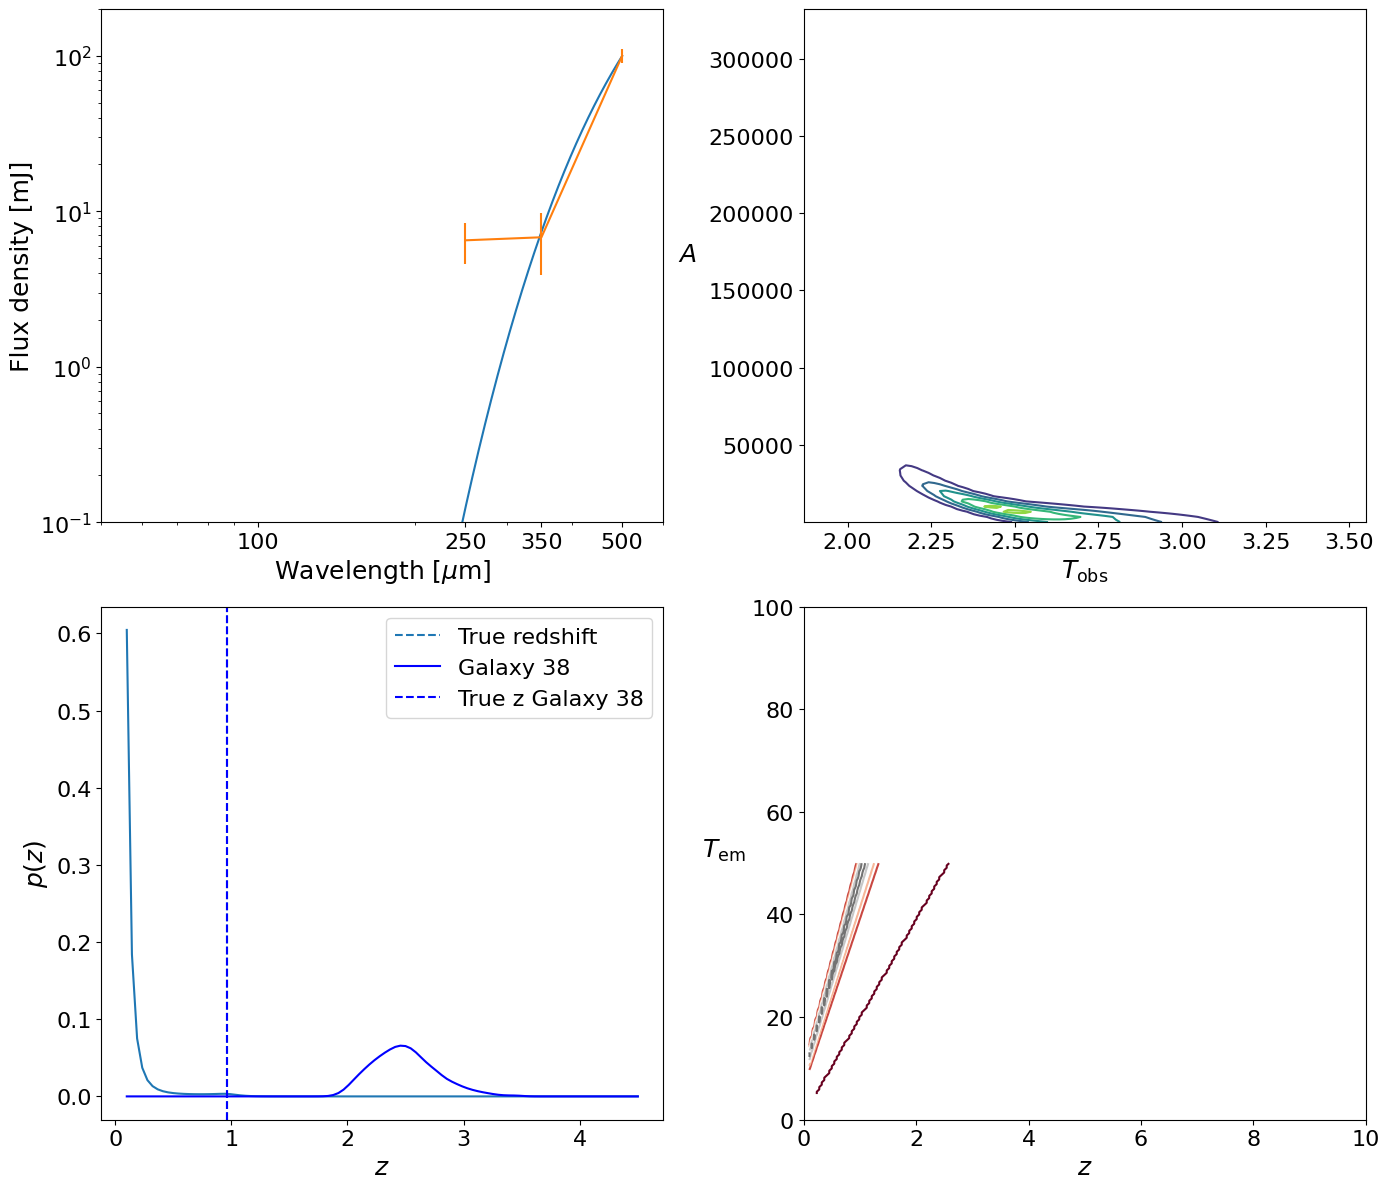

----------------------------------------------------------
GALAXY ID =  39
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [32.89457473 32.62140557]


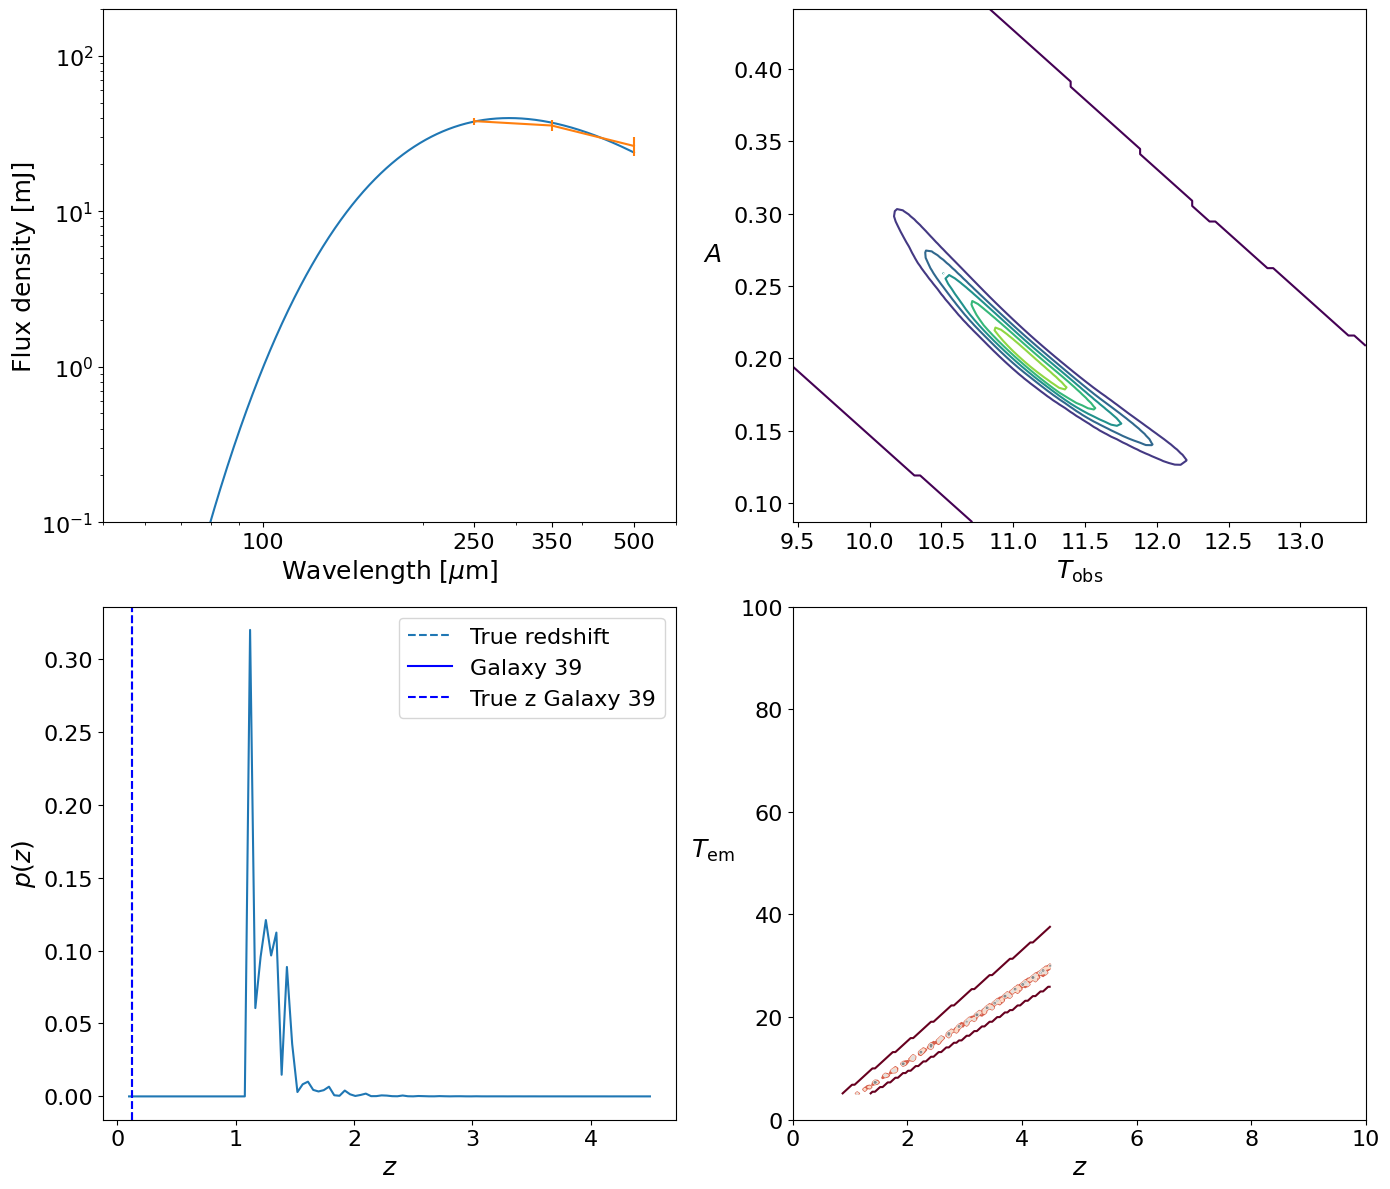

----------------------------------------------------------
GALAXY ID =  40
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [25.19562434 26.26550837]


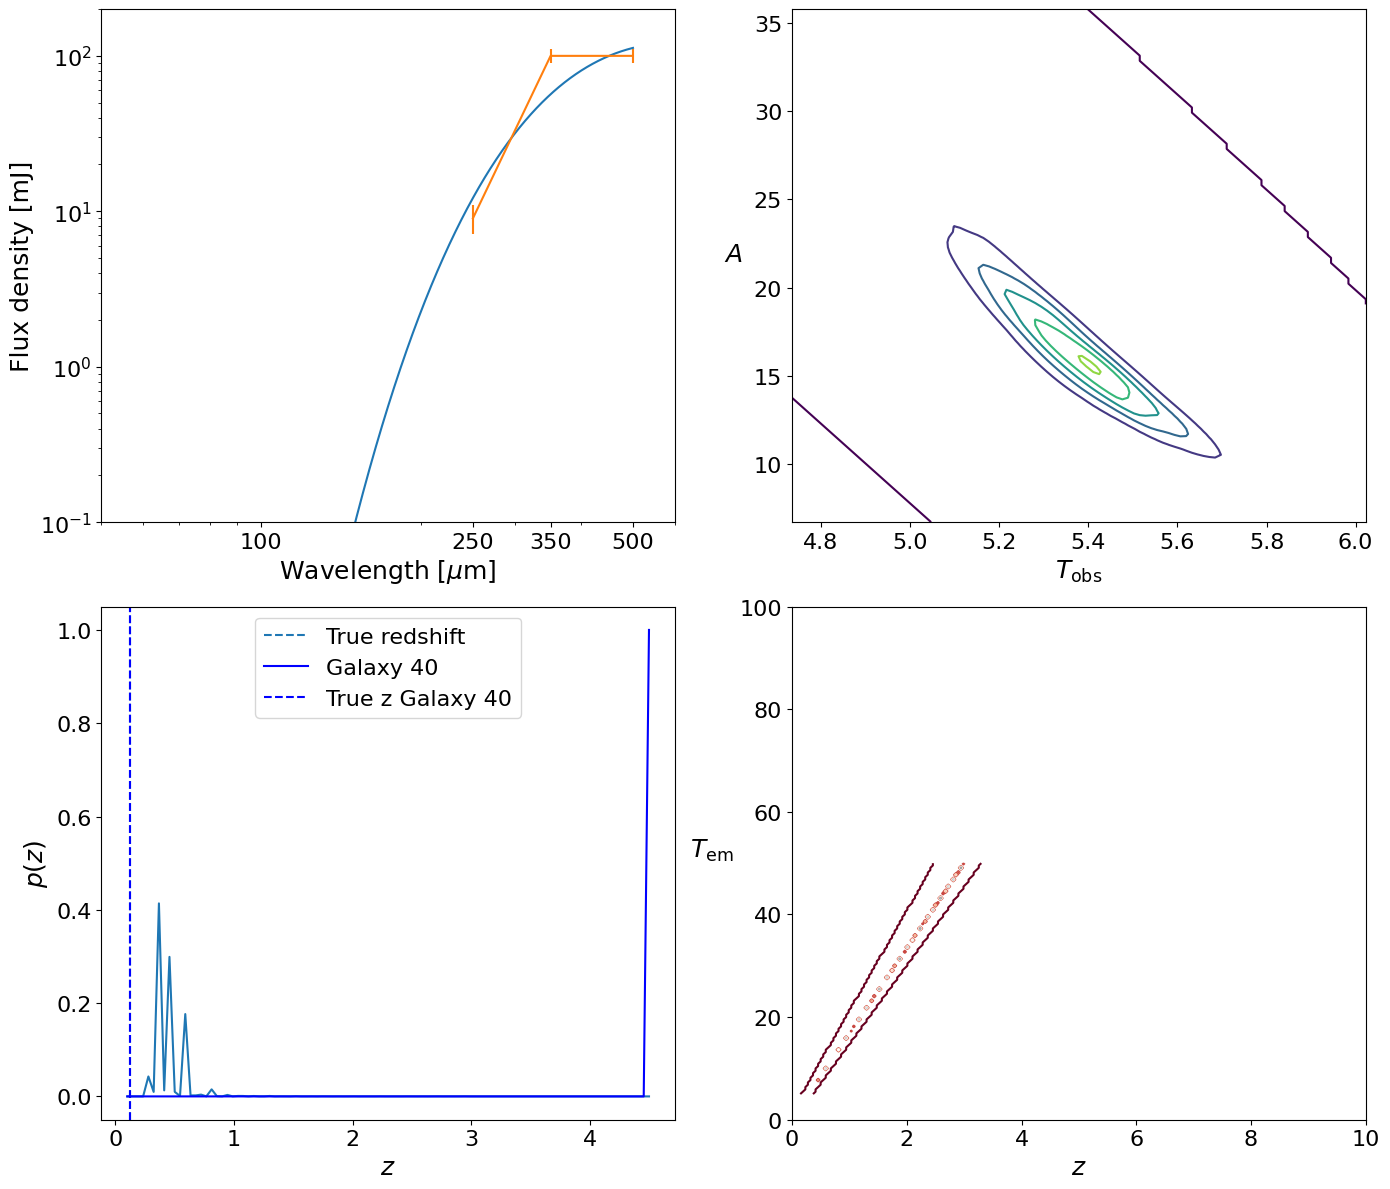

----------------------------------------------------------
GALAXY ID =  41
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [44.75045895 45.28496053]


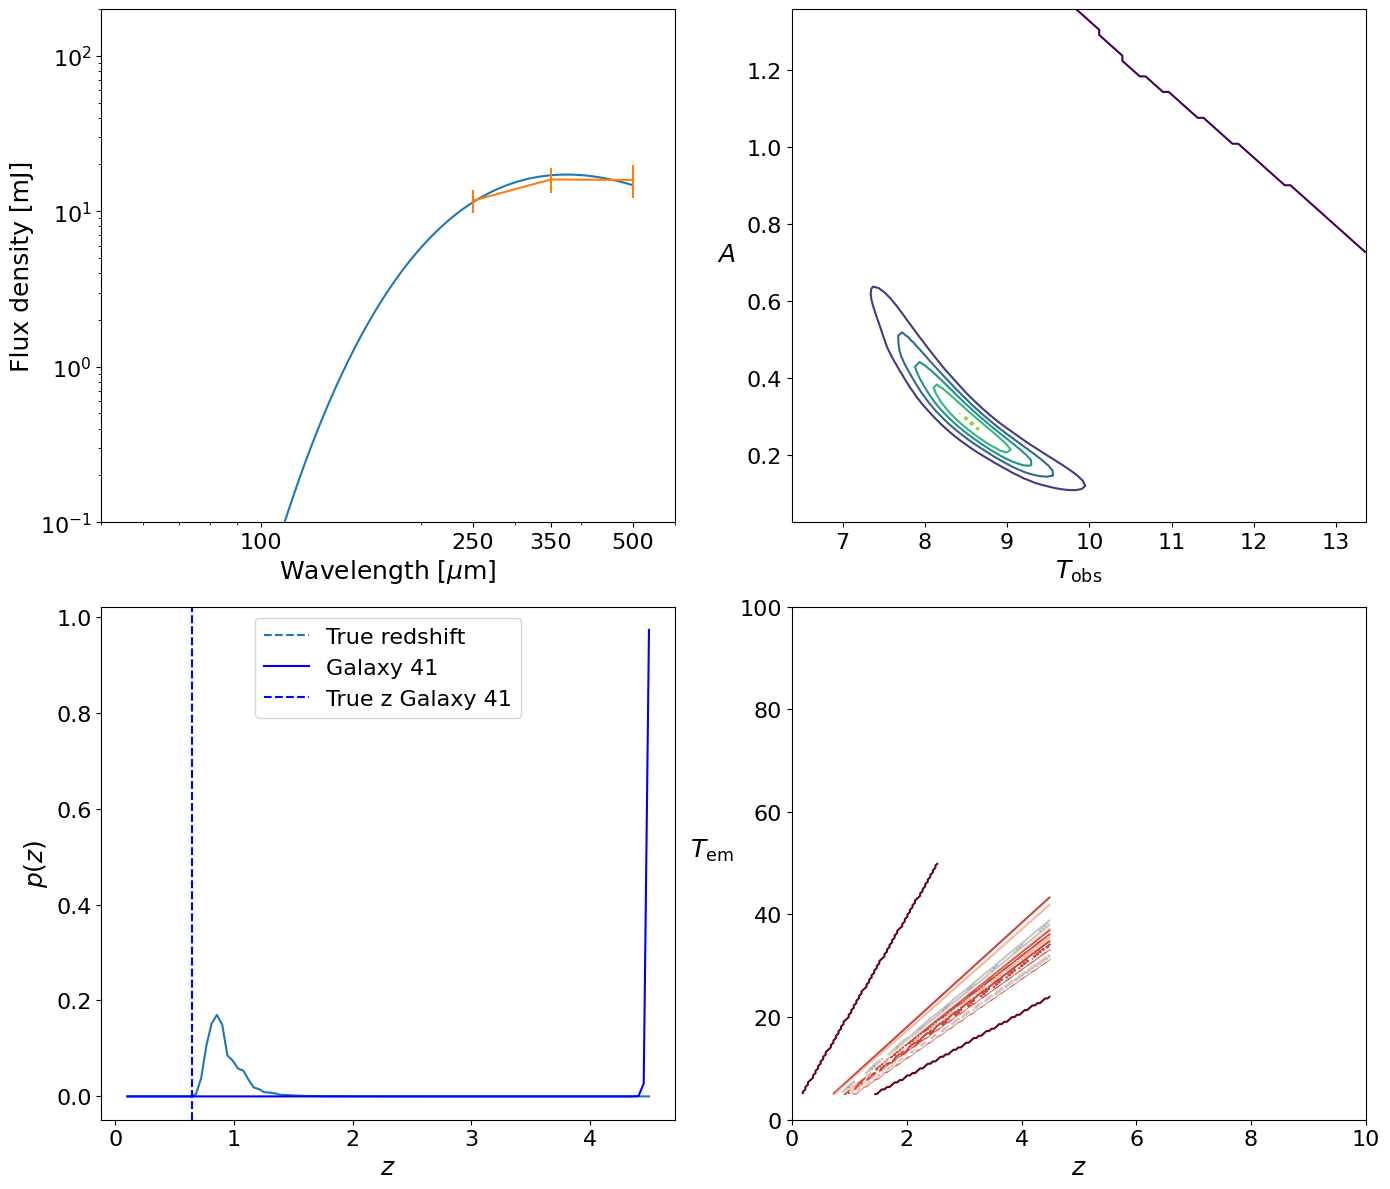

----------------------------------------------------------
GALAXY ID =  42
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [123.66485265 106.36432093]


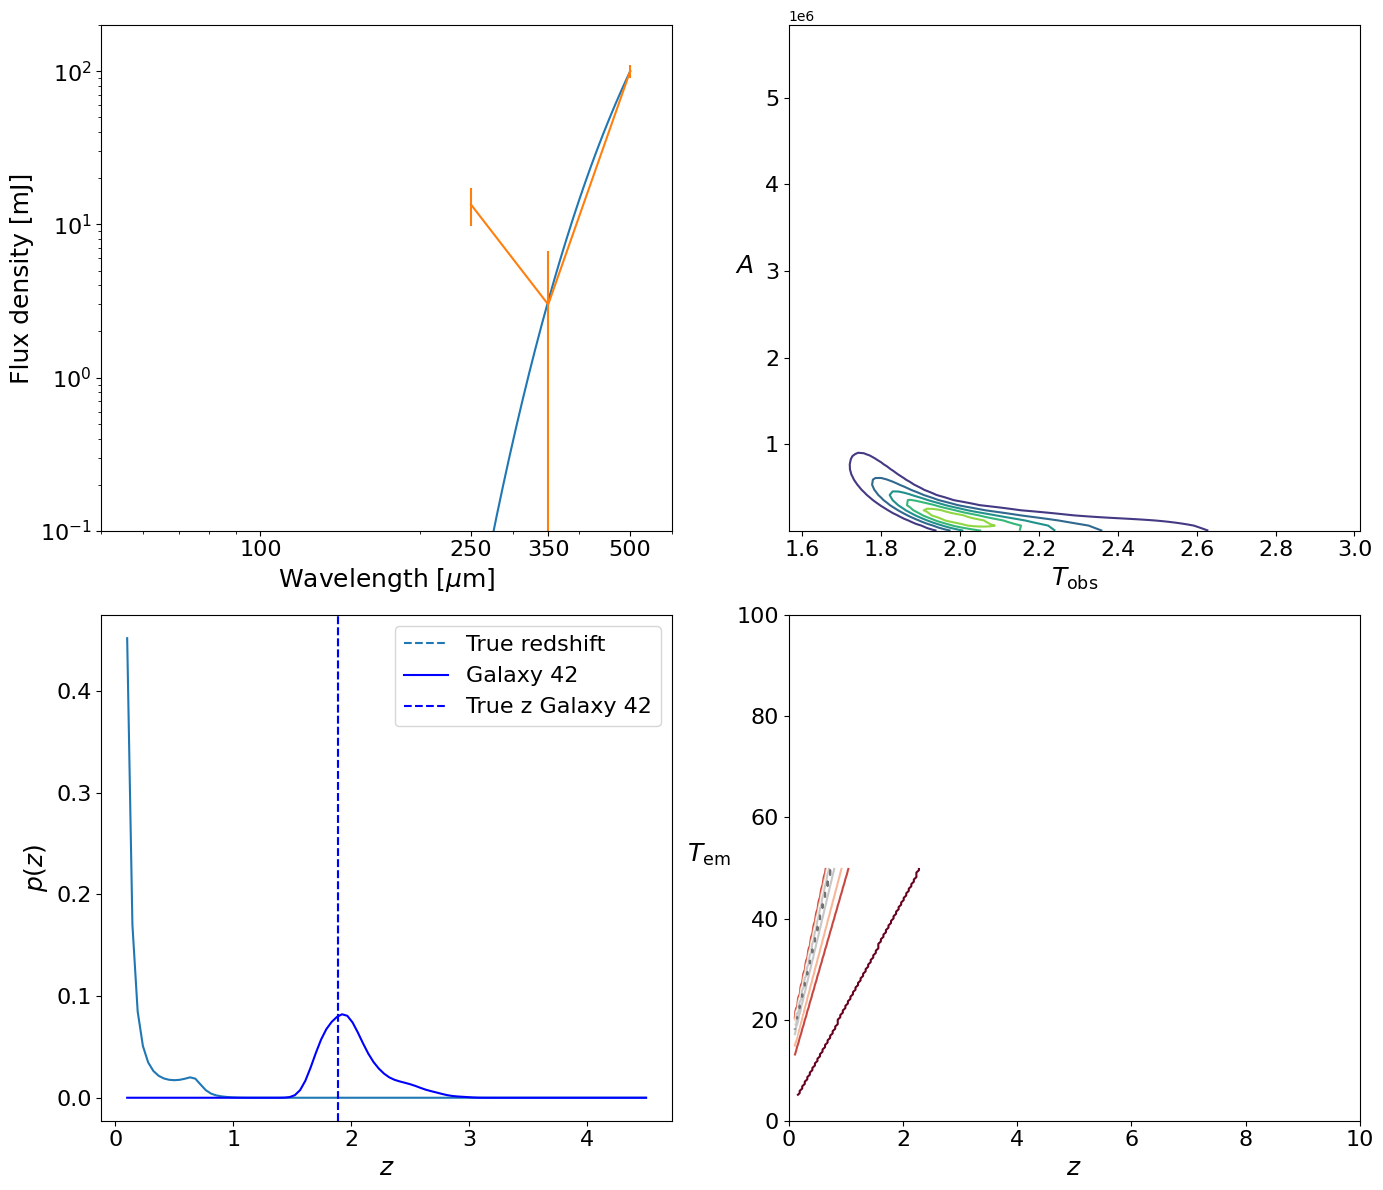

----------------------------------------------------------
GALAXY ID =  43
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [49.28552177 47.73979029]


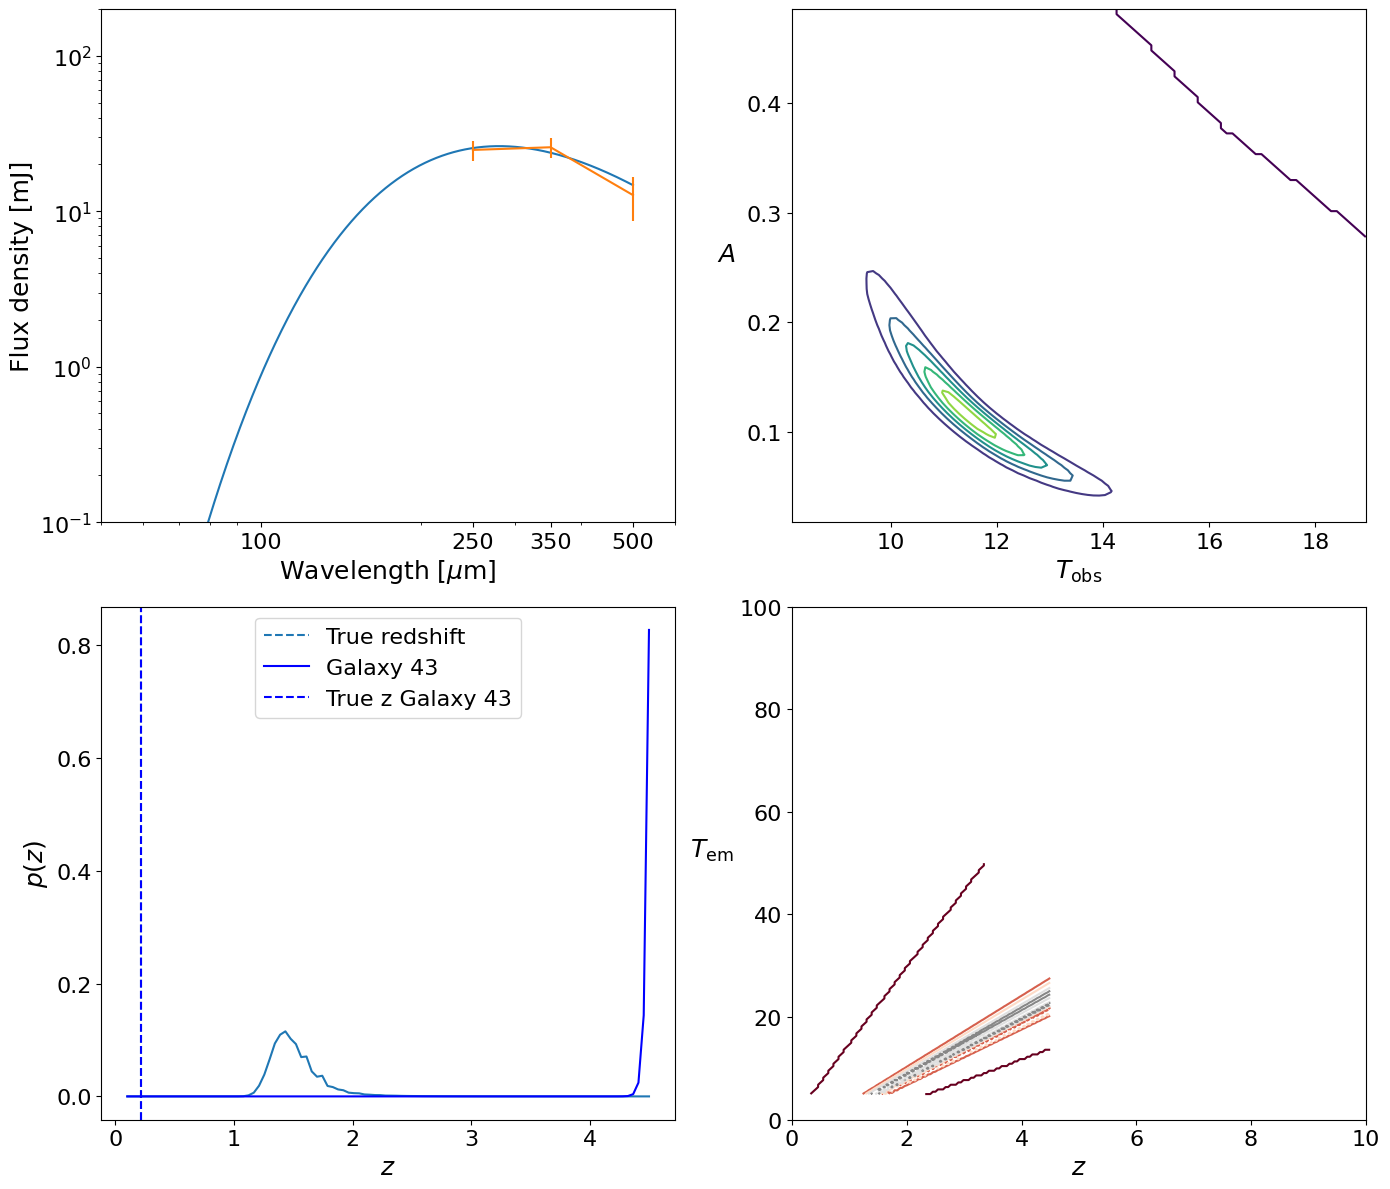

----------------------------------------------------------
GALAXY ID =  44
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [73.55449625 71.69195385]


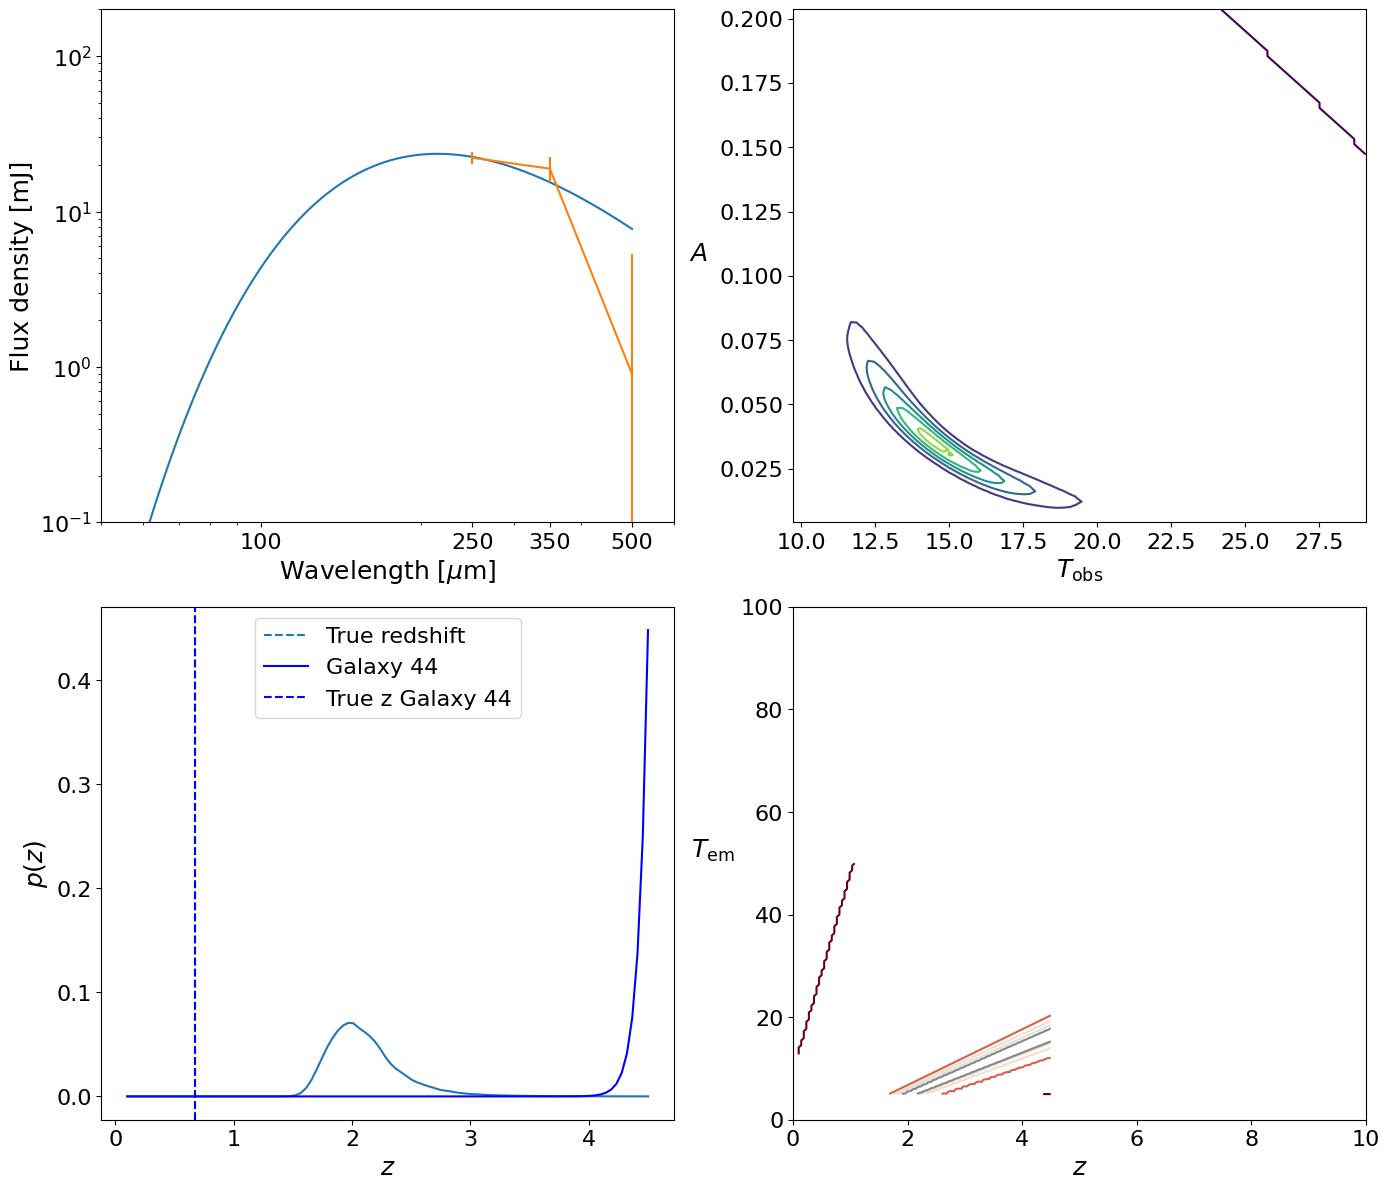

----------------------------------------------------------
GALAXY ID =  45
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [83.58933729 79.13073431]


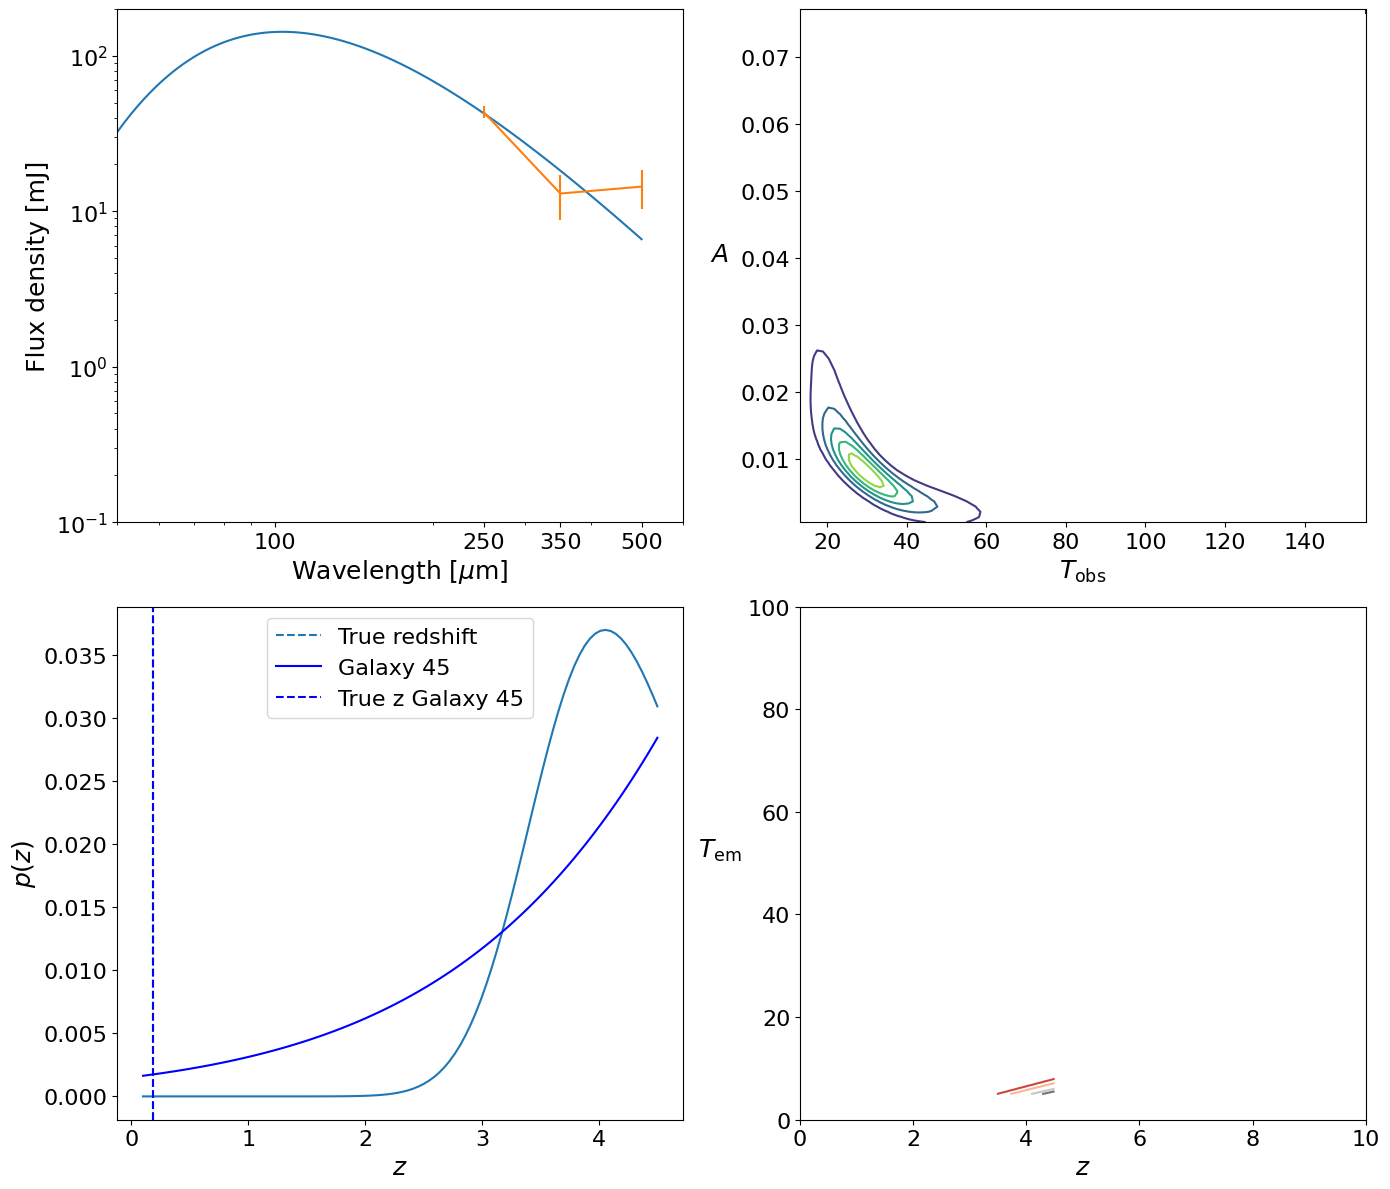

----------------------------------------------------------
GALAXY ID =  46
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [66.34568148 62.35652192]


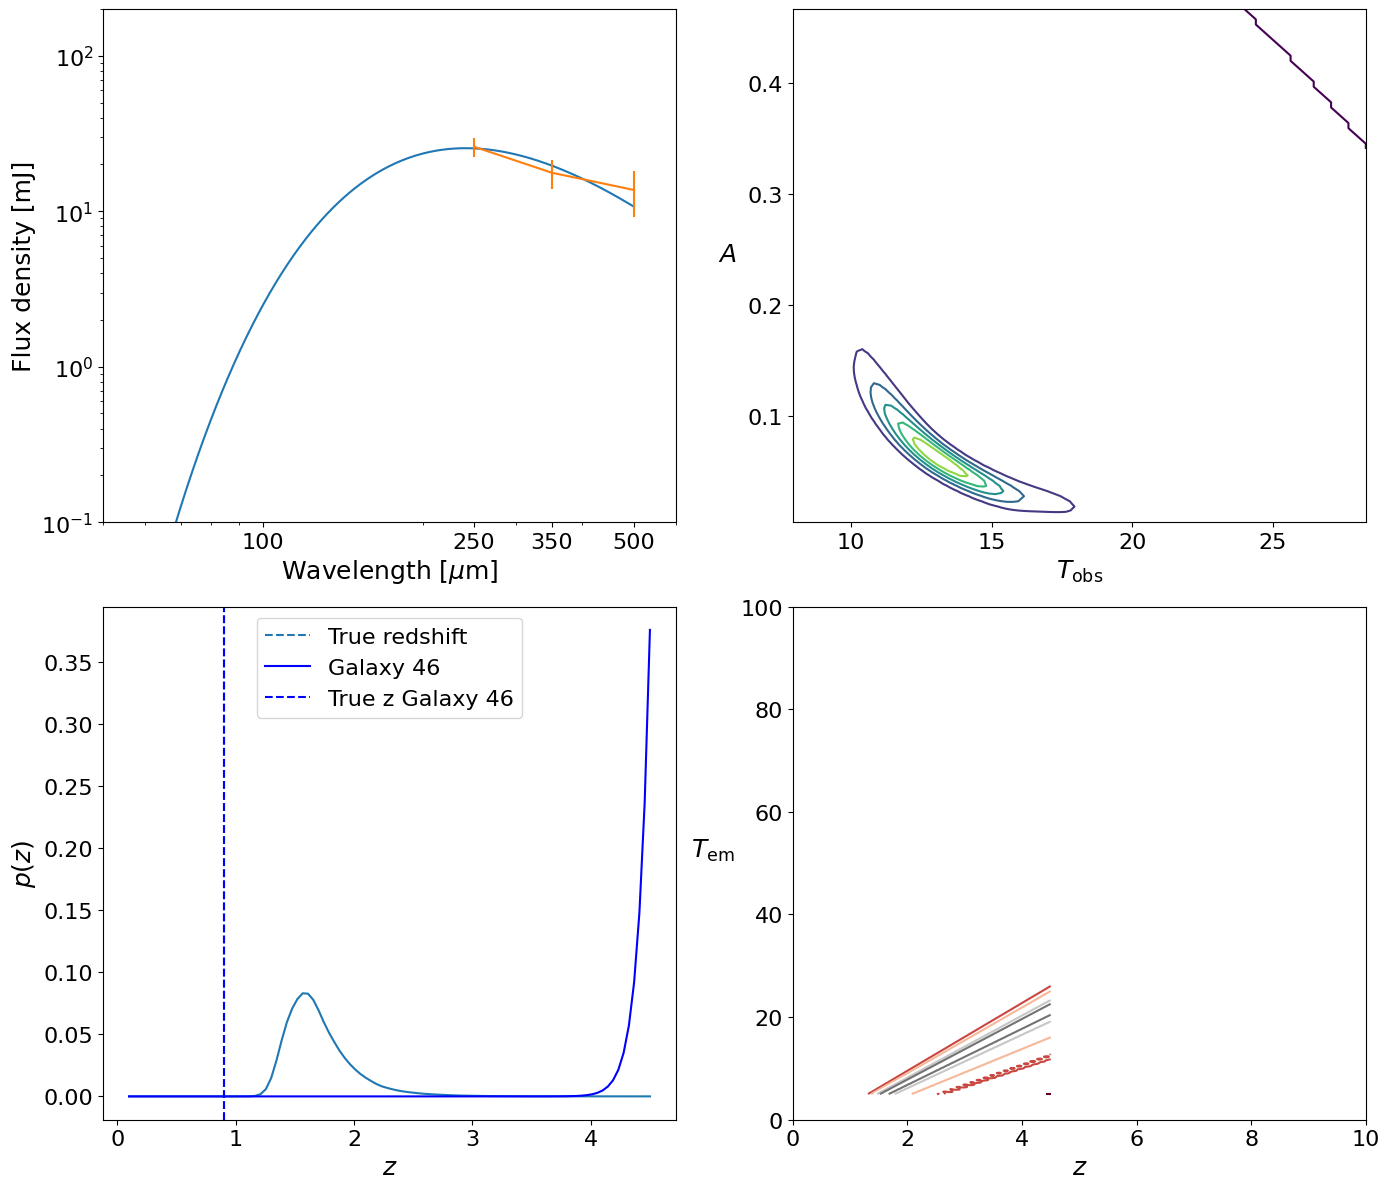

----------------------------------------------------------
GALAXY ID =  47
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [45.08702832 42.95390573]


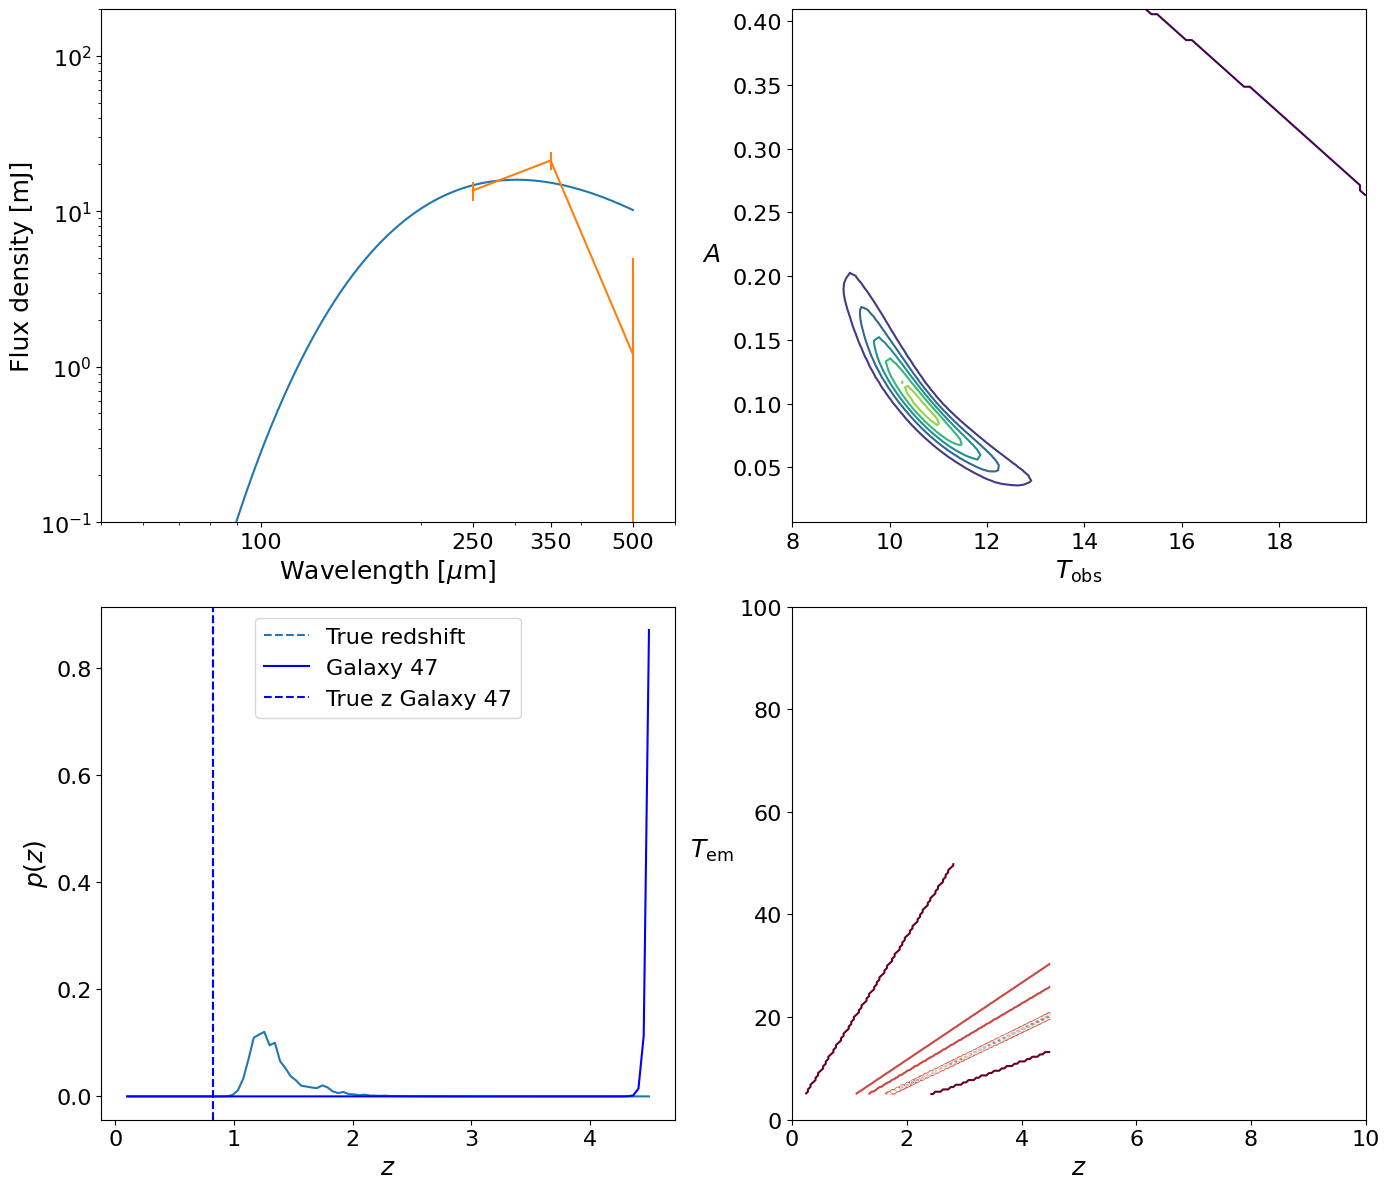

----------------------------------------------------------
GALAXY ID =  48
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [53.85796737 52.10788936]


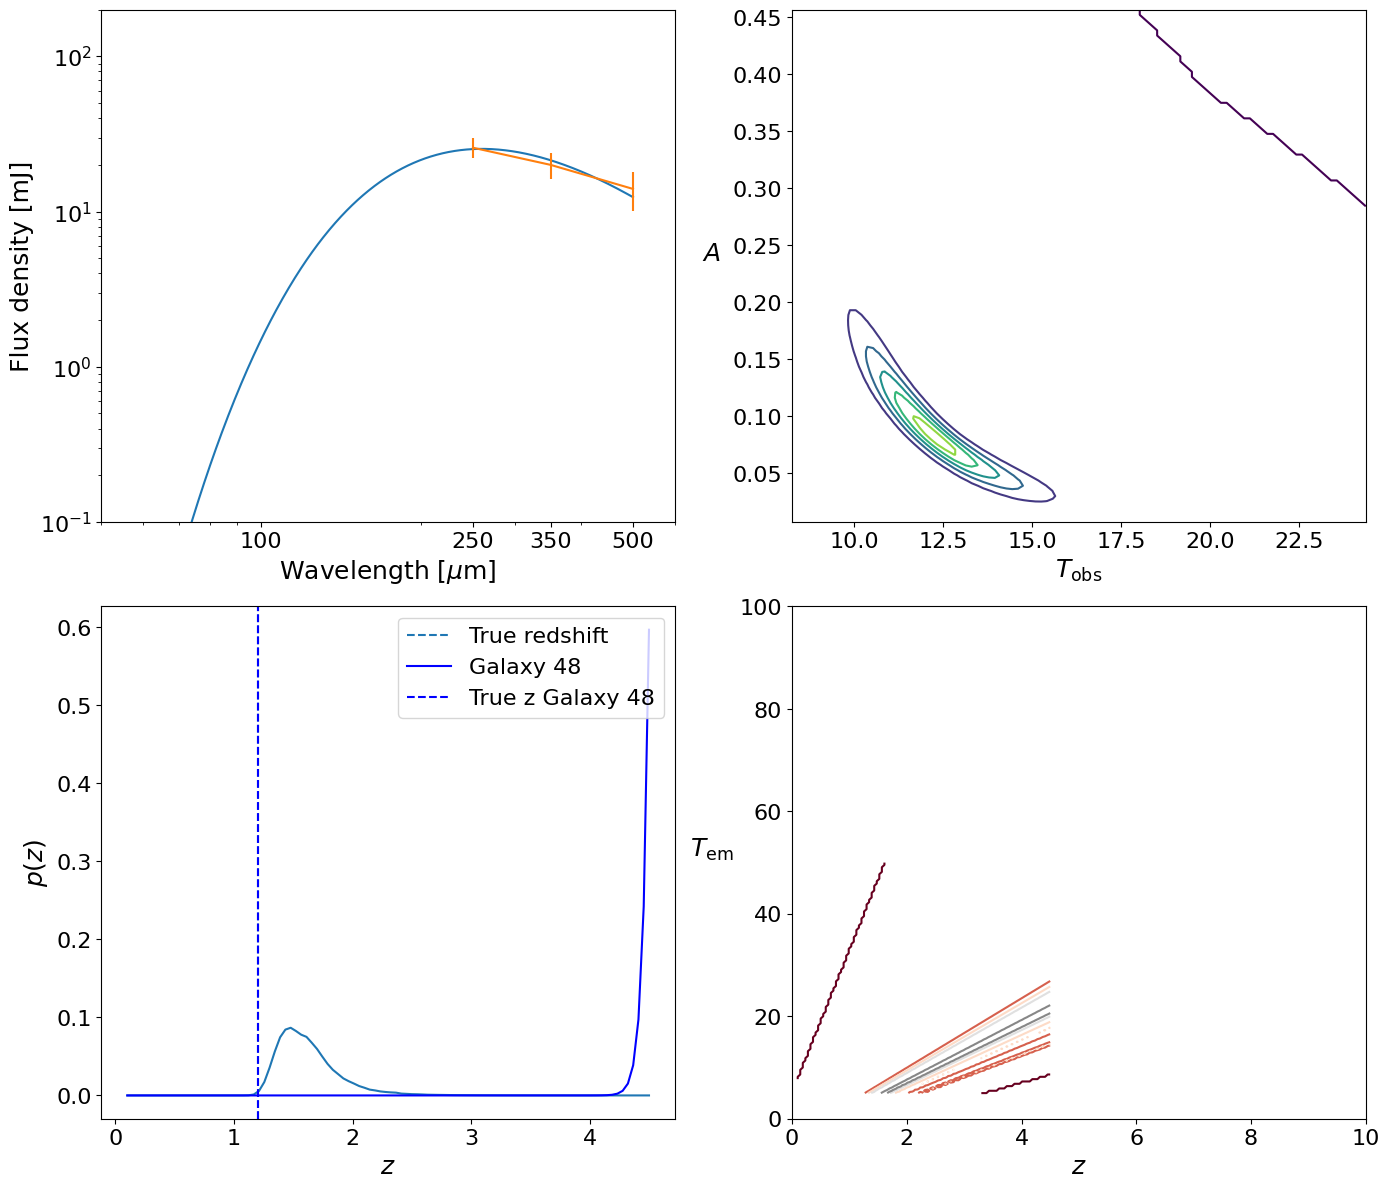

----------------------------------------------------------
GALAXY ID =  49
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [57.6321056  52.84701337]


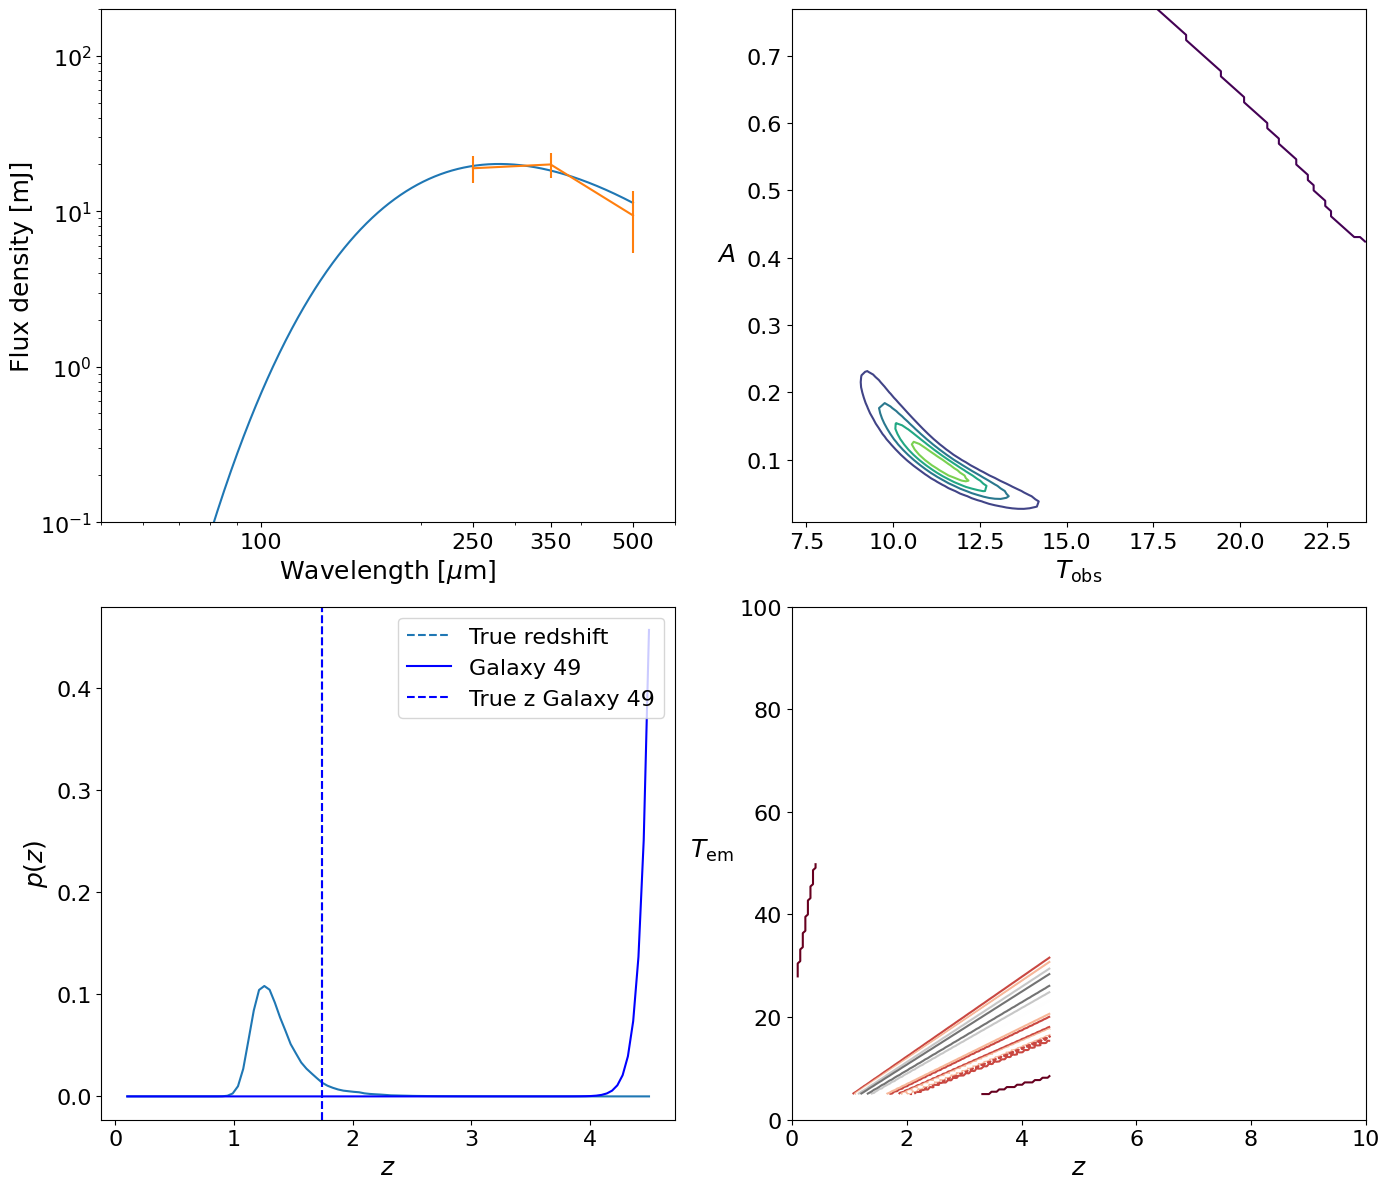

----------------------------------------------------------


In [327]:
# plot_3_flux(0)

for i in range(0,50):
    print('GALAXY ID = ', i)
    plot_3_flux(i)
    print('----------------------------------------------------------')

In [ ]:
82, 0

In [328]:
# # plot_3_flux(0)

# for i in range(100,200):
#     print('GALAXY ID = ', i)
#     plot_3_flux(i)
#     print('----------------------------------------------------------')

In [229]:
   import numpy as np
import lmfit
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from scipy.stats import gaussian_kde
from scipy.integrate import simps

def compare_3_flux(index1, index2):
    # Get data for both galaxies
    spire_fluxes_1, spire_flux_errors_1 = S_array[index1], S_err_array[index1]
    actual_z_1, actual_T_1 = z[index1], T[index1]

    spire_fluxes_2, spire_flux_errors_2 = S_array[index2], S_err_array[index2]
    actual_z_2, actual_T_2 = z[index2], T[index2]

    def fit_galaxy(spire_fluxes, spire_flux_errors):
        p = lmfit.Parameters()
        p.add_many(('T0', 10), ('A0', 1))

        def residual(p):
            v = p.valuesdict()
            return (vector_modified_blackbody_distribution(freq_obs, v['T0'], v['A0']) - spire_fluxes) / spire_flux_errors

        mi = lmfit.minimize(residual, p, method='nelder')
        T_obs = mi.params['T0'].value
        A = mi.params['A0'].value
        best_fit = vector_modified_blackbody_distribution(fa, T_obs, A)

        return mi, residual, T_obs, A, best_fit

    # Fit results for both galaxies
    mi_1, residual_1, T_obs_1, A_1, best_fit_1 = fit_galaxy(spire_fluxes_1, spire_flux_errors_1)
    mi_2, residual_2, T_obs_2, A_2, best_fit_2 = fit_galaxy(spire_fluxes_2, spire_flux_errors_2)

    def run_mcmc(residual, mi):
        res = lmfit.minimize(residual, method='emcee', burn=300, steps=MCMC_steps, thin=10, 
                             params=mi.params, is_weighted=True, progress=False)
        
        Ts = np.array(res.flatchain['T0'])
        As = np.array(res.flatchain['A0'])
        return Ts, As

    # Run MCMC for both galaxies
    Ts_1, As_1 = run_mcmc(residual_1, mi_1)
    Ts_2, As_2 = run_mcmc(residual_2, mi_2)

    # Create 2x2 subplots
    fig, axs = plt.subplots(2, 2, figsize=(14, 12))

    # Plot 1: Best fitting model vs. data
    axs[0, 0].loglog()
    axs[0, 0].set_xlabel('Wavelength [$\mu$m]', fontsize=18)
    axs[0, 0].set_ylabel('Flux density [mJ]', fontsize=18)

    # Plot for Galaxy 1
    axs[0, 0].plot(wa, best_fit_1, label=f'Galaxy {index1} Best Fit', color='blue')
    axs[0, 0].errorbar(SPIRE_wavelengths, spire_fluxes_1, yerr=spire_flux_errors_1, label=f'Galaxy {index1} Data', color='blue')

    # Plot for Galaxy 2
    axs[0, 0].plot(wa, best_fit_2, label=f'Galaxy {index2} Best Fit', linestyle='--', color='red')
    axs[0, 0].errorbar(SPIRE_wavelengths, spire_fluxes_2, yerr=spire_flux_errors_2, label=f'Galaxy {index2} Data', fmt='--', color='red')

    axs[0, 0].legend()
    axs[0, 0].set_xlim(5e1, 6e2)
    axs[0, 0].set_ylim(1e-1, 2e1)

    # Set xticks for ax1
    locs = np.append(axs[0, 0].xaxis.get_major_locator().tick_values(5e1, 6e2), [250, 350, 500])
    axs[0, 0].xaxis.set_major_locator(ticker.FixedLocator(locs))
    labels = [str(int(loc)) if loc >= 100 else '' for loc in locs]
    axs[0, 0].xaxis.set_major_formatter(ticker.FixedFormatter(labels))
    axs[0, 0].tick_params(axis='both', which='major', labelsize=16)

    # Plot 2: Gaussian KDE results
    def plot_kde(ax, Ts, As, color, label):
        values = np.vstack([Ts, As])
        kde_kernel = gaussian_kde(values)

        N = 100
        X, Y = np.meshgrid(np.linspace(Ts.min(), Ts.max(), N), np.linspace(As.min(), As.max(), N))
        positions = np.vstack([X.ravel(), Y.ravel()])
        Z = np.reshape(kde_kernel(positions).T, X.shape)
        Z = Z / np.sum(Z)

        # Plot contour
        ax.contour(X, Y, Z, 20, colors=color, label=label)
        ax.set_xlabel(r'$\mathit{T}_{\mathrm{obs}}$', fontsize=18)
        ax.set_ylabel(r'$\mathit{A}$', fontsize=18, rotation=0, labelpad=15)
        ax.tick_params(axis='both', which='major', labelsize=16)

    # Plot KDE for both galaxies
    plot_kde(axs[0, 1], Ts_1, As_1, 'blue', f'Galaxy {index1}')
    plot_kde(axs[0, 1], Ts_2, As_2, 'red', f'Galaxy {index2}')

    # Define functions to access KDE results
    def get_pdf_s_t(a, t, kde_kernel):
        return kde_kernel.pdf(np.array([[t, a]]).T)[0]

    def get_p_z_e(z_i, e_i, kde_kernel):
        return get_pdf_s_t(a=gg[z_i, e_i], t=hh[z_i, e_i], kde_kernel=kde_kernel)

    pdf_z_e = np.vectorize(get_p_z_e)

    # Compute pdf over emission frame meshgrid for both galaxies
    kde_kernel_1 = gaussian_kde(np.vstack([Ts_1, As_1]))
    kde_kernel_2 = gaussian_kde(np.vstack([Ts_2, As_2]))

    p_z_e_1 = np.array(pdf_z_e(z_i=z_index, e_i=e_index, kde_kernel=kde_kernel_1))
    p_z_e_2 = np.array(pdf_z_e(z_i=z_index, e_i=e_index, kde_kernel=kde_kernel_2))

    # Plot 3: Contour plot of emission frame for both galaxies
    axs[1, 1].contour(zz, ee, p_z_e_1, 5, cmap='Blues', alpha=0.5, label=f'Galaxy {index1}')
    axs[1, 1].contour(zz, ee, p_z_e_2, 5, cmap='Reds', alpha=0.5, label=f'Galaxy {index2}')
    axs[1, 1].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 1].set_ylabel(r'$\mathit{T}_{\mathrm{em}}$', fontsize=18, rotation=0, labelpad=20)
    axs[1, 1].tick_params(axis='both', which='major', labelsize=16)
    axs[1, 1].legend()

    # Multiply by jacobian and marginalize over e for both galaxies
    p_z_e_1 *= jacob
    p_z_1 = np.array([simps(p, e_grid) for p in p_z_e_1.T])
    p_z_1 = p_z_1 / np.sum(p_z_1)

    p_z_e_2 *= jacob
    p_z_2 = np.array([simps(p, e_grid) for p in p_z_e_2.T])
    p_z_2 = p_z_2 / np.sum(p_z_2)

    # Plot 4: Marginalized pdf over z for both galaxies
    axs[1, 0].plot(z_grid, p_z_1, label=f'Galaxy {index1}', color='blue')
    axs[1, 0].plot(z_grid, p_z_2, label=f'Galaxy {index2}', color='red')
    axs[1, 0].axvline(x=actual_z_1, label=f'True z Galaxy {index1}', linestyle='dashed', color='blue')
    axs[1, 0].axvline(x=actual_z_2, label=f'True z Galaxy {index2}', linestyle='dashed', color='red')
    axs[1, 0].set_xlabel(r'$\mathit{z}$', fontsize=18)
    axs[1, 0].set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
    axs[1, 0].tick_params(axis='both', which='major', labelsize=16)
    axs[1, 0].legend(fontsize=16)

#     # Print fit reports
#     print("Galaxy", index1)
#     lmfit.printfuncs.report_fit(mi_1.params, min_correl=0.0)
#     print("Galaxy", index2)
#     lmfit.printfuncs.report_fit(mi_2.params, min_correl=0.0)






    
    
    
    
    # Replace the bottom-left plot (Marginalized pdf over z) with a new KDE-based function
    def marginalized_pdf_z(ax, Ts, As, z_values, label, color, actual_z):
        # Combine Ts and As to calculate KDE over redshift
        values = np.vstack([Ts, As])
        kde_kernel = gaussian_kde(values)

        # Create meshgrid for z and emission
        N = 100  # Number of grid points
        z_grid = np.linspace(min(z_values), max(z_values), N)
        e_grid = np.linspace(min(As), max(As), N)
        Z, E = np.meshgrid(z_grid, e_grid)

        # Compute the KDE over the meshgrid
        positions = np.vstack([Z.ravel(), E.ravel()])
        P = np.reshape(kde_kernel(positions).T, Z.shape)
        P = P / np.sum(P)  # Normalize the PDF

        # Multiply by Jacobian and marginalize over emission (e) for redshift
        marginalized_p_z = np.array([simps(P[:, i], e_grid) for i in range(P.shape[1])])
        marginalized_p_z = marginalized_p_z / np.sum(marginalized_p_z)  # Normalize

        # Plot the marginalized PDF for redshift
        ax.plot(z_grid, marginalized_p_z, label=label, color=color)
        ax.axvline(x=actual_z, linestyle='dashed', color=color, label=f'True z {label}')
        ax.set_xlabel(r'$\mathit{z}$', fontsize=18)
        ax.set_ylabel(r'$p(z)$', fontsize=18, rotation=90)
        ax.tick_params(axis='both', which='major', labelsize=16)
        ax.legend(fontsize=16)
    
    # Use the new KDE-based PDF calculation for both galaxies
    marginalized_pdf_z(axs[1, 0], Ts_1, As_1, z_grid, f'Galaxy {index1}', 'blue', actual_z_1)
    marginalized_pdf_z(axs[1, 0], Ts_2, As_2, z_grid, f'Galaxy {index2}', 'red', actual_z_2)

  
    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

    

The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [122.34336593 106.80166904]
The chain is shorter than 50 times the integrated autocorrelation time for 2 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 20;
tau: [44.57734168 42.96476497]


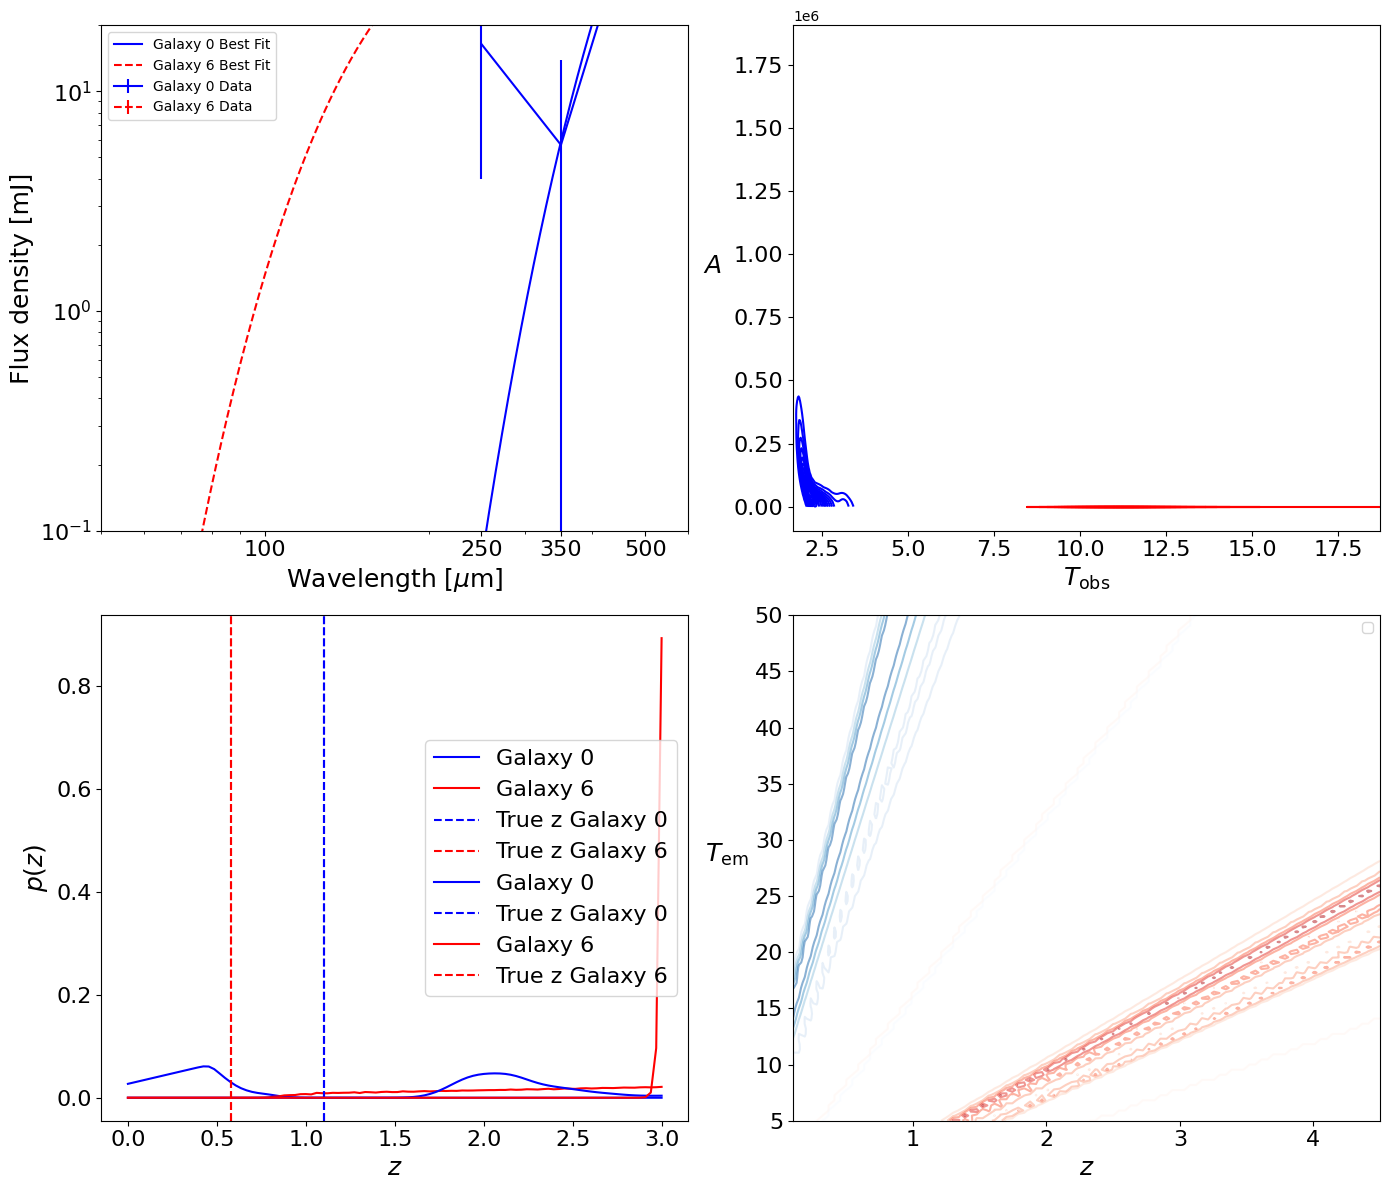

In [230]:
compare_3_flux(index1=0, index2=6)

